# Analysis of Sensor and Lab samples Intermediate Datasets

In [1]:
import os
import sys

sys.path.append('..')

import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import scipy.stats as stats

from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance

from utils.functions.normalize_string import normalize_string

In [2]:
data_folder = os.path.join('..', "data")
utils_folder = os.path.join('..', "utils")

interm_data_folder = os.path.join(data_folder, "Intermediate Data")

In [3]:
# import feature mappings
with open(os.path.join(utils_folder, 'mappings', "eb0_features_mapping.json")) as f:
    eb0_features_mapping = json.load(f)
    
with open(os.path.join(utils_folder, 'mappings', "eb1_features_mapping.json")) as f:
    eb1_features_mapping = json.load(f)

# Load Data

In [4]:
eb0_features_lab_df = pd.read_excel(
    os.path.join(interm_data_folder, "EB0_Features_Lab.xlsx")
)

eb0_targets_lab_df = pd.read_excel(
    os.path.join(interm_data_folder, "EB0_Targets_Lab.xlsx")
)

In [5]:
eb1_features_lab_df = pd.read_excel(
    os.path.join(interm_data_folder, "EB1_Features_Lab.xlsx")
)

eb1_targets_lab_df = pd.read_excel(
    os.path.join(interm_data_folder, "EB1_Targets_Lab.xlsx")
)

In [6]:
eb0_sensor_df = pd.read_excel(
    os.path.join(interm_data_folder, "EB0_Sensor.xlsx")
)

In [7]:
eb1_sensor_df = pd.read_excel(
    os.path.join(interm_data_folder, "EB1_Sensor.xlsx")
)

In [8]:
thms_df = pd.read_excel(os.path.join(interm_data_folder, "THMs.xlsx"))

# Lab vs Sensor Data

## EB0

In [9]:
eb0_features_lab_df.columns = [
    normalize_string(c) for c in eb0_features_lab_df.columns
]

eb0_features_mapping = {
    normalize_string(k): v for k, v in eb0_features_mapping.items()
}

### Histograms

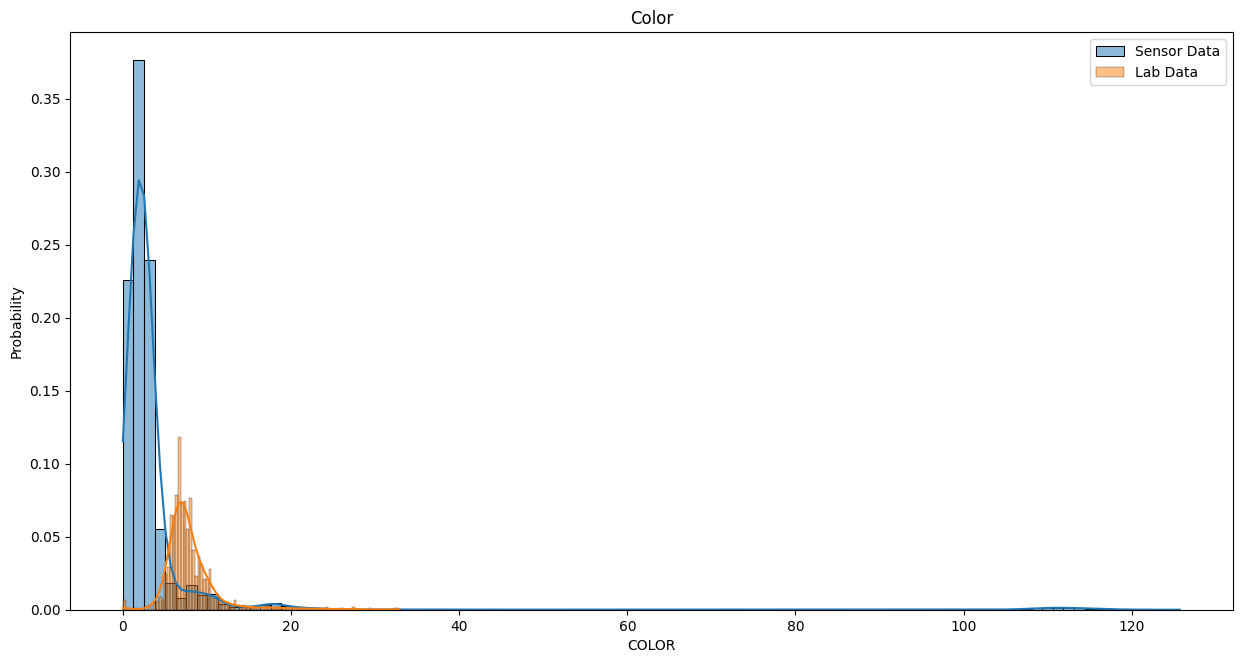

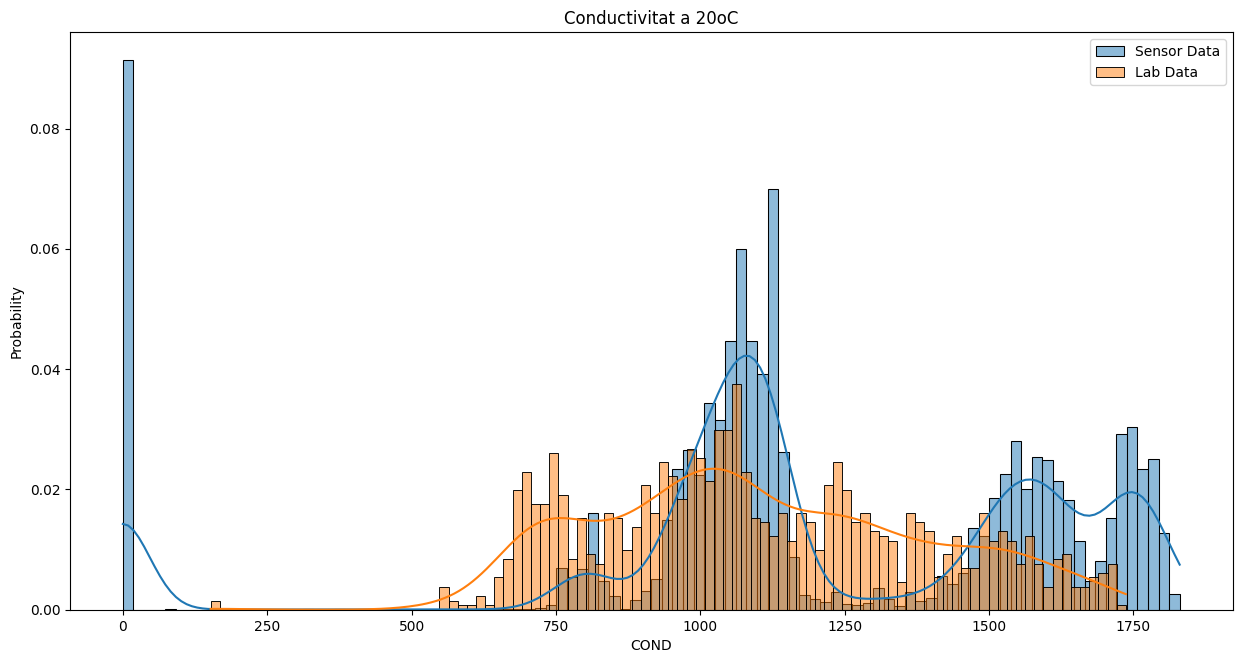

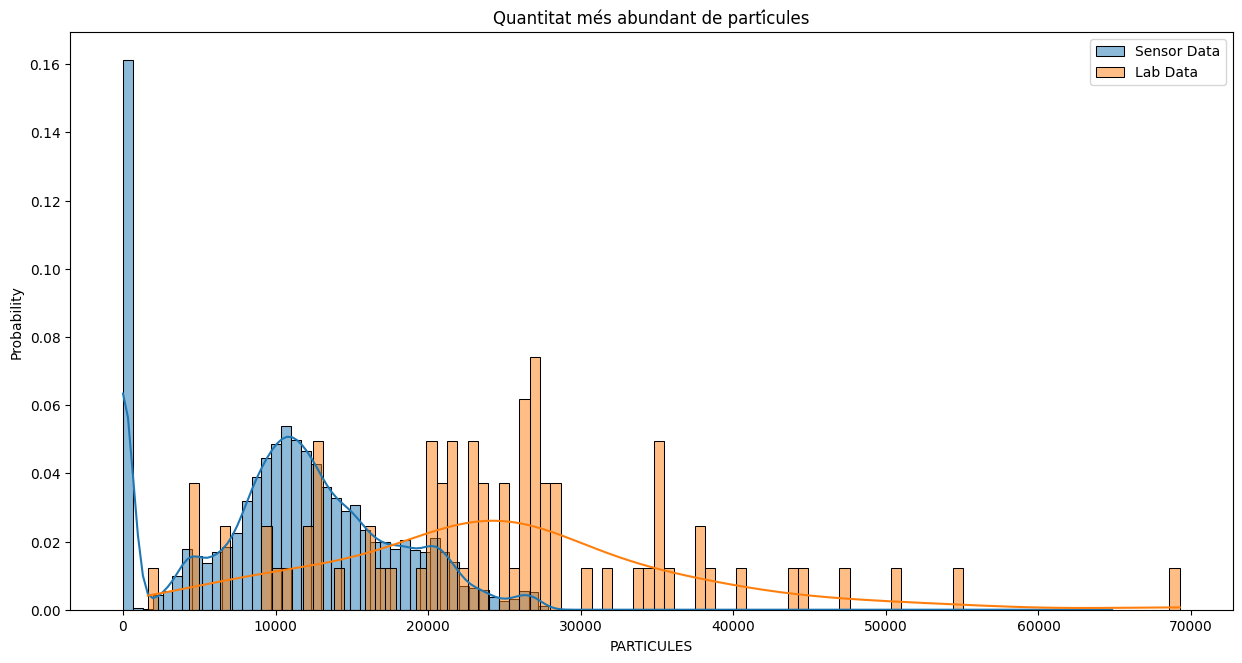

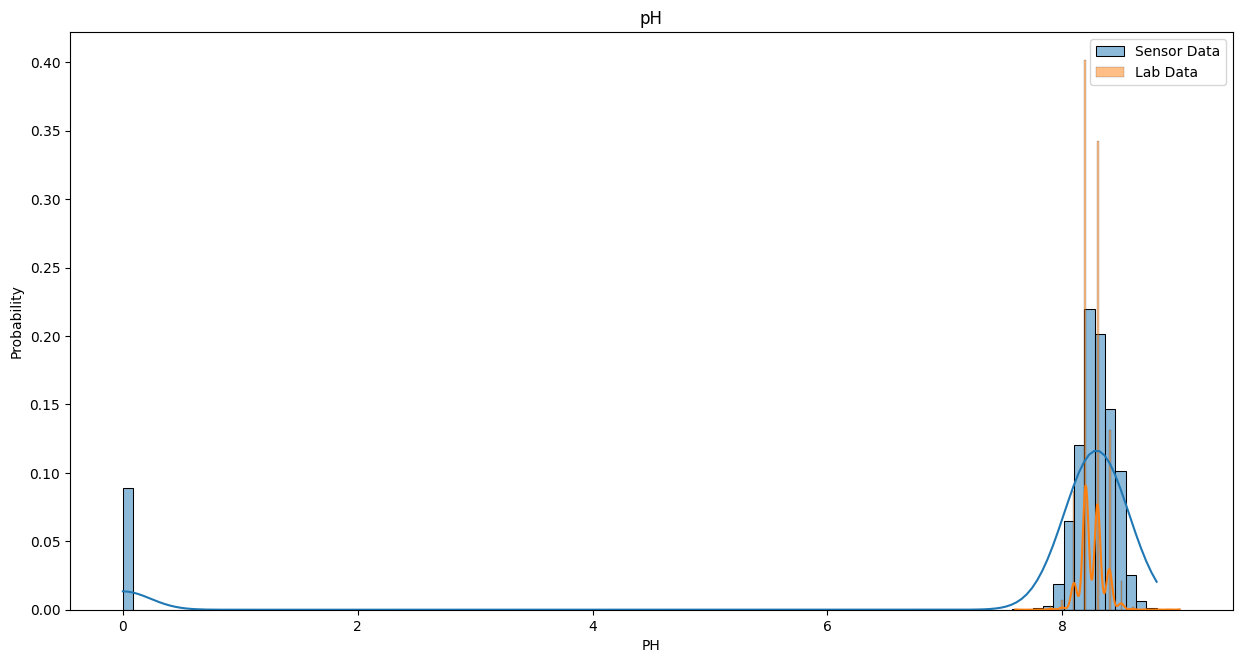

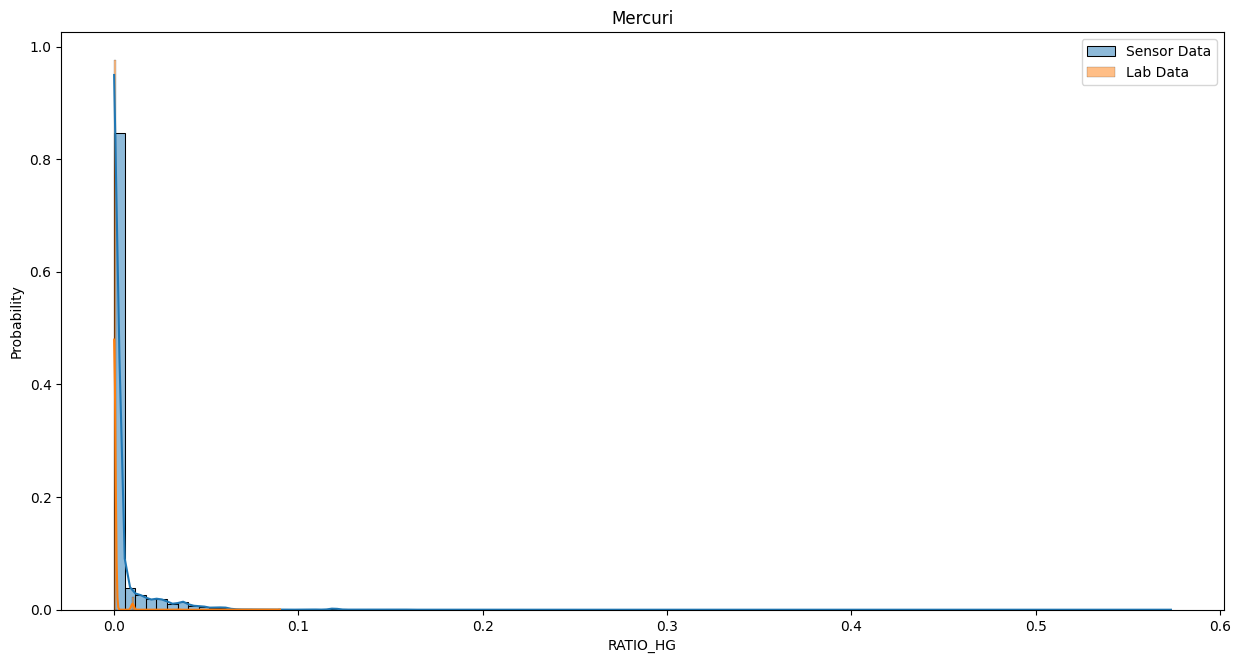

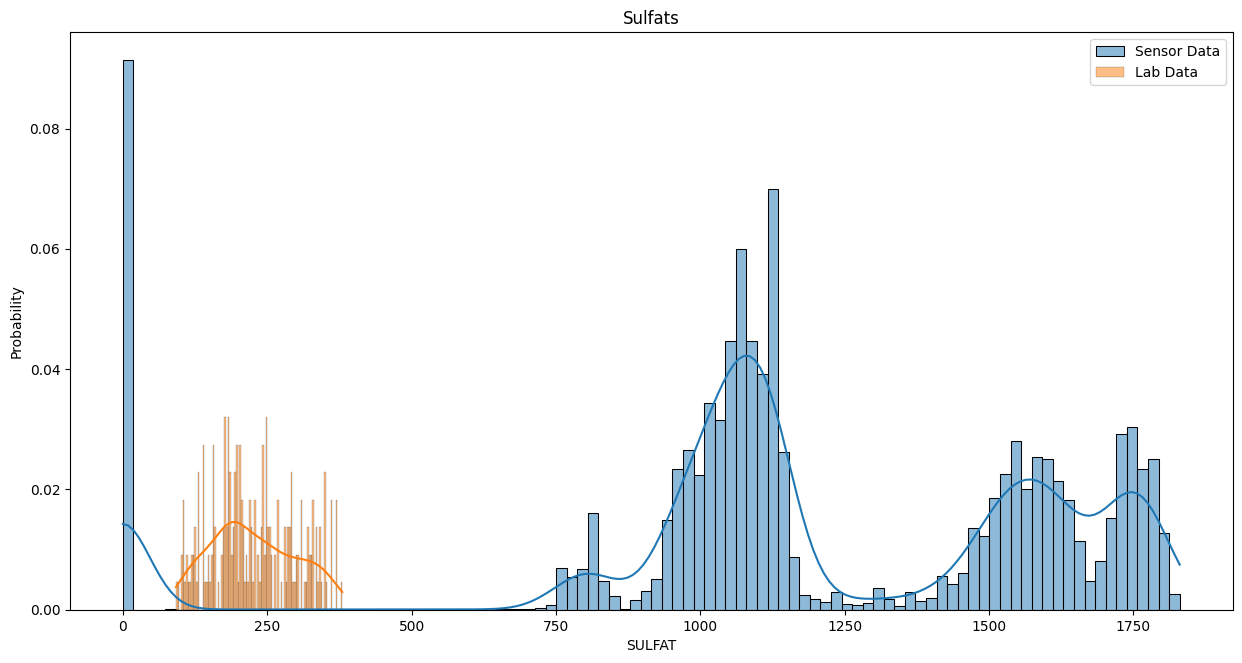

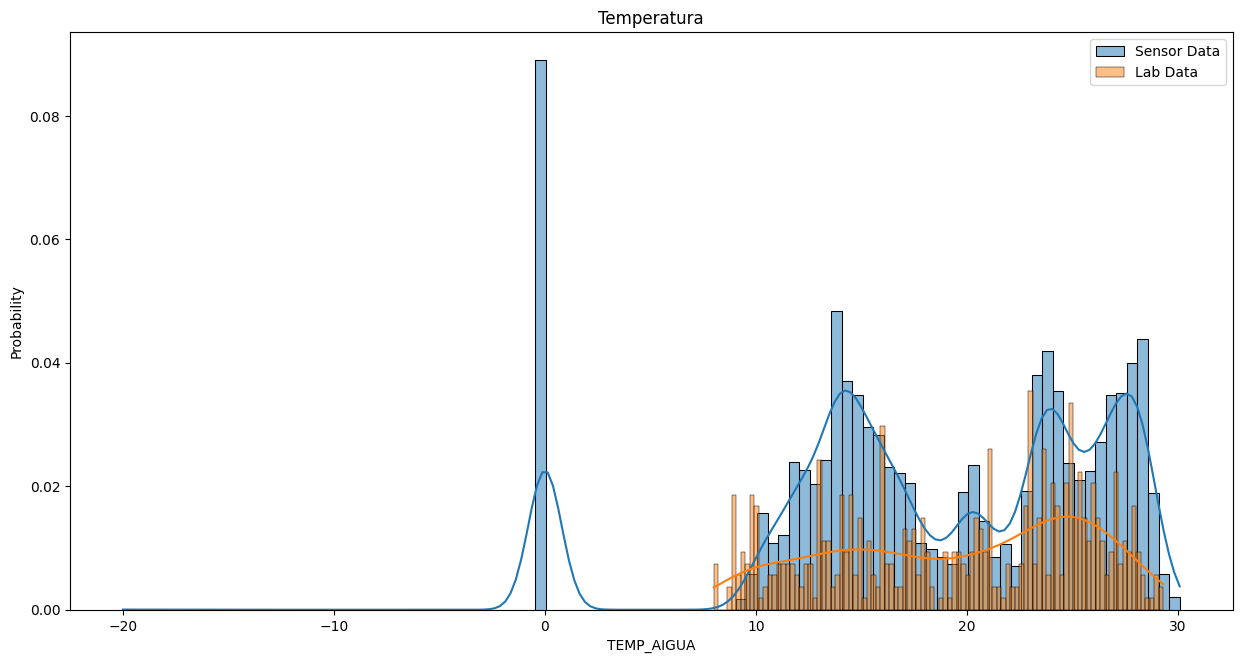

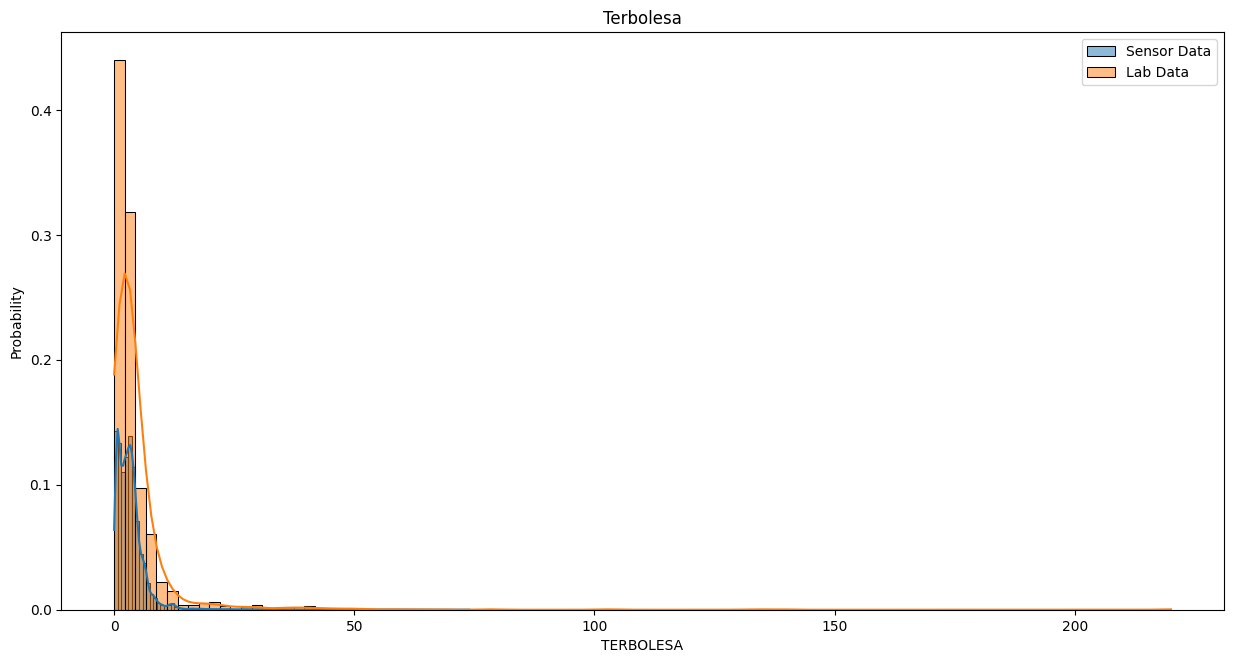

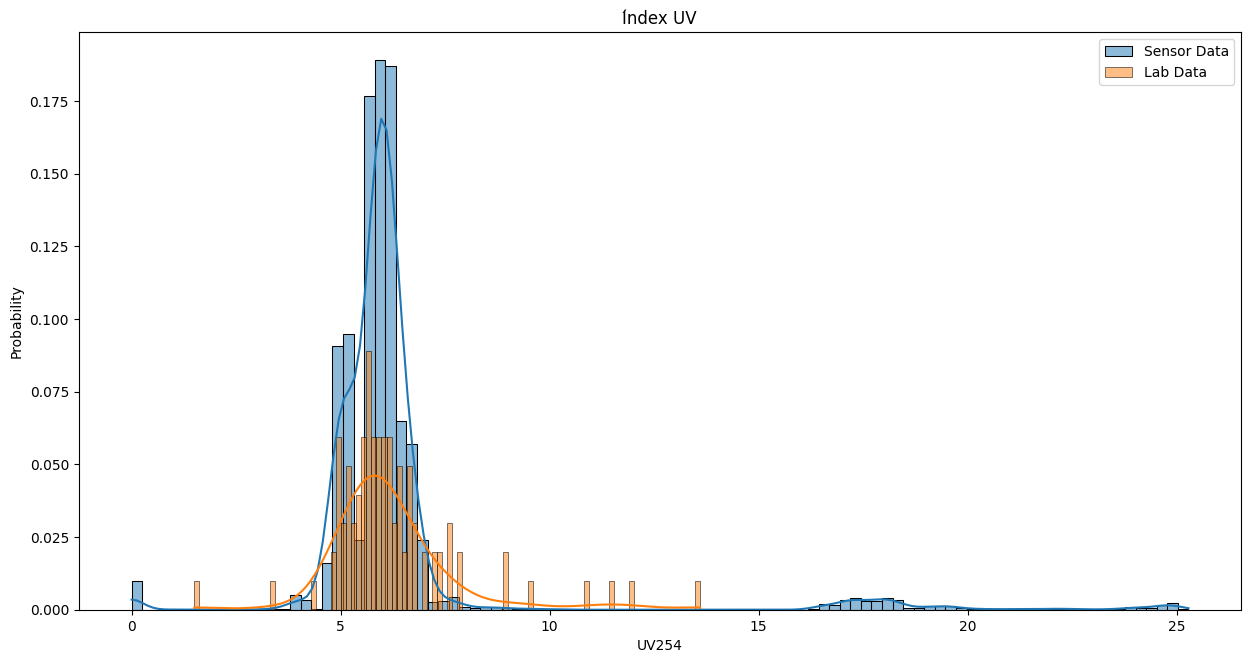

In [10]:
for lab_key, sensor_key in eb0_features_mapping.items():
    lab_key = normalize_string(lab_key)
    lab_df = eb0_features_lab_df[lab_key]
    sensor_df = eb0_sensor_df[sensor_key]

    # remove 0 values from sensor data
    # sensor_df = sensor_df[sensor_df != 0]

    if not lab_df.empty and not sensor_df.empty:
        plt.figure(figsize=(15, 7.5))
        

        sns.histplot(
            data=sensor_df,
            kde=True,
            bins=100,
            alpha=0.5,
            stat="probability",
            label="Sensor Data",
        )

        sns.histplot(
            data=lab_df, kde=True, bins=100, stat="probability", label="Lab Data"
        )

        plt.title(lab_key)
        plt.legend()
        plt.show()

        # The y-axis of a histplot with stat="probability" corresponds
        # to the probability that a value belongs to a certain bar.
        # The sum of the bar heights must be 1.

### Boxplots

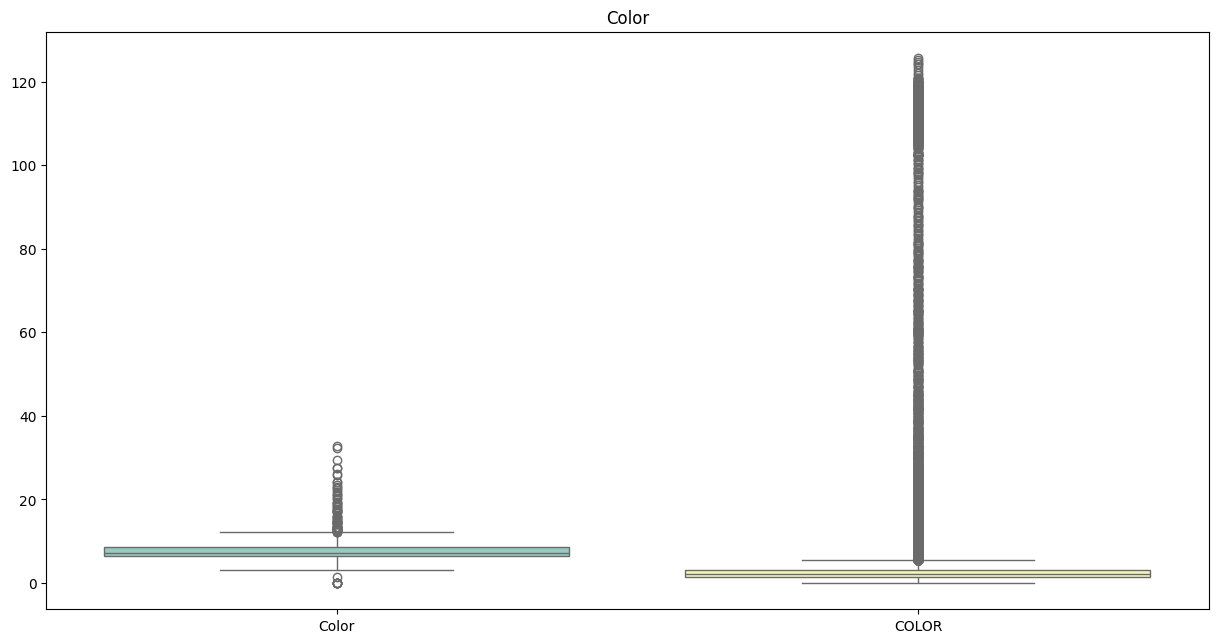

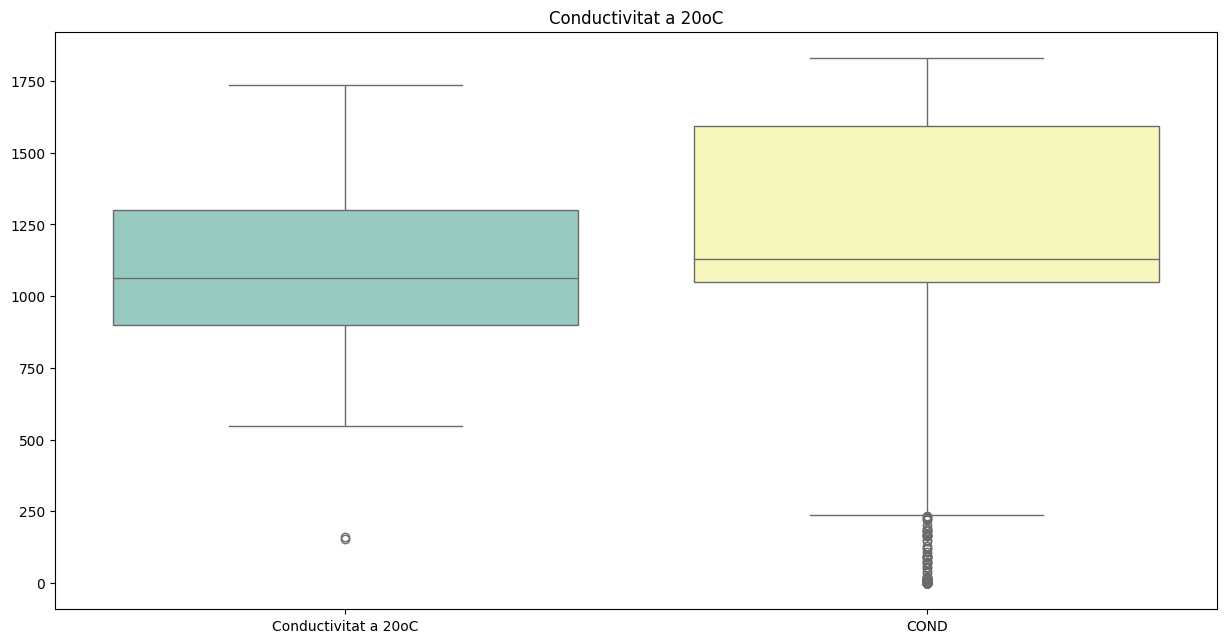

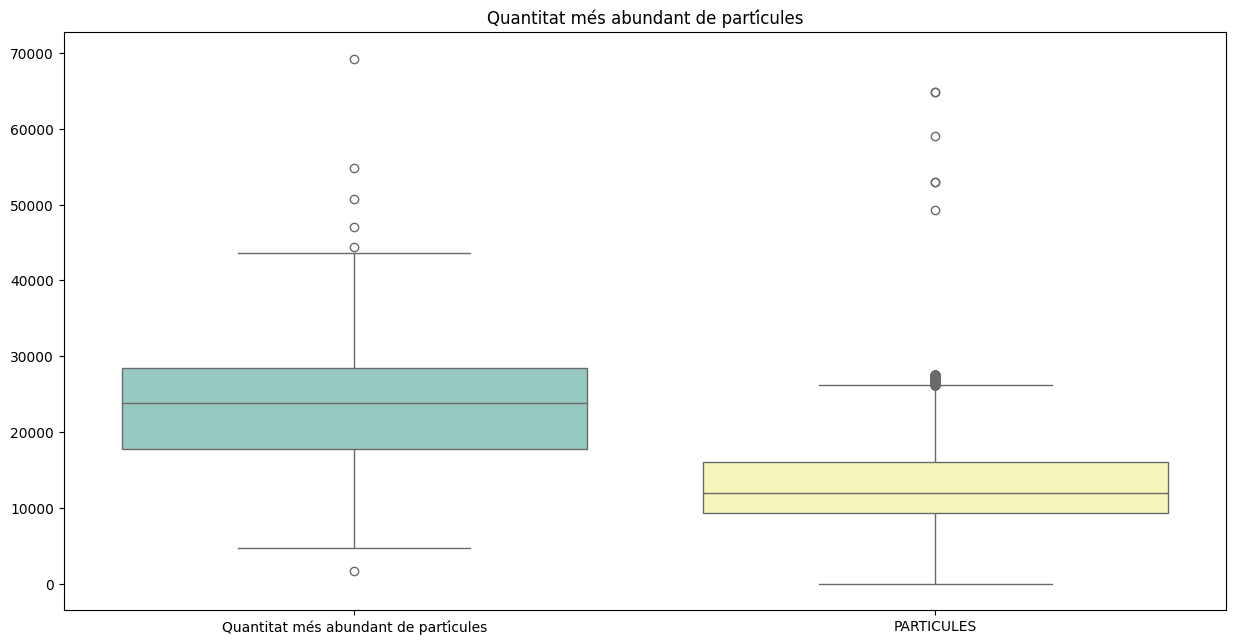

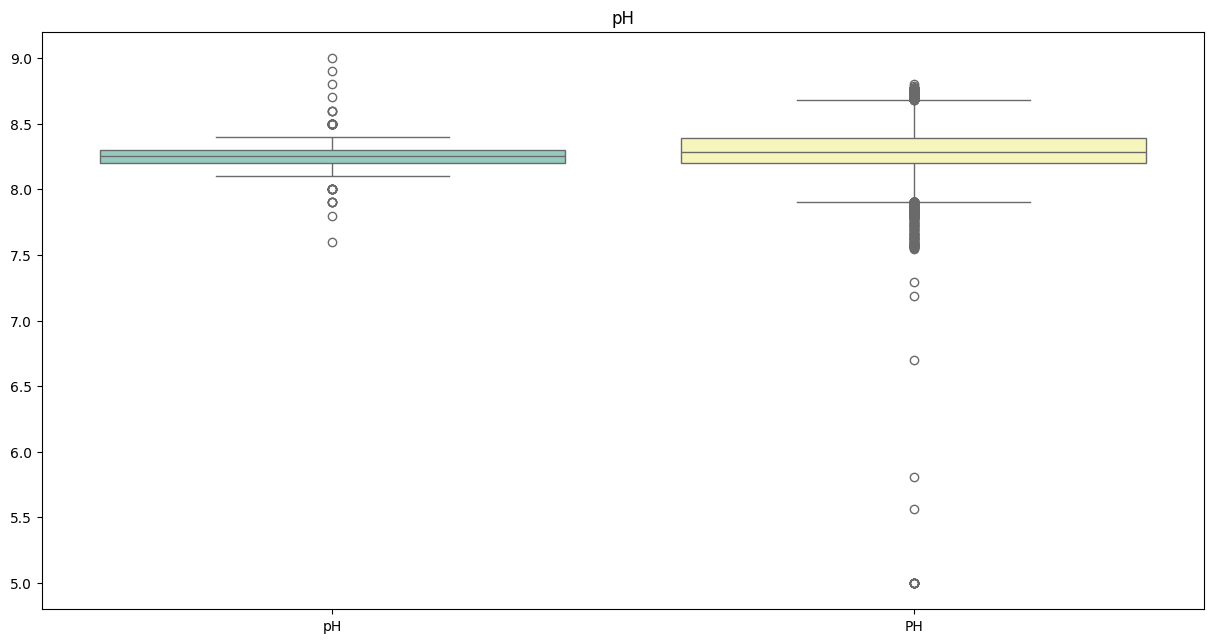

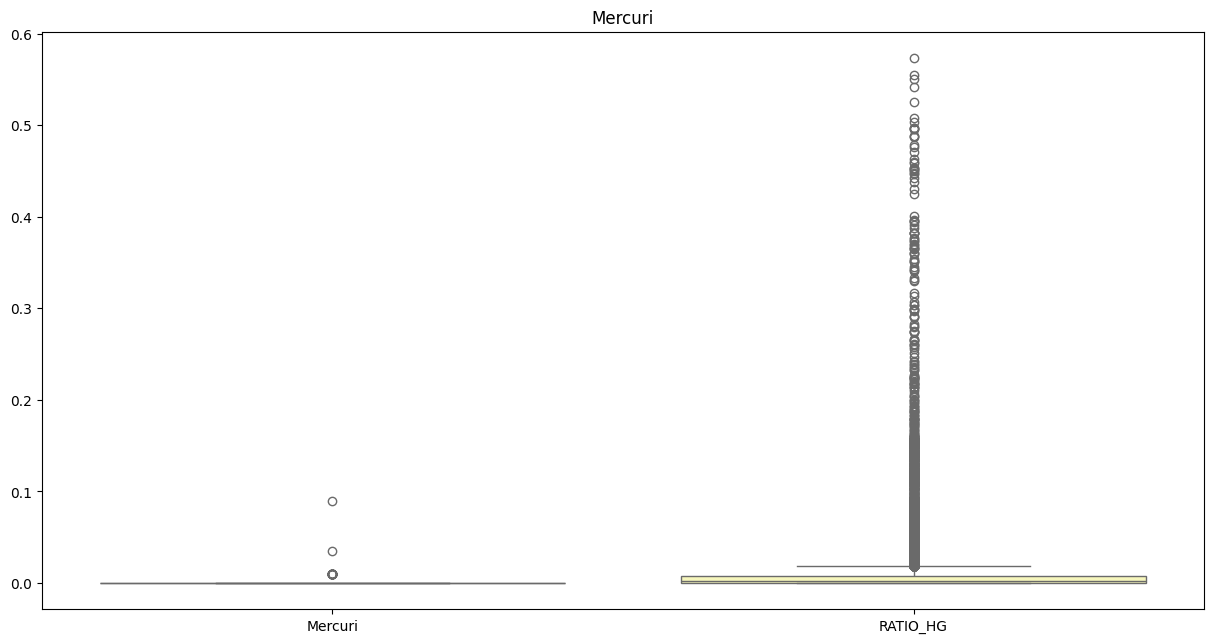

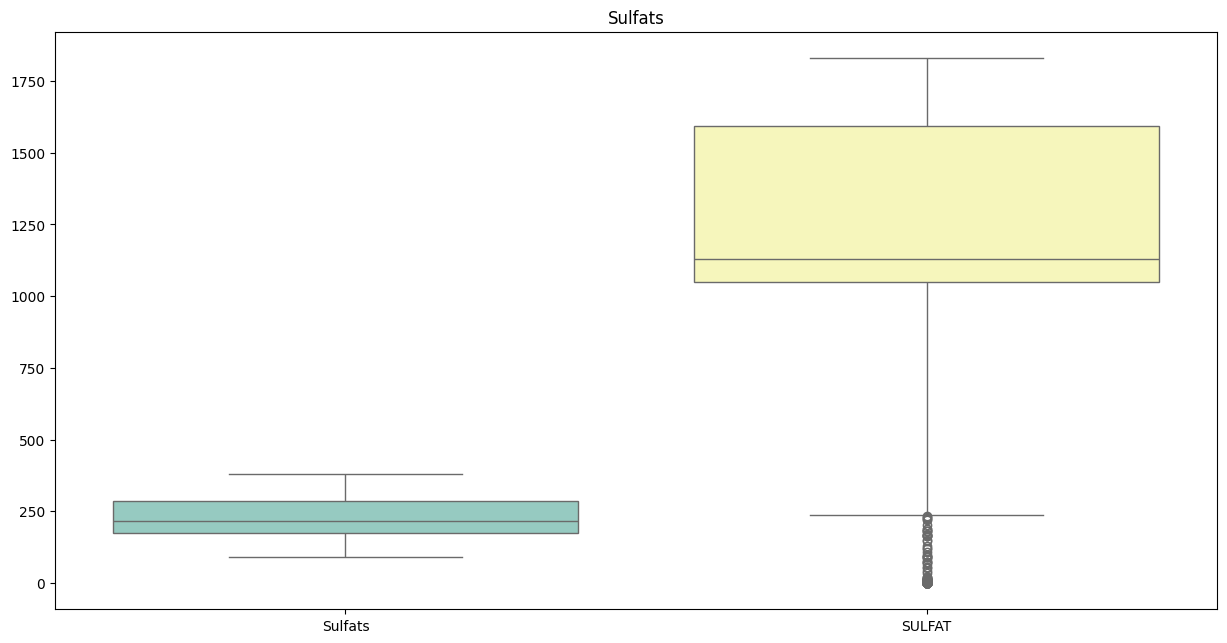

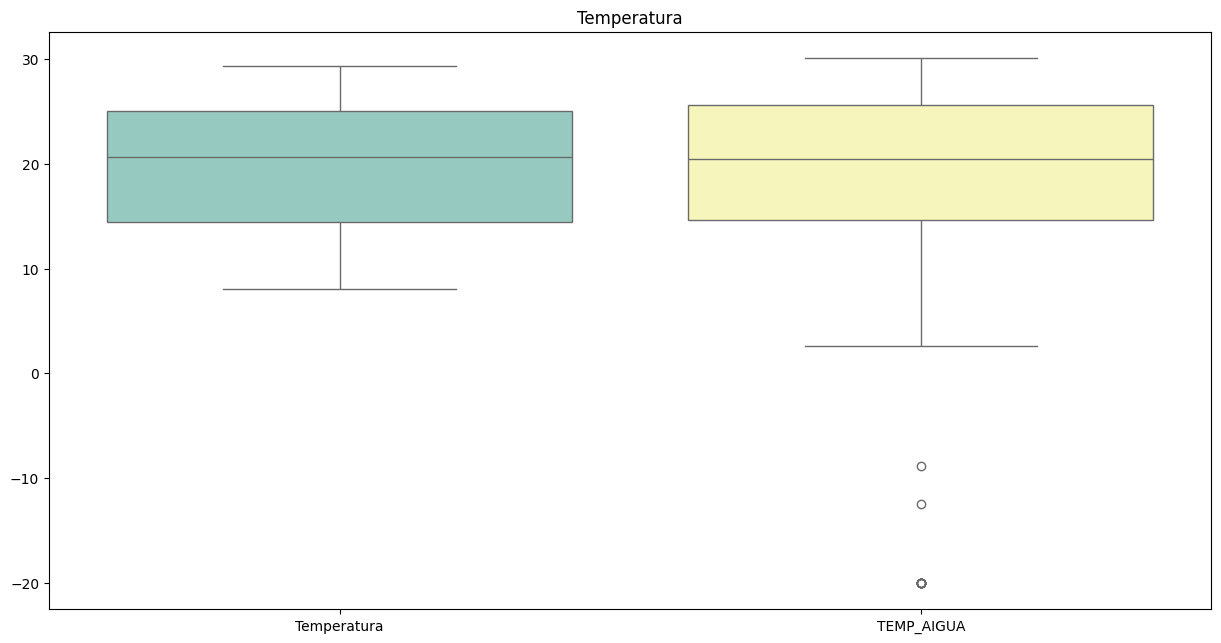

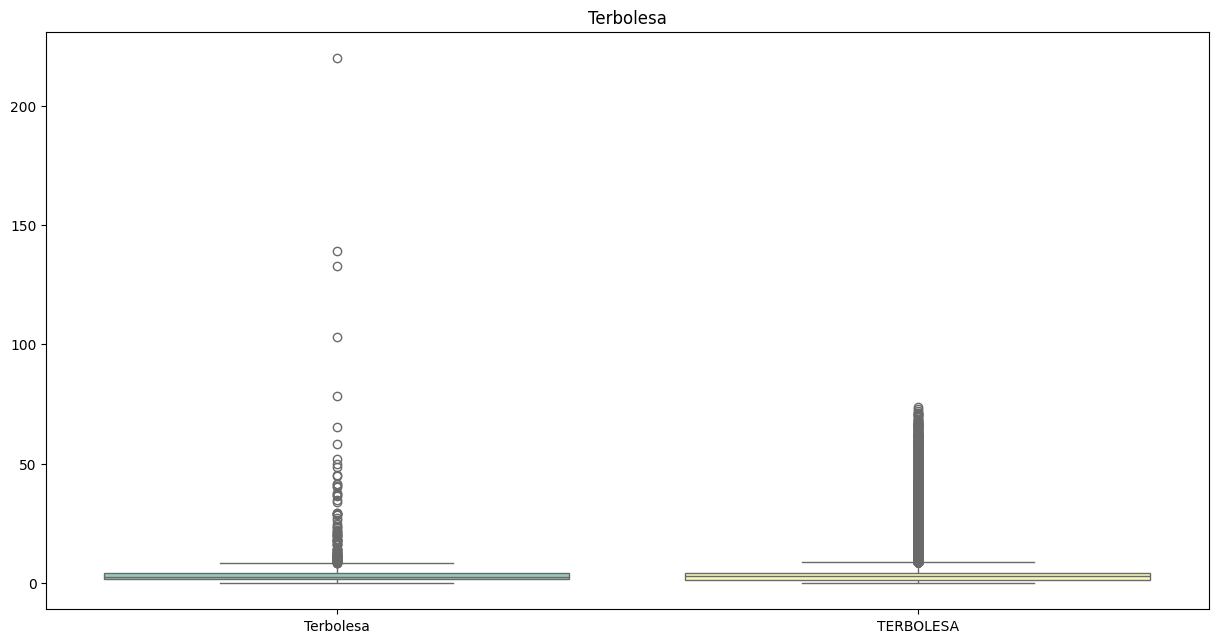

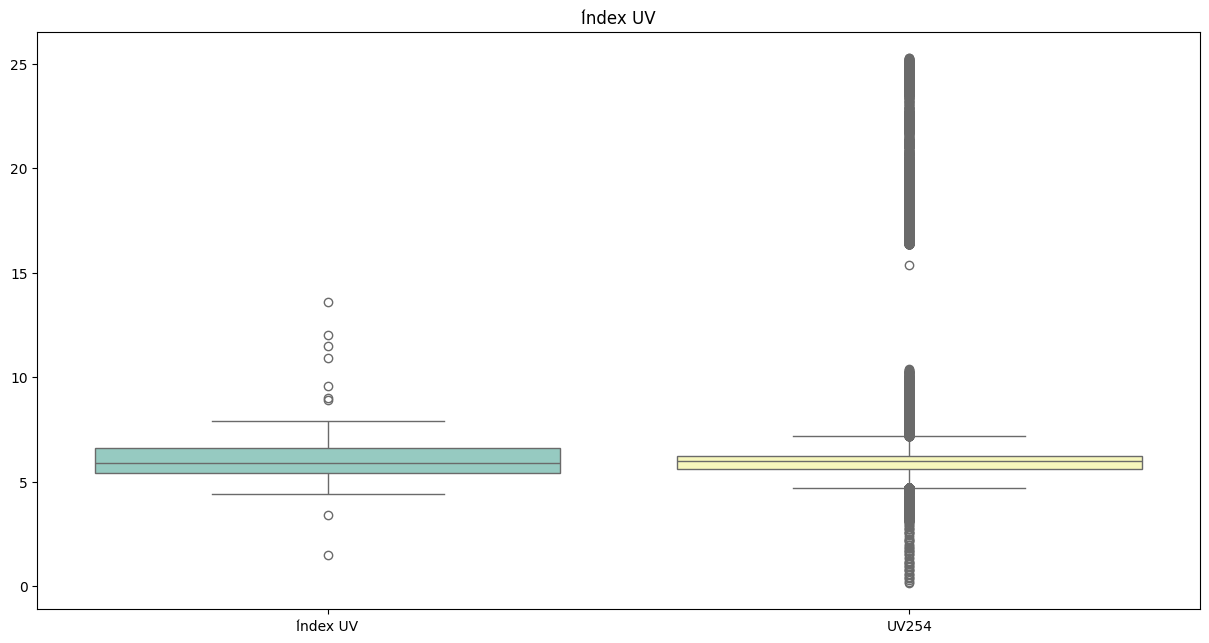

In [11]:
for lab_key, sensor_key in eb0_features_mapping.items():
    lab_key = normalize_string(lab_key)
    lab_df = eb0_features_lab_df[lab_key]
    sensor_df = eb0_sensor_df[sensor_key]

    # remove 0 values from sensor data
    sensor_df = sensor_df[sensor_df != 0]

    if not lab_df.empty and not sensor_df.empty:
        plt.figure(figsize=(15, 7.5))

        sns.boxplot(data=[lab_df, sensor_df], palette="Set3")

        plt.title(lab_key)
        plt.show()

### Time series

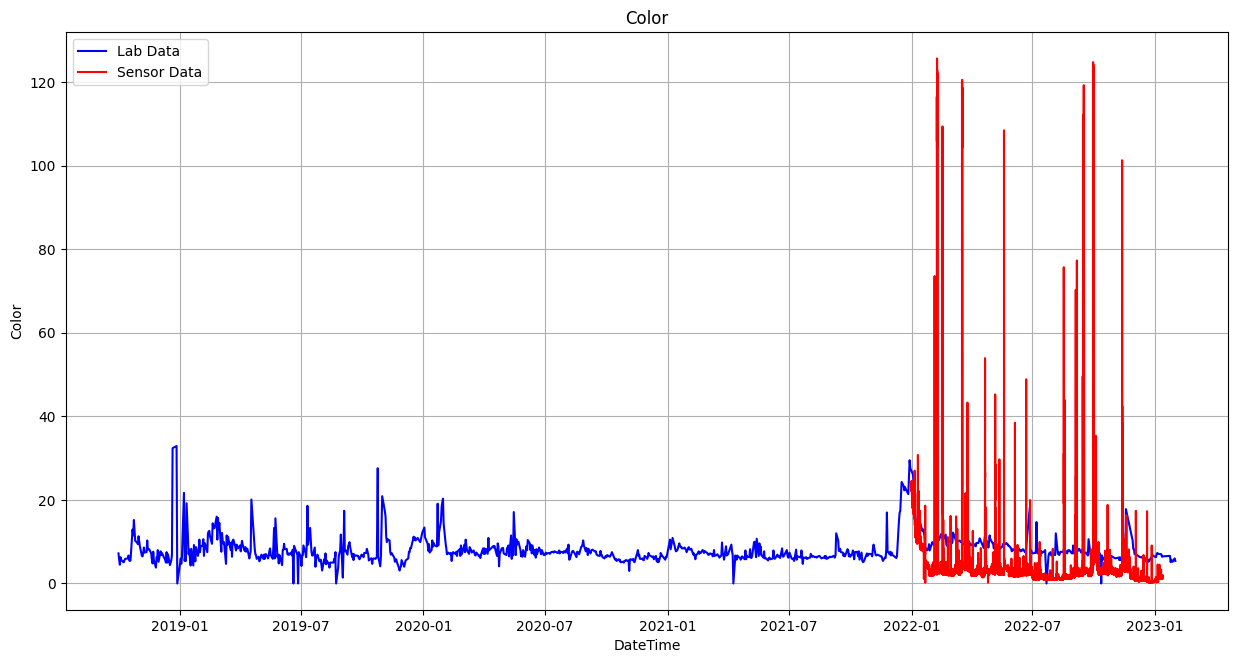

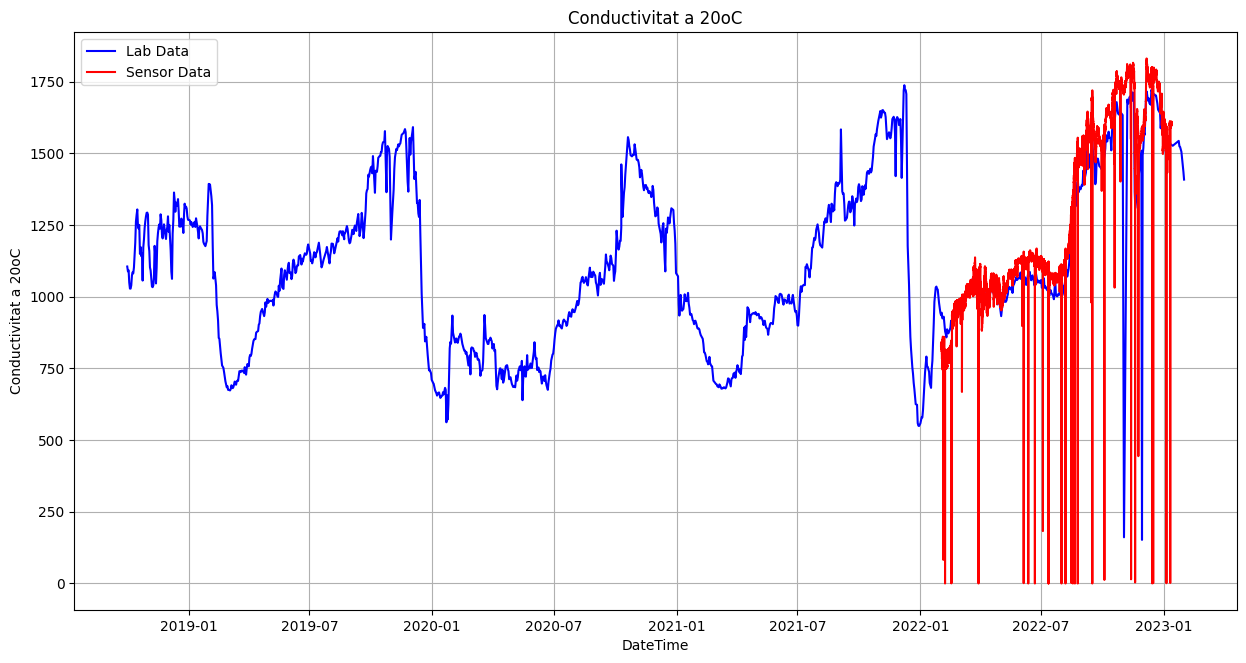

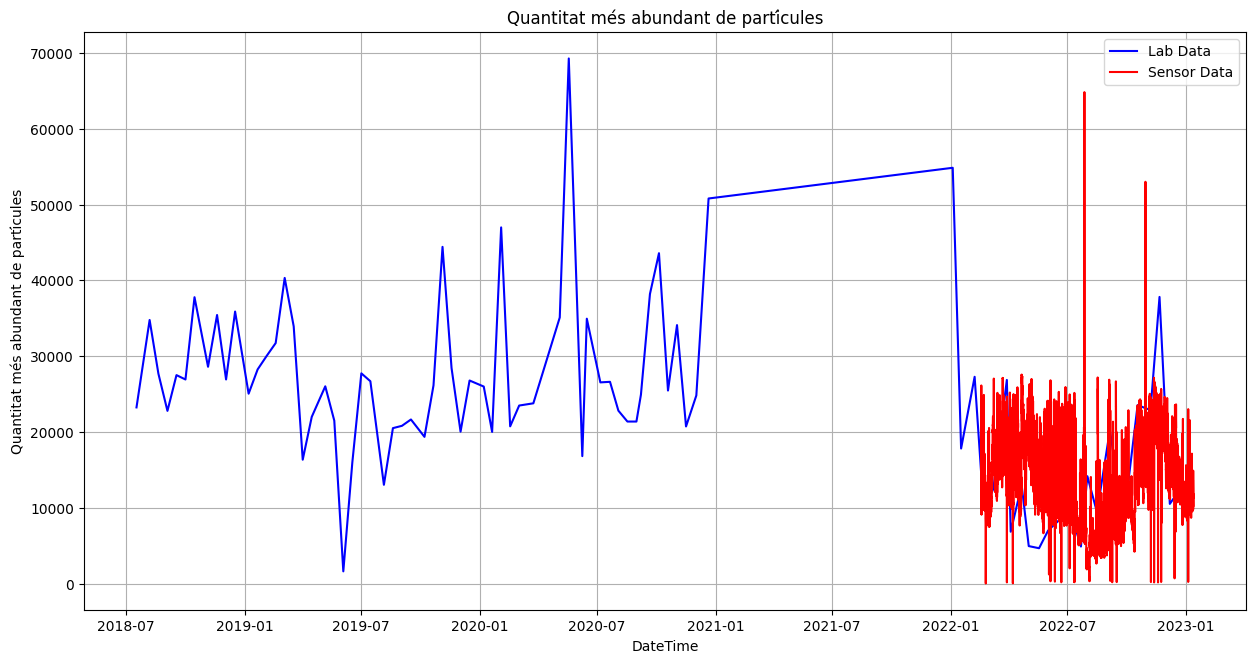

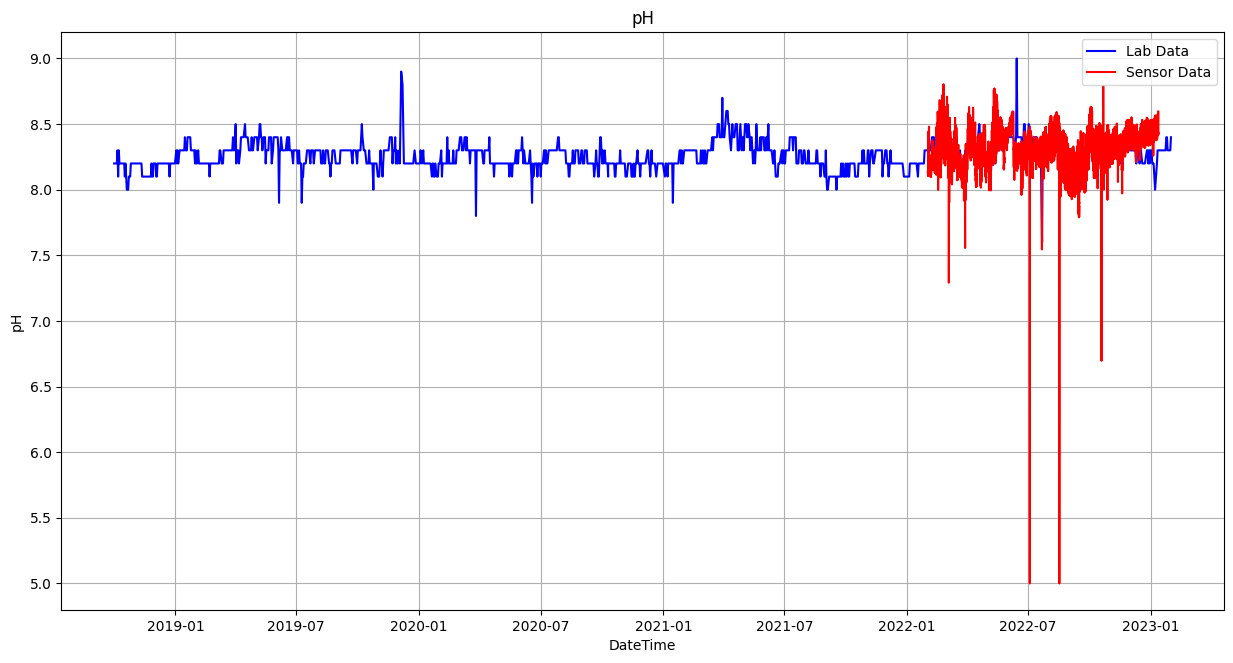

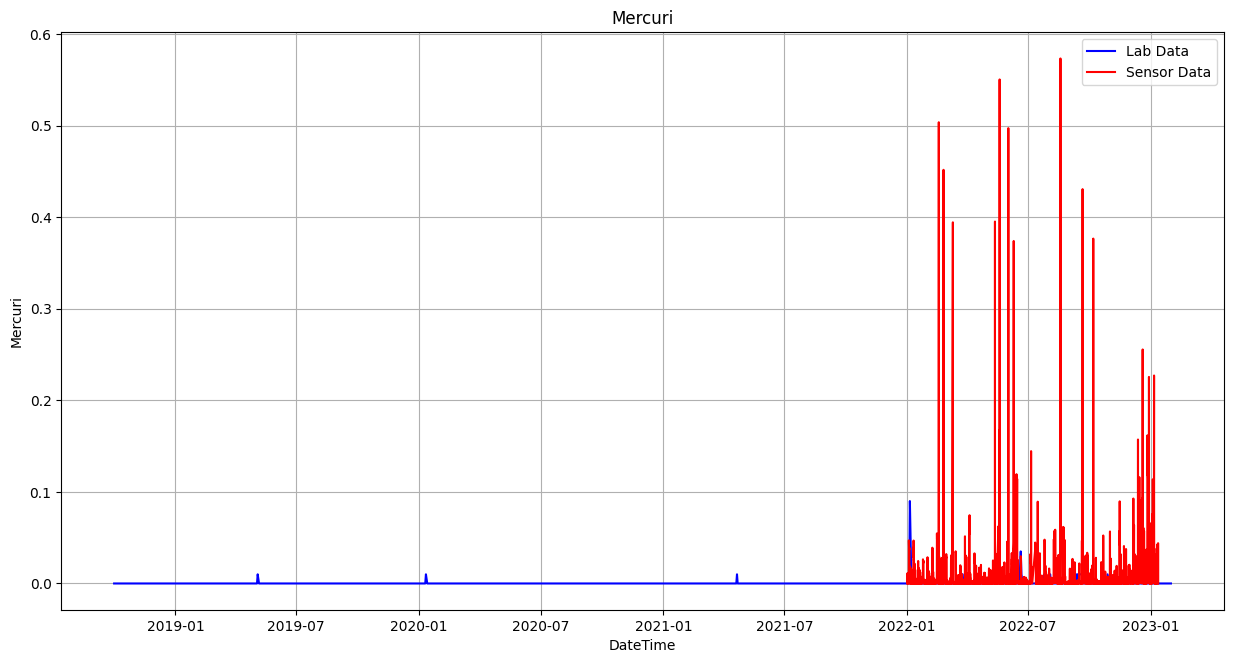

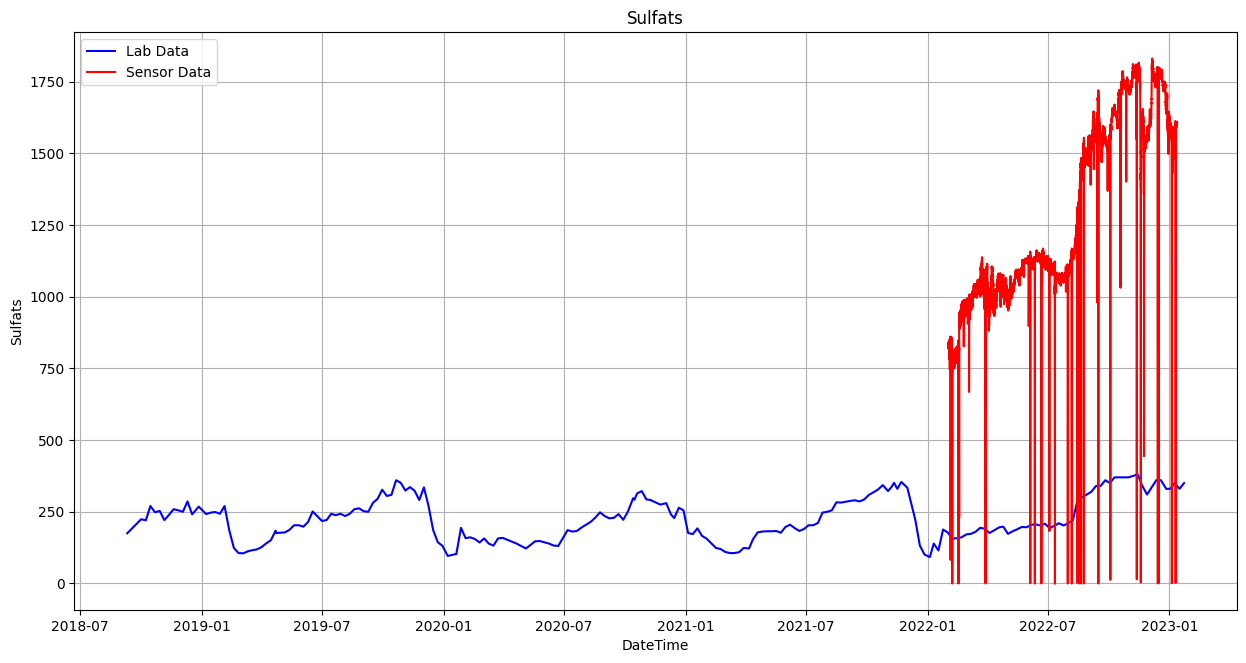

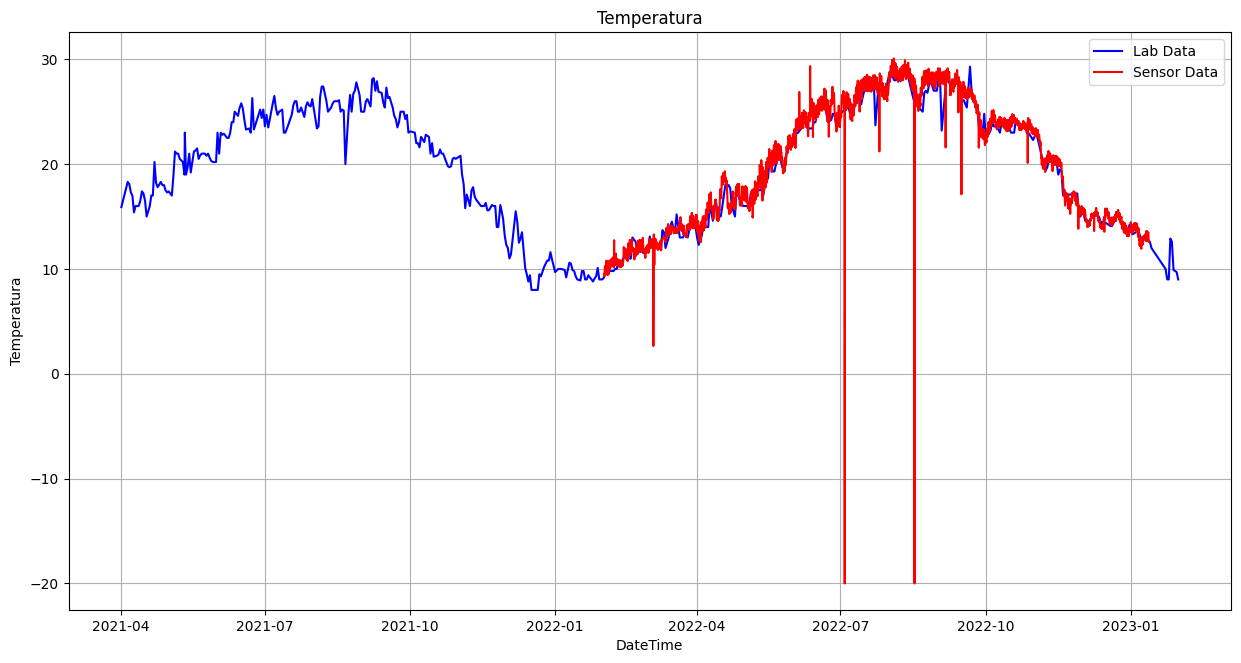

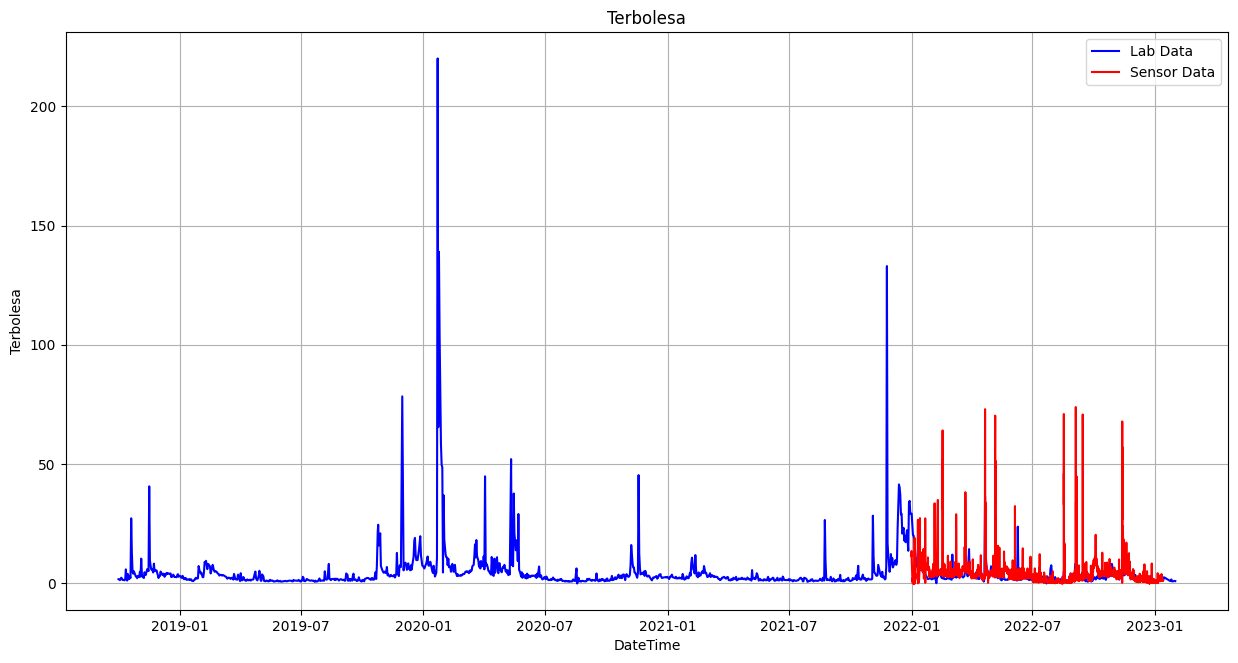

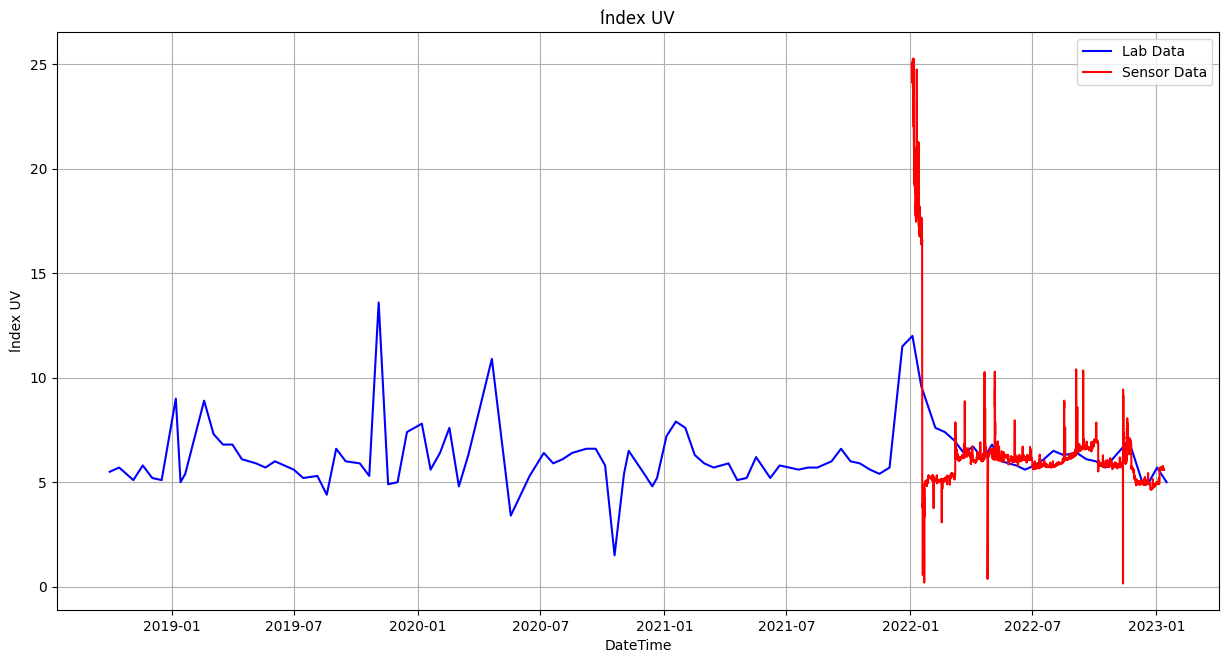

In [12]:
for lab_key, sensor_key in eb0_features_mapping.items():
    lab_key = normalize_string(lab_key)
    lab_df = eb0_features_lab_df[["DateTime", lab_key]]
    sensor_df = eb0_sensor_df[["DateTime", sensor_key]]

    # remove 0 values from sensor data
    sensor_df = sensor_df[sensor_df != 0]

    if not lab_df.empty and not sensor_df.empty:
        plt.figure(figsize=(15, 7.5))

        sns.lineplot(
            x="DateTime",
            y=lab_key,
            data=lab_df,
            color="blue",
            label="Lab Data",
        )

        sns.lineplot(
            x="DateTime",
            y=sensor_key,
            data=sensor_df,
            color="red",
            label="Sensor Data",
        )

        plt.title(lab_key)
        plt.legend()
        plt.grid(True)
        plt.show()

### Retrieve Common Time Range data + Hypothesis Tests

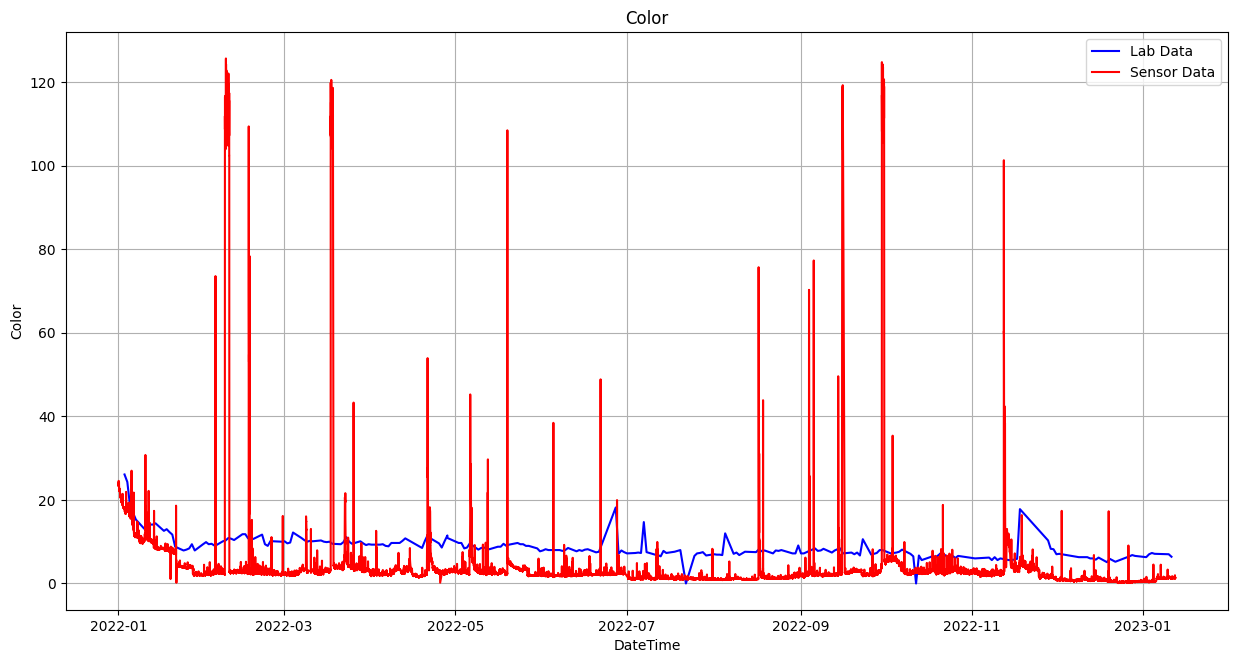

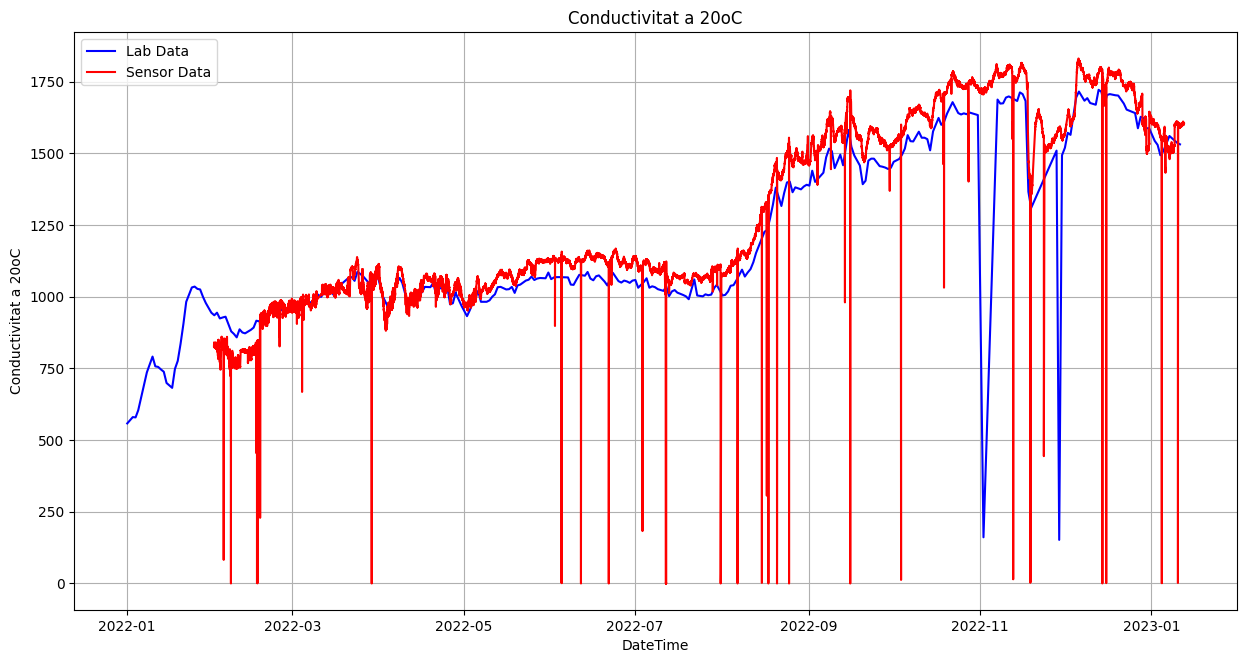

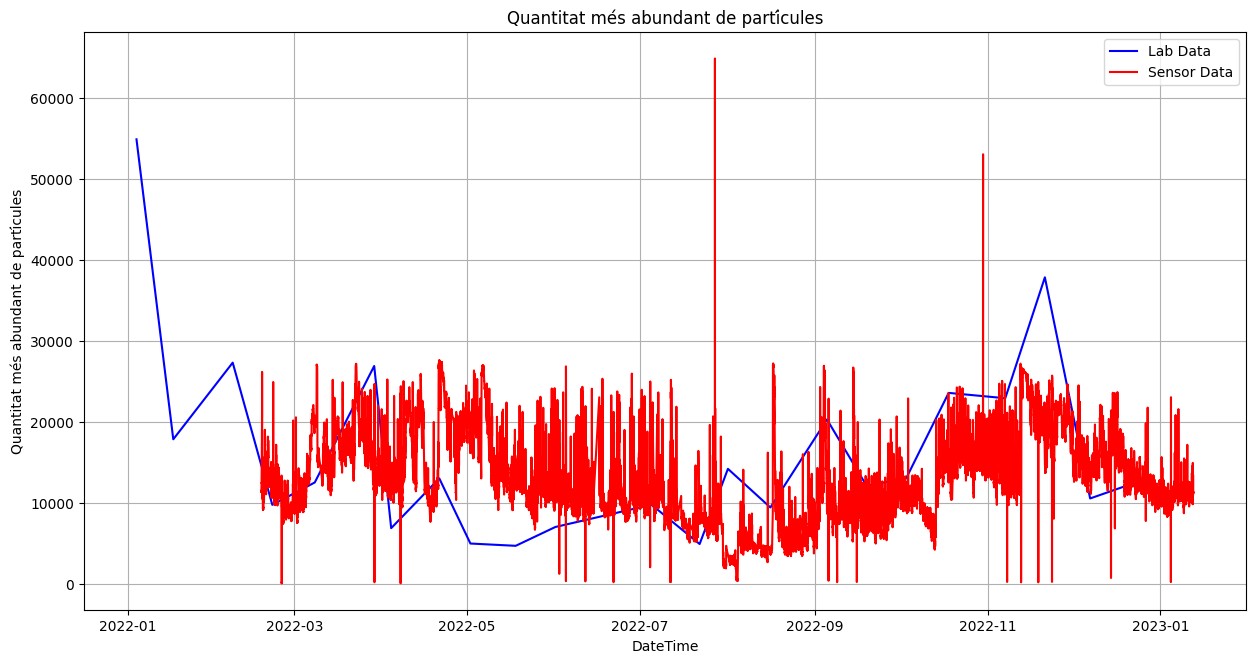

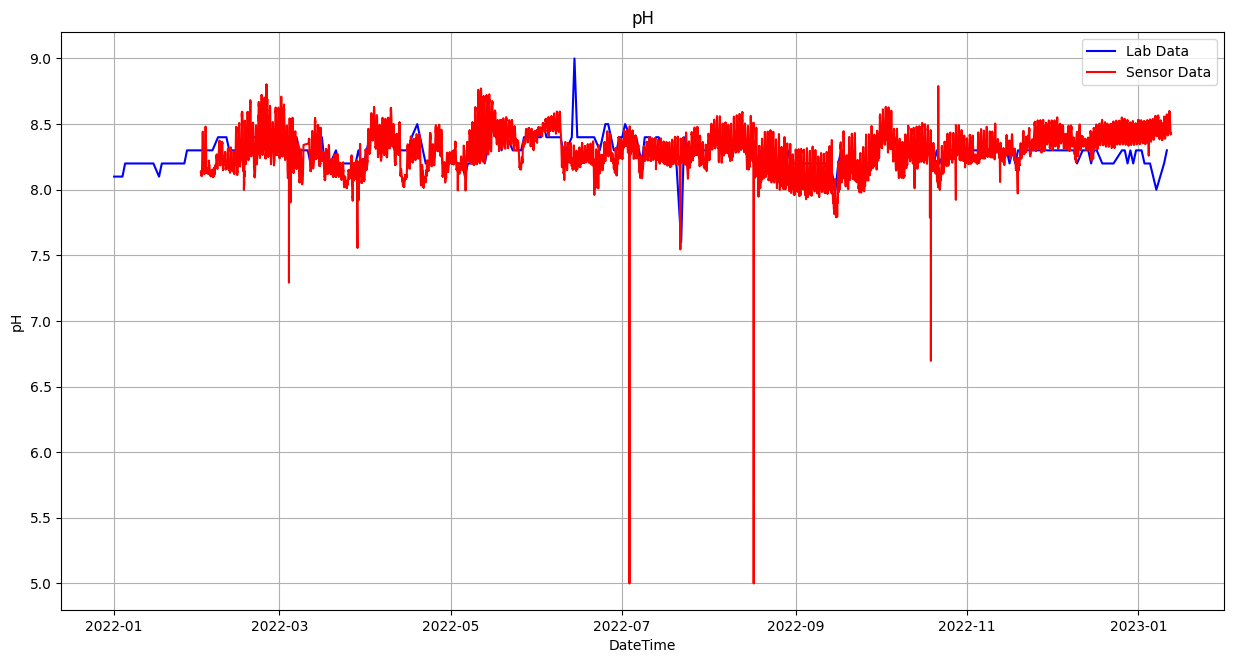

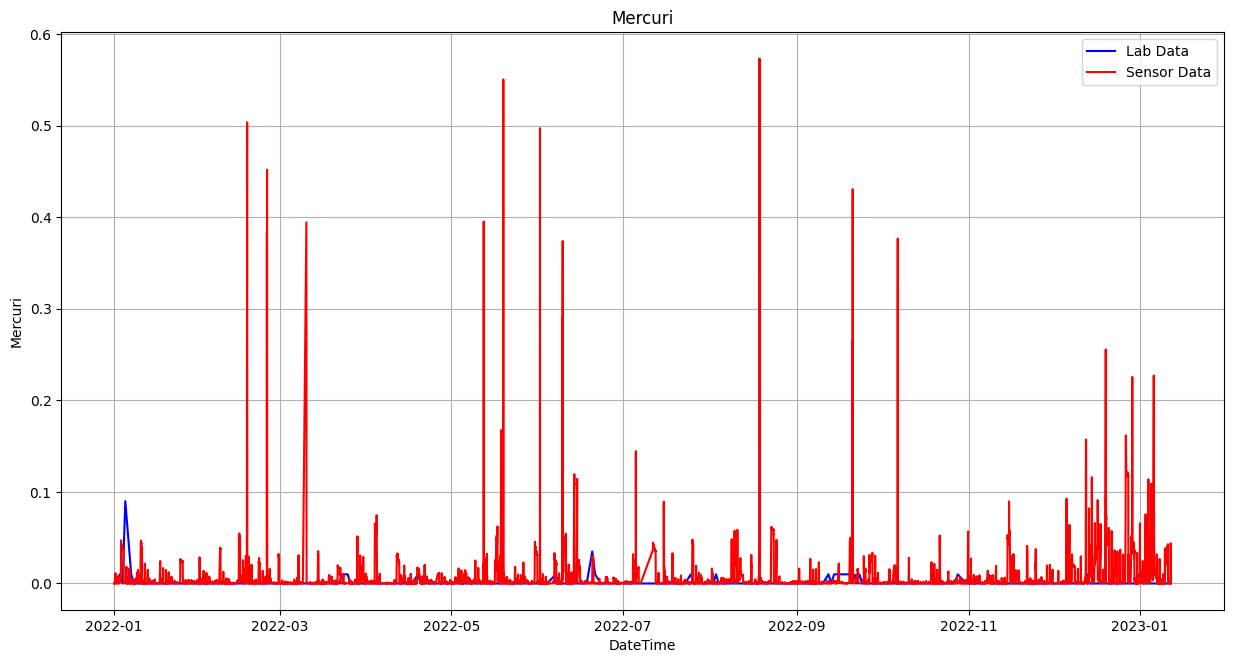

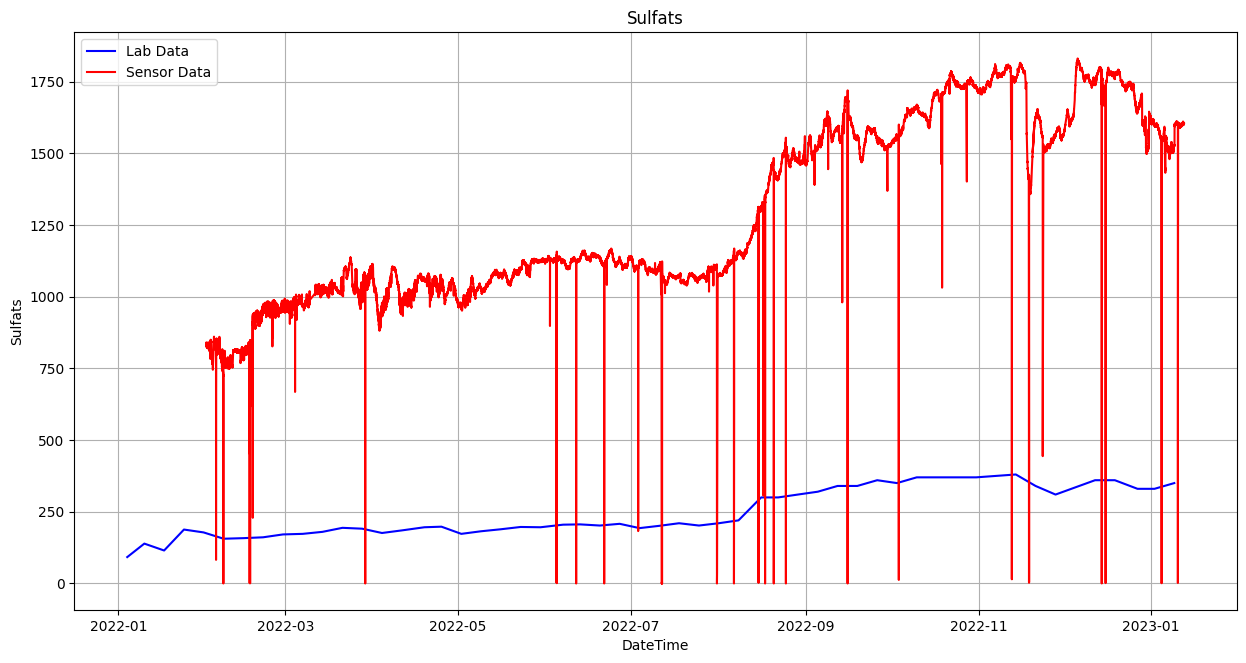

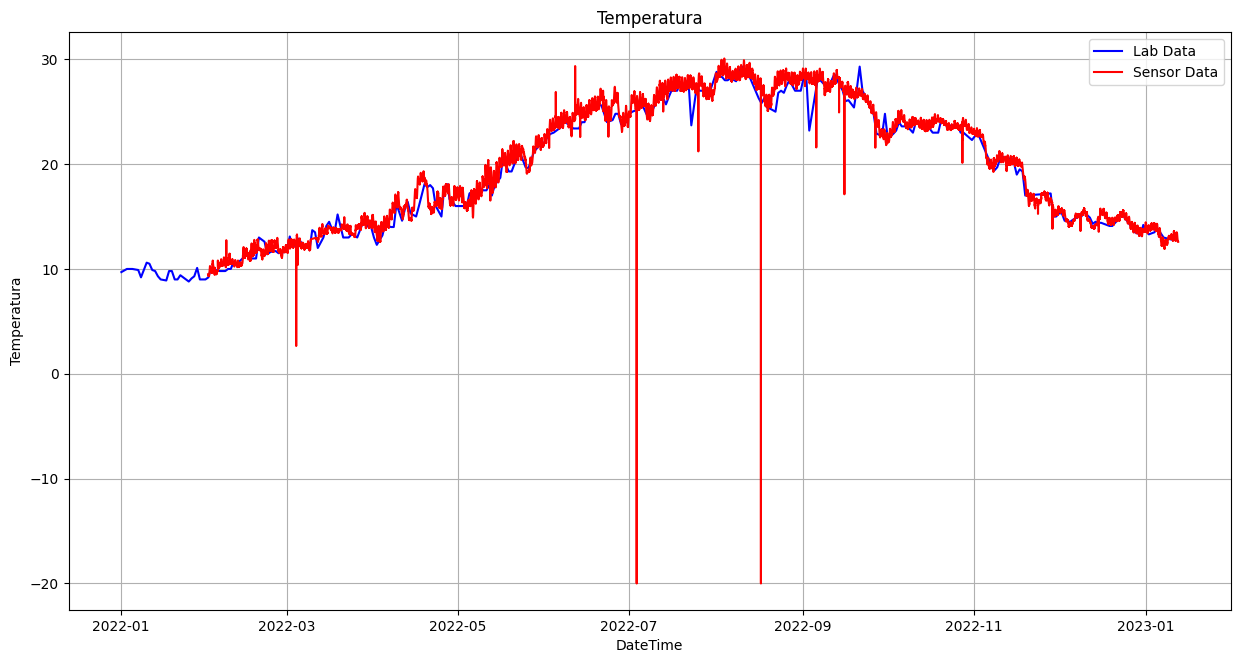

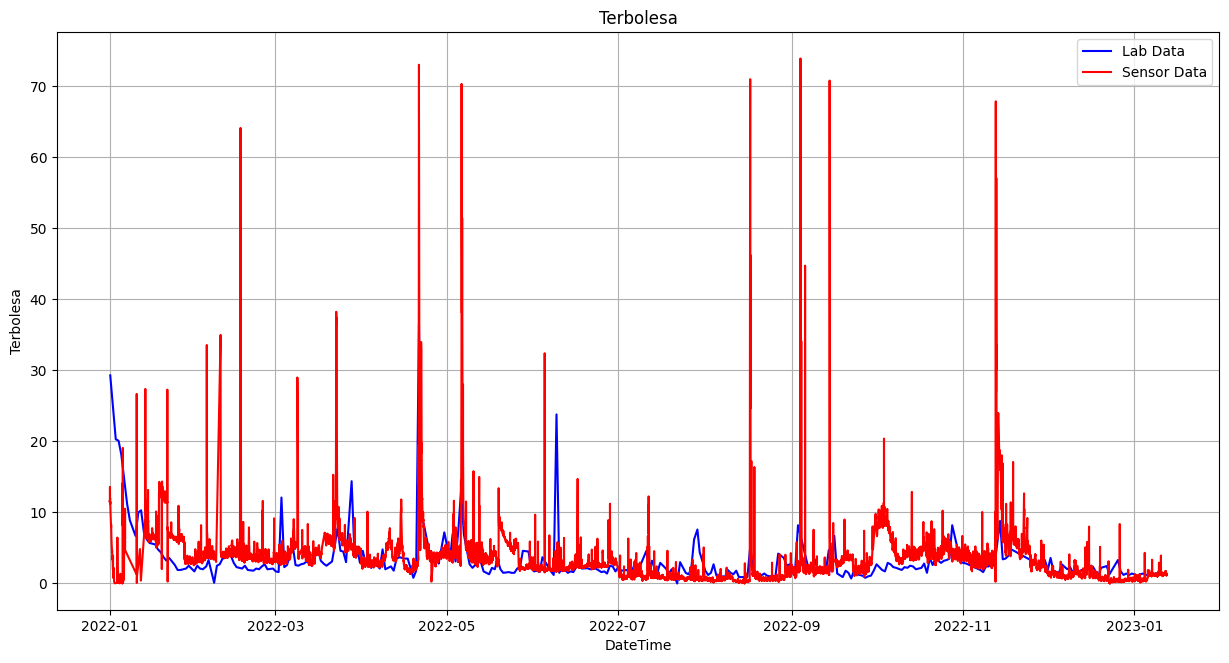

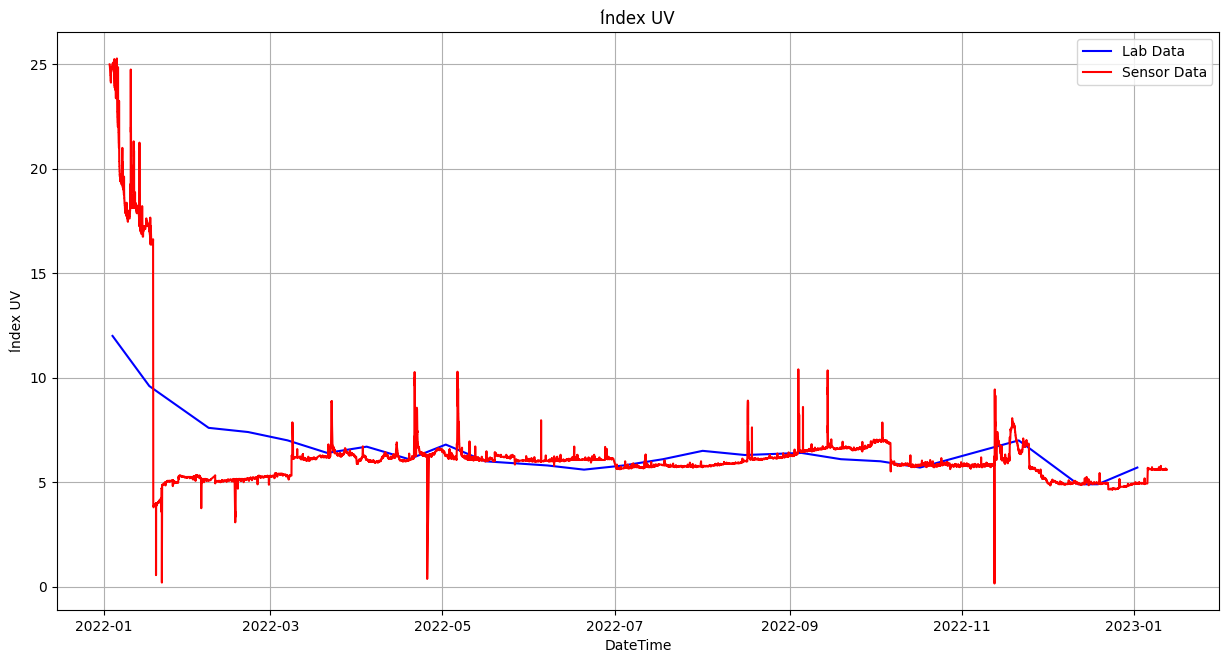

In [13]:
ks_hypothesis_tests = {}
t_hypothesis_tests = {}
u_hypothesis_tests = {}

# get common time range samples for lab and sensor data
for lab_key, sensor_key in eb0_features_mapping.items():
    lab_key = normalize_string(lab_key)
    lab_df = eb0_features_lab_df[["DateTime", lab_key]]
    sensor_df = eb0_sensor_df[["DateTime", sensor_key]]

    # remove 0 values from sensor data
    sensor_df = sensor_df[sensor_df != 0]

    if not lab_df.empty and not sensor_df.empty:
        lab_time_range_df = lab_df[
            (lab_df["DateTime"] >= sensor_df["DateTime"].min())
            & (lab_df["DateTime"] <= sensor_df["DateTime"].max())
        ]

        sensor_time_range_df = sensor_df[
            (sensor_df["DateTime"] >= lab_df["DateTime"].min())
            & (sensor_df["DateTime"] <= lab_df["DateTime"].max())
        ]

        plt.figure(figsize=(15, 7.5))

        sns.lineplot(
            x="DateTime",
            y=lab_key,
            data=lab_time_range_df,
            color="blue",
            label="Lab Data",
        )

        sns.lineplot(
            x="DateTime",
            y=sensor_key,
            data=sensor_time_range_df,
            color="red",
            label="Sensor Data",
        )

        # two sample KS test
        ks_result, ks_p_value = stats.ks_2samp(
            lab_df[lab_key], sensor_df[sensor_key]
        )
        t_result, t_p_value = stats.ttest_ind(
            lab_df[lab_key].dropna(), sensor_df[sensor_key].dropna()
        )
        u_result, u_p_value = stats.mannwhitneyu(
            lab_df[lab_key].dropna(), sensor_df[sensor_key].dropna()
        )

        ks_hypothesis_tests[lab_key] = {
            "ks_test": ks_result,
            "p_value": ks_p_value,
        }

        t_hypothesis_tests[lab_key] = {"t_test": t_result, "p_value": t_p_value}

        u_hypothesis_tests[lab_key] = {"u_test": u_result, "p_value": u_p_value}

        plt.title(lab_key)
        plt.grid(True)
        plt.legend()
        plt.show()

In [14]:
pd.DataFrame(ks_hypothesis_tests).T

ks_test  p_value
Color                                       NaN      NaN
Conductivitat a 20oC                        NaN      NaN
Quantitat més abundant de partícules      NaN      NaN
pH                                          NaN      NaN
Mercuri                                     NaN      NaN
Sulfats                                     NaN      NaN
Temperatura                                 NaN      NaN
Terbolesa                                   NaN      NaN
Índex UV                                   NaN      NaN

In [15]:
pd.DataFrame(t_hypothesis_tests).T

t_test        p_value
Color                                   10.715423   8.886662e-27
Conductivitat a 20oC                   -21.665059  7.607492e-104
Quantitat més abundant de partícules  20.312147   1.601995e-91
pH                                      -7.844450   4.391186e-15
Mercuri                                -13.728802   7.917733e-43
Sulfats                                -50.159701   0.000000e+00
Temperatura                             -2.278200   2.271680e-02
Terbolesa                                8.904384   5.448470e-19
Índex UV                               -0.657002   5.111811e-01

In [16]:
pd.DataFrame(u_hypothesis_tests).T

u_test        p_value
Color                                   101860511.0   0.000000e+00
Conductivitat a 20oC                     42467535.0  6.623713e-100
Quantitat més abundant de partícules    6127622.0   9.743746e-25
pH                                       53975056.0   2.967042e-24
Mercuri                                   1396348.5   0.000000e+00
Sulfats                                     45538.0  2.203650e-143
Temperatura                              24843559.0   1.100535e-02
Terbolesa                                70296559.0   8.794909e-01
Índex UV                                 5530203.0   6.553962e-01

### Distributions Divergence

In [17]:
kl_divs = {}
js_divs = {}
tv_dists = {}
w_dists = {}

for lab_key, sensor_key in eb0_features_mapping.items():
    # Compute the probability distribution of the feature in each DataFrame
    lab_df = eb0_features_lab_df[lab_key]
    sensor_df = eb0_sensor_df[sensor_key]

    lab_pdist = np.histogram(lab_df.dropna(), bins=100, density=True)[0]
    sensor_pdist = np.histogram(sensor_df.dropna(), bins=100, density=True)[0]

    # Add a small constant to avoid division by zero
    lab_pdist = lab_pdist + np.finfo(np.float64).eps
    sensor_pdist = sensor_pdist + np.finfo(np.float64).eps

    # Compute divergence metrics
    kl_div = stats.entropy(lab_pdist, sensor_pdist)
    js_div = jensenshannon(lab_pdist, sensor_pdist)
    tv_dist = np.sum(np.abs(lab_pdist - sensor_pdist)) / 2
    w_dist = wasserstein_distance(lab_pdist, sensor_pdist)

    kl_divs[lab_key] = kl_div
    js_divs[lab_key] = js_div
    tv_dists[lab_key] = tv_dist
    w_dists[lab_key] = w_dist


kl_divs = pd.Series(kl_divs)
js_divs = pd.Series(js_divs)
tv_dists = pd.Series(tv_dists)
w_dists = pd.Series(w_dists)

In [18]:
kl_divs

Color                                      4.983642
Conductivitat a 20oC                       1.505864
Quantitat més abundant de partícules     6.259487
pH                                        36.980509
Mercuri                                    0.215921
Sulfats                                    3.119629
Temperatura                               14.515220
Terbolesa                                  0.609899
Índex UV                                 10.294344
dtype: float64

In [19]:
js_divs

Color                                     0.797124
Conductivitat a 20oC                      0.447123
Quantitat més abundant de partícules    0.570432
pH                                        0.829355
Mercuri                                   0.248761
Sulfats                                   0.596587
Temperatura                               0.536685
Terbolesa                                 0.398156
Índex UV                                 0.780573
dtype: float64

In [20]:
tv_dists

Color                                       1.871335
Conductivitat a 20oC                        0.027198
Quantitat més abundant de partícules      0.000962
pH                                         41.269375
Mercuri                                   495.076089
Sulfats                                     0.165465
Temperatura                                 2.070115
Terbolesa                                   0.456851
Índex UV                                   5.801940
dtype: float64

In [21]:
w_dists

Color                                     0.022467
Conductivitat a 20oC                      0.000290
Quantitat més abundant de partícules    0.000004
pH                                        0.627454
Mercuri                                   9.734326
Sulfats                                   0.002926
Temperatura                               0.027216
Terbolesa                                 0.009119
Índex UV                                 0.053489
dtype: float64

## EB1

In [22]:
eb1_features_lab_df.columns = [
    normalize_string(c) for c in eb1_features_lab_df.columns
]

eb1_features_mapping = {
    normalize_string(k): v for k, v in eb1_features_mapping.items()
}

### Histograms

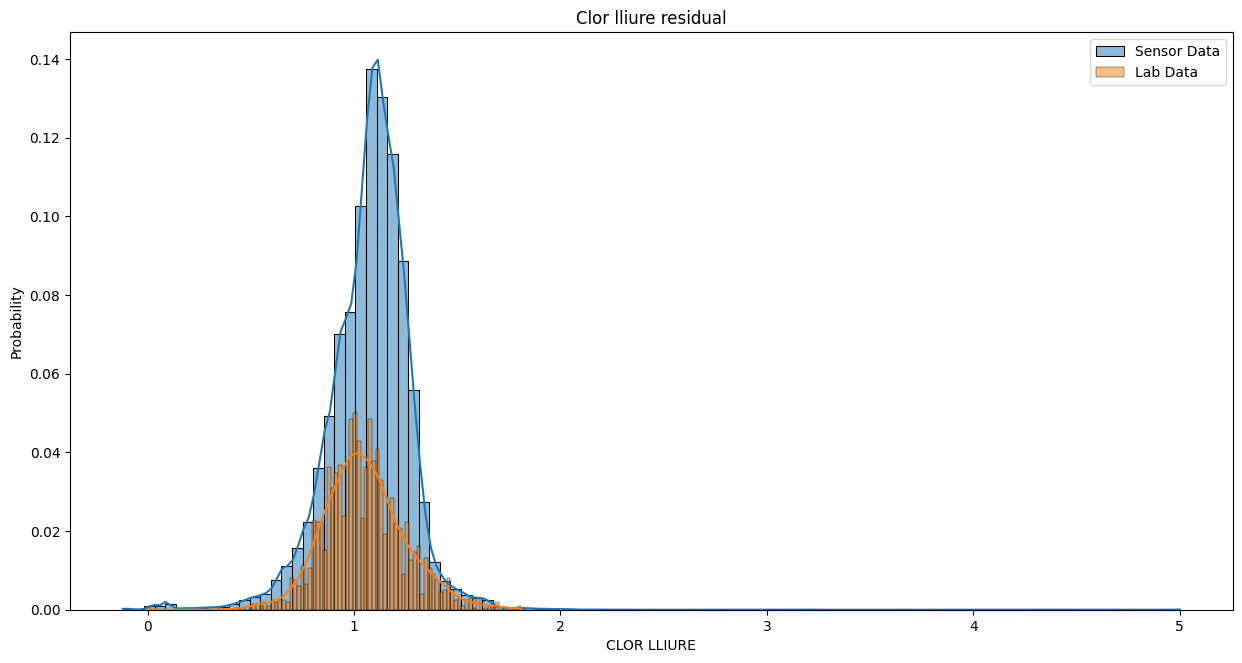

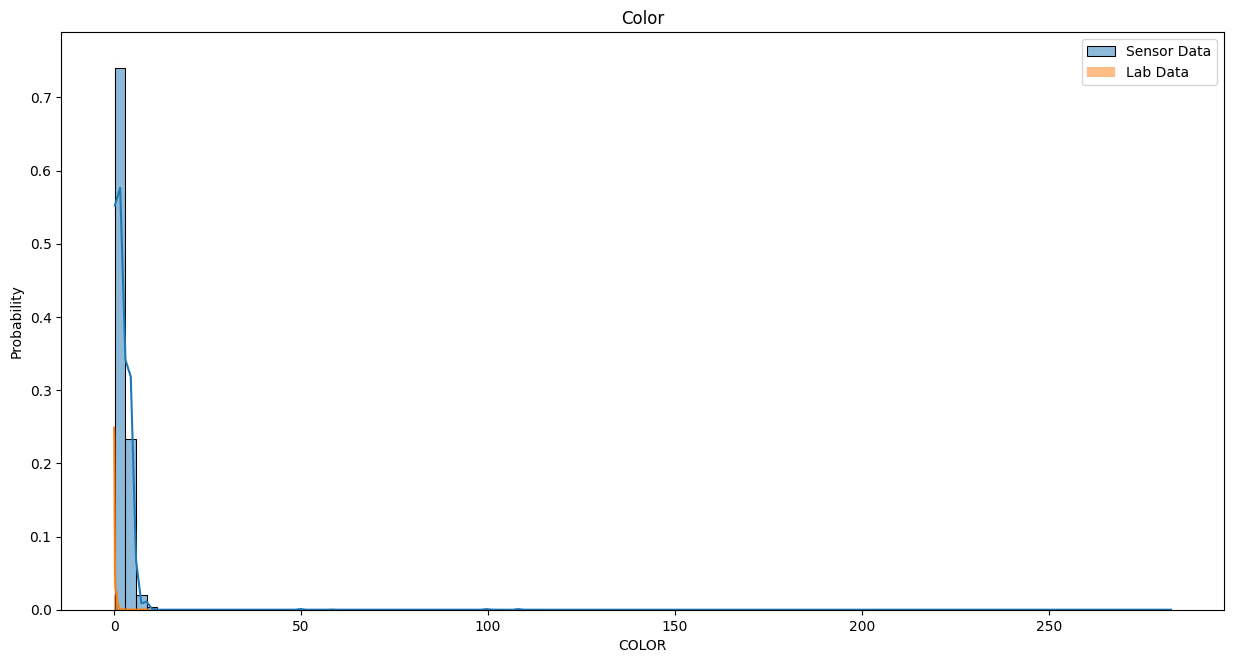

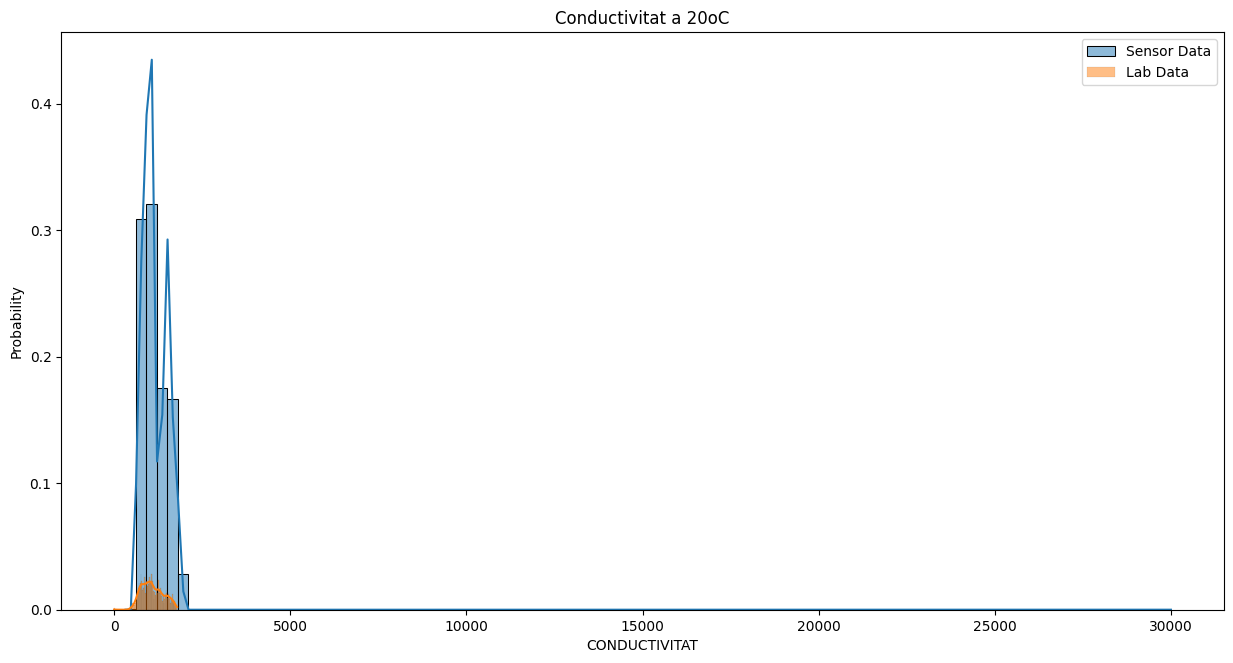

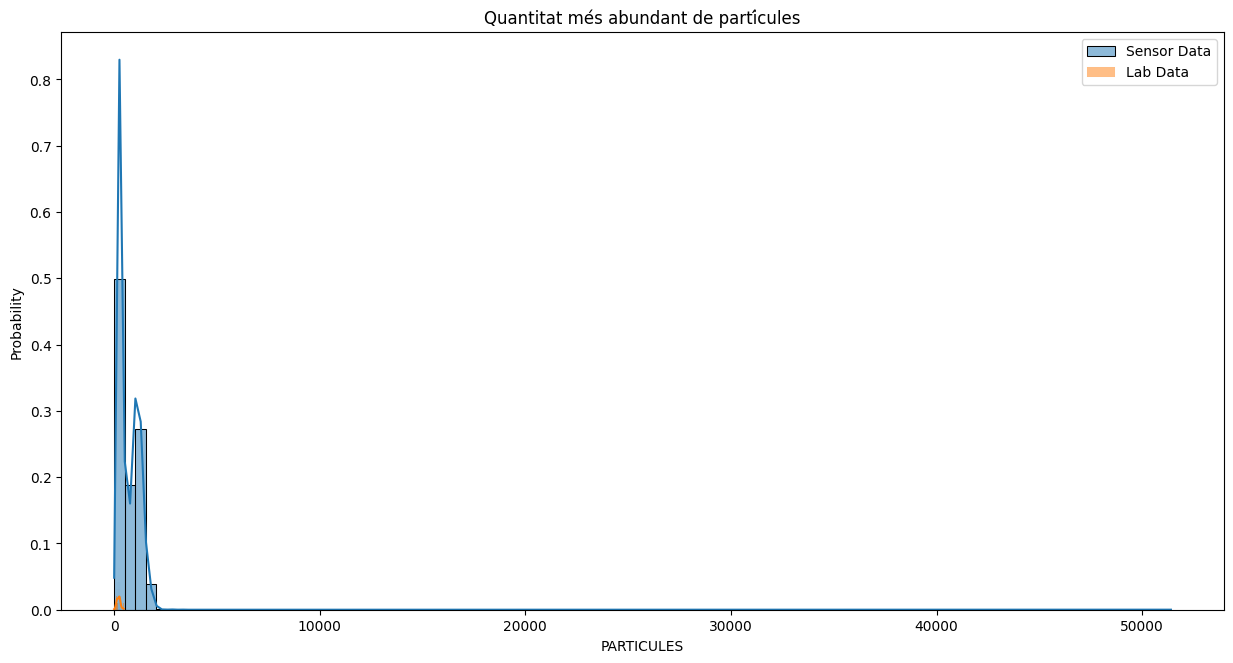

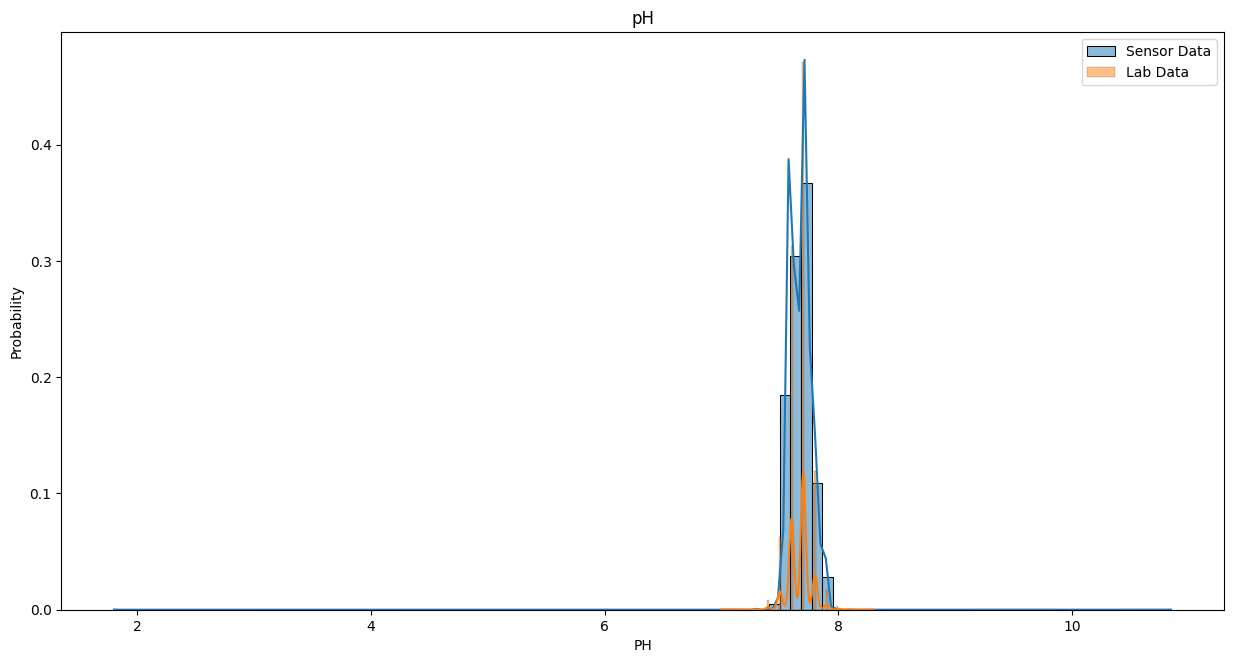

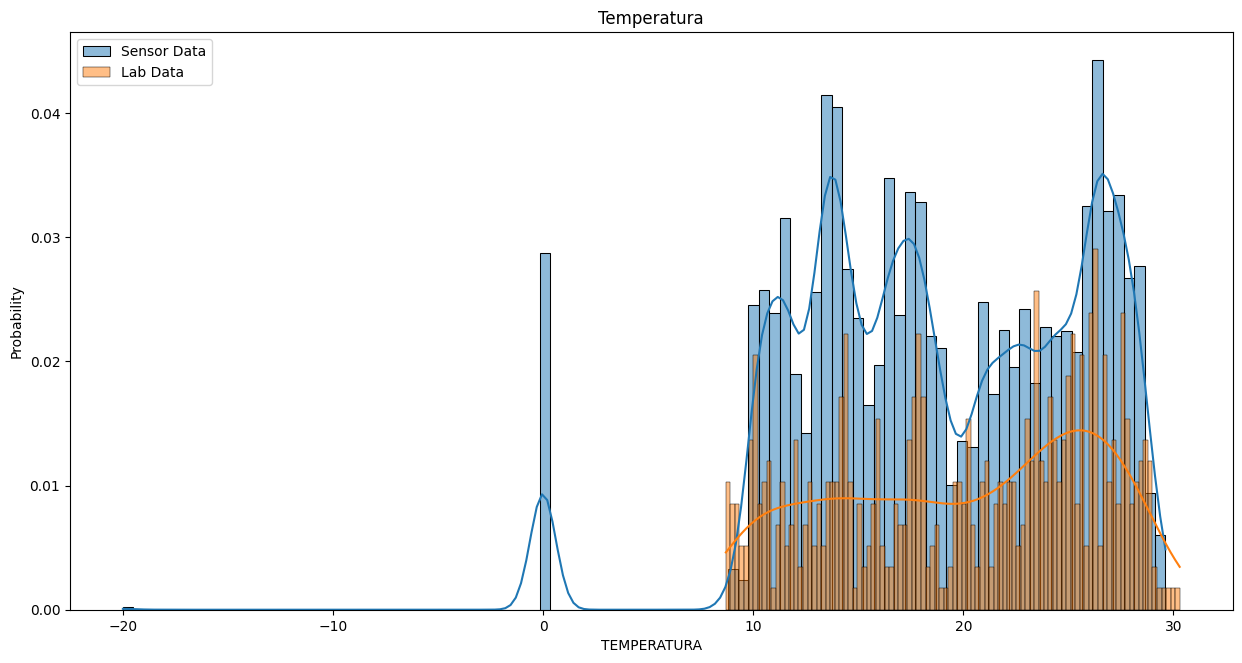

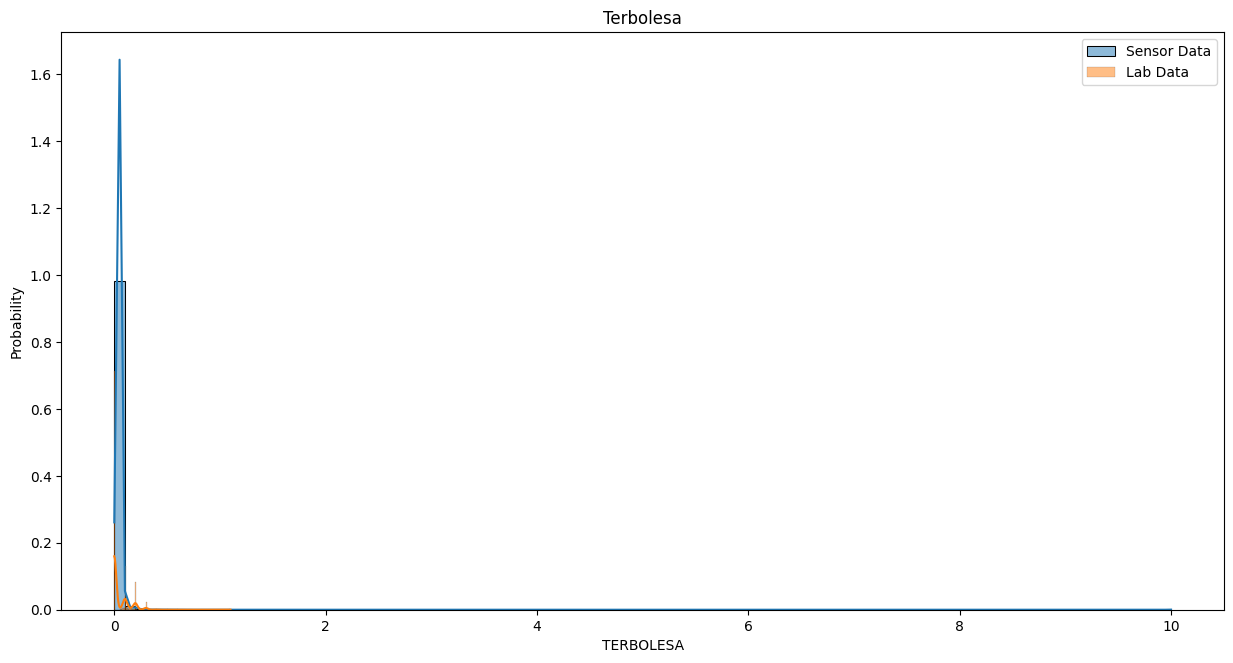

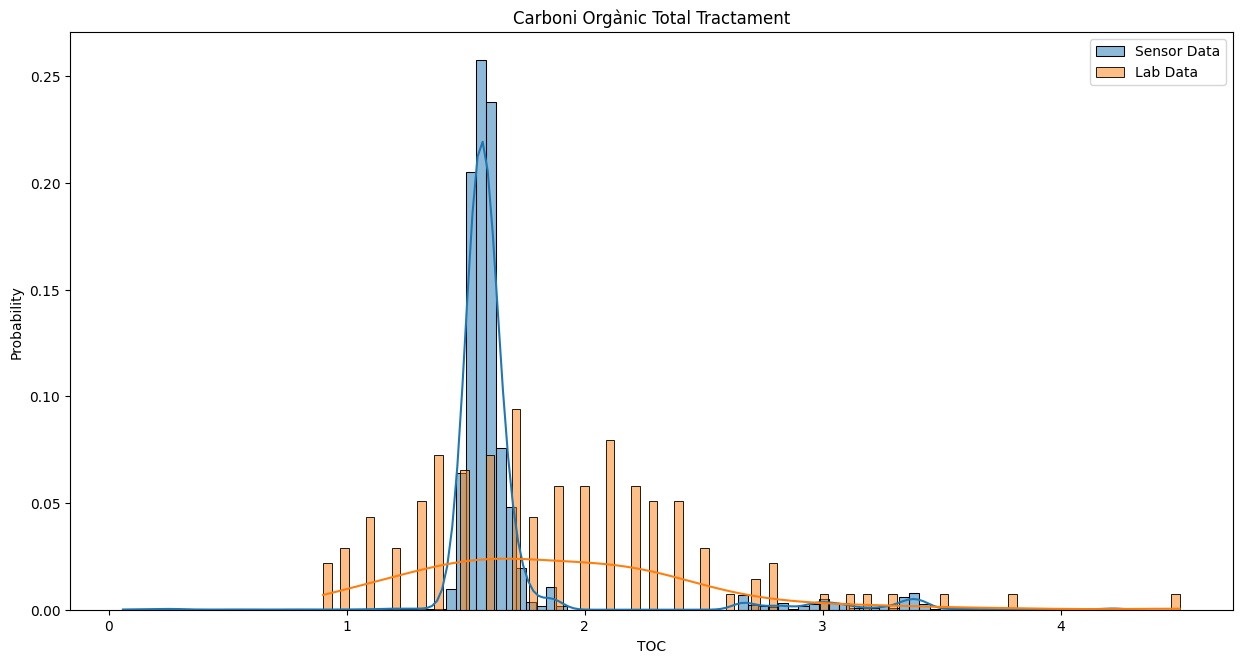

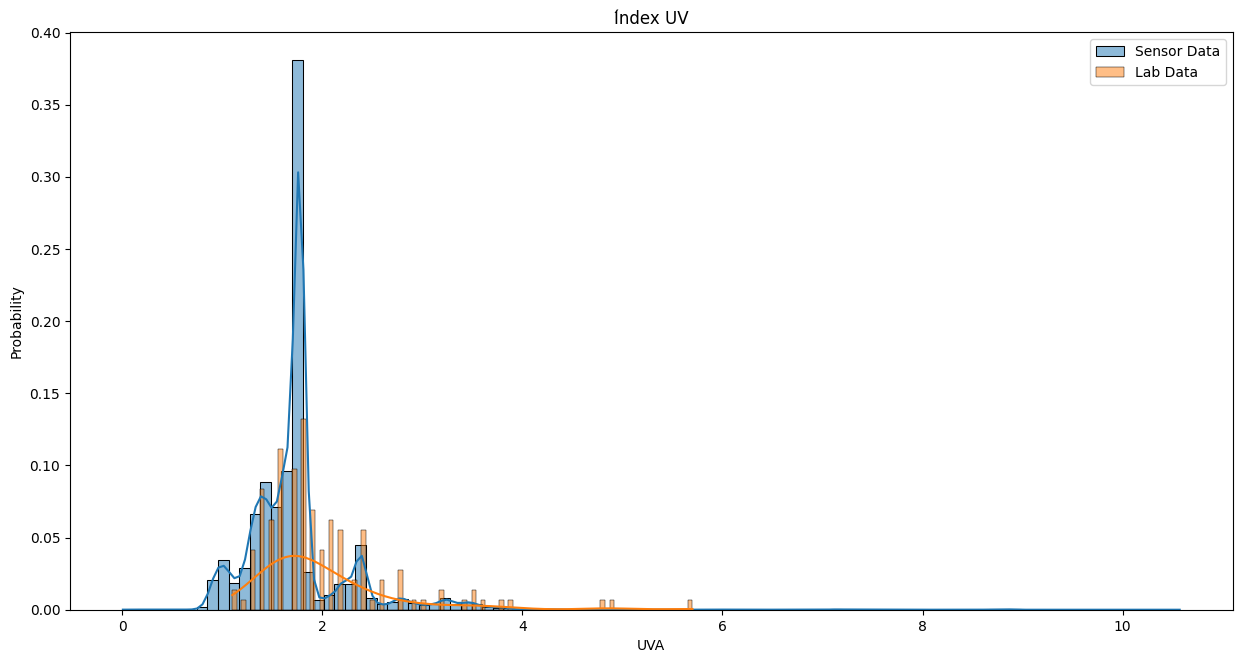

In [23]:
for lab_key, sensor_key in eb1_features_mapping.items():
    lab_key = normalize_string(lab_key)
    lab_df = eb1_features_lab_df[lab_key]
    sensor_df = eb1_sensor_df[sensor_key]

    # remove 0 values from sensor data
    sensor_df = sensor_df[sensor_df != 0]

    if not lab_df.empty and not sensor_df.empty:
        plt.figure(figsize=(15, 7.5))

        # counts, bins, patches = plt.hist(
        #     lab_df,
        #     bins=100,
        #     color="blue",
        #     alpha=0.5,
        #     label="Lab",
        #     density=True,
        # )
        # # # Add counts as annotations
        # # for count, bin in zip(counts, bins):
        # #     plt.text(bin, count, str(int(count)))

        # plt.hist(
        #     sensor_df,
        #     bins=100,
        #     color="red",
        #     alpha=0.5,
        #     label="Sensor",
        #     density=True,
        # )

        sns.histplot(
            data=sensor_df,
            kde=True,
            bins=100,
            alpha=0.5,
            stat="probability",
            label="Sensor Data",
        )

        sns.histplot(
            data=lab_df,
            kde=True,
            bins=100,
            stat="probability",
            label="Lab Data",
        )

        plt.title(lab_key)
        plt.legend()
        plt.show()

        # The y-axis of a histplot with stat="probability" corresponds
        # to the probability that a value belongs to a certain bar.
        # The sum of the bar heights must be 1.

### Boxplots

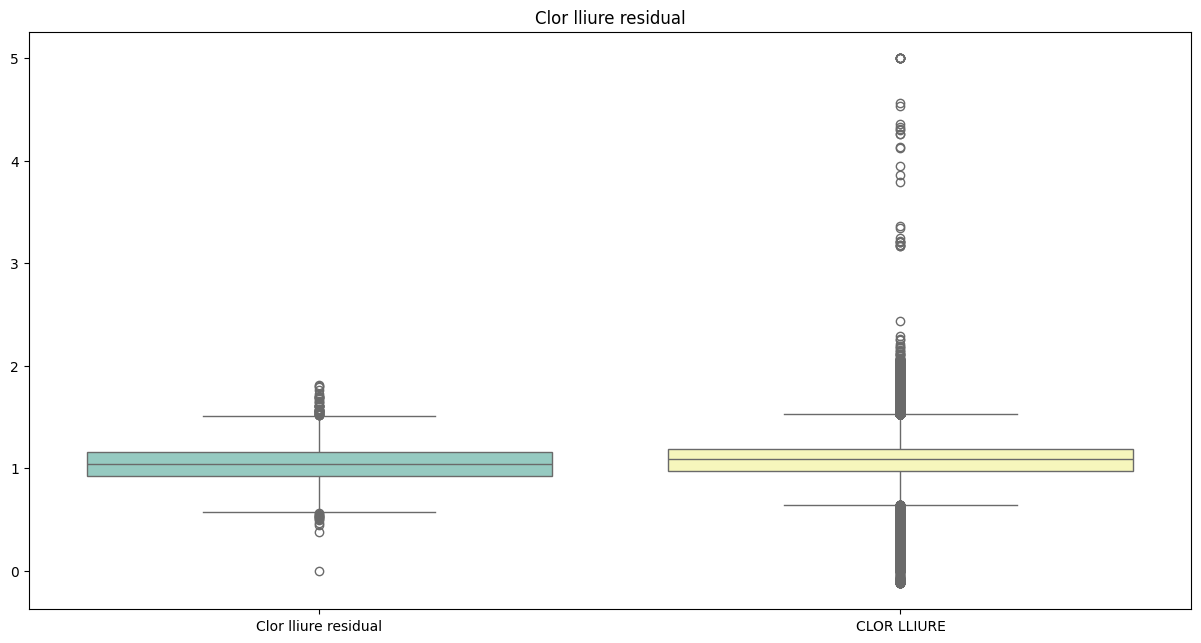

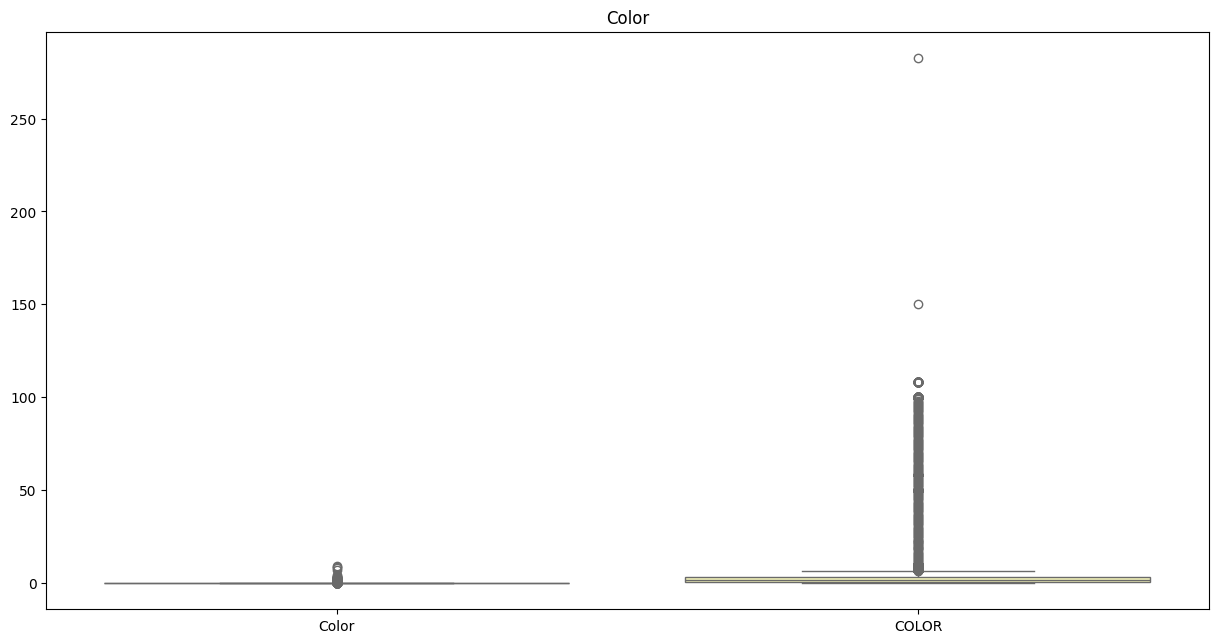

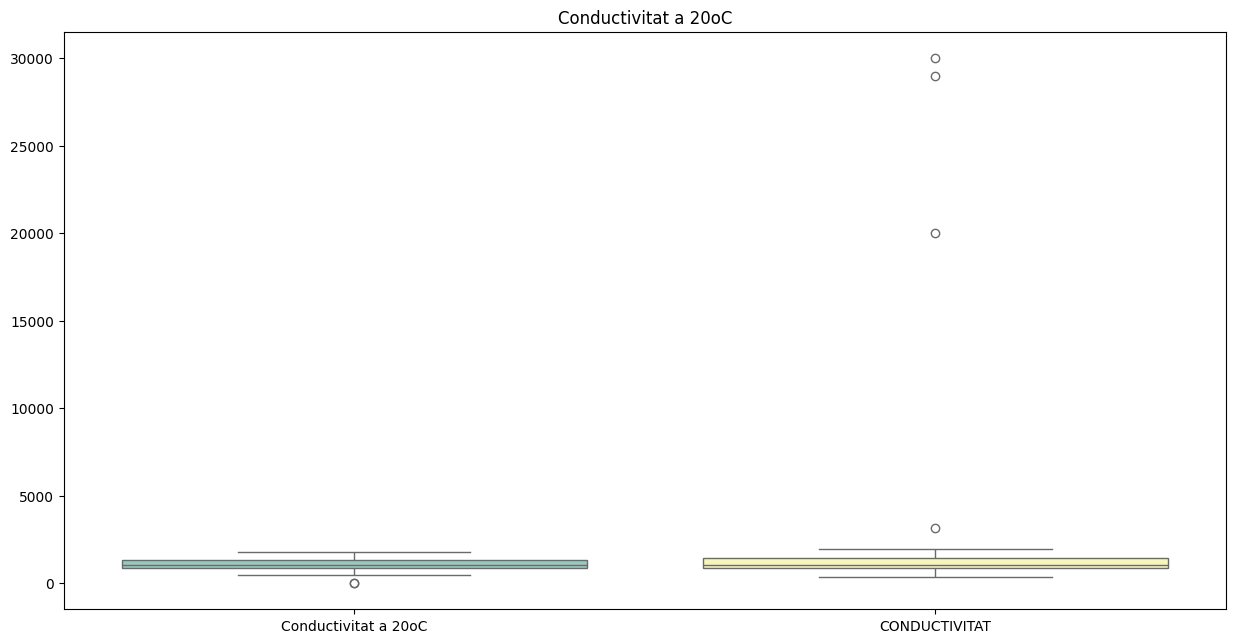

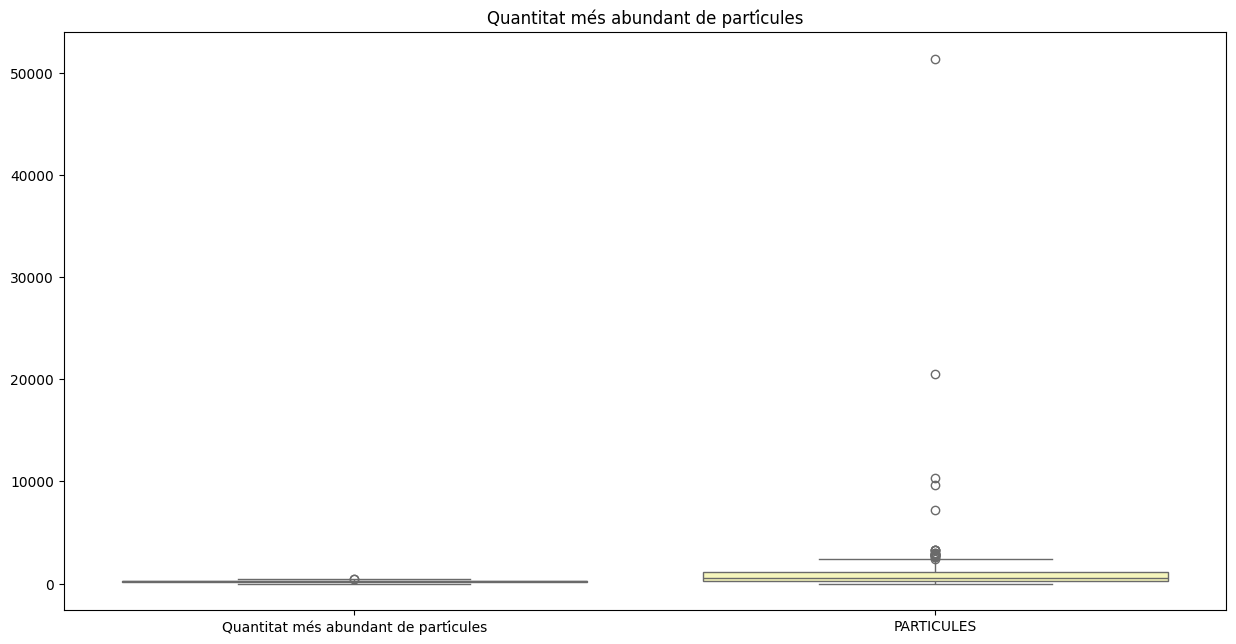

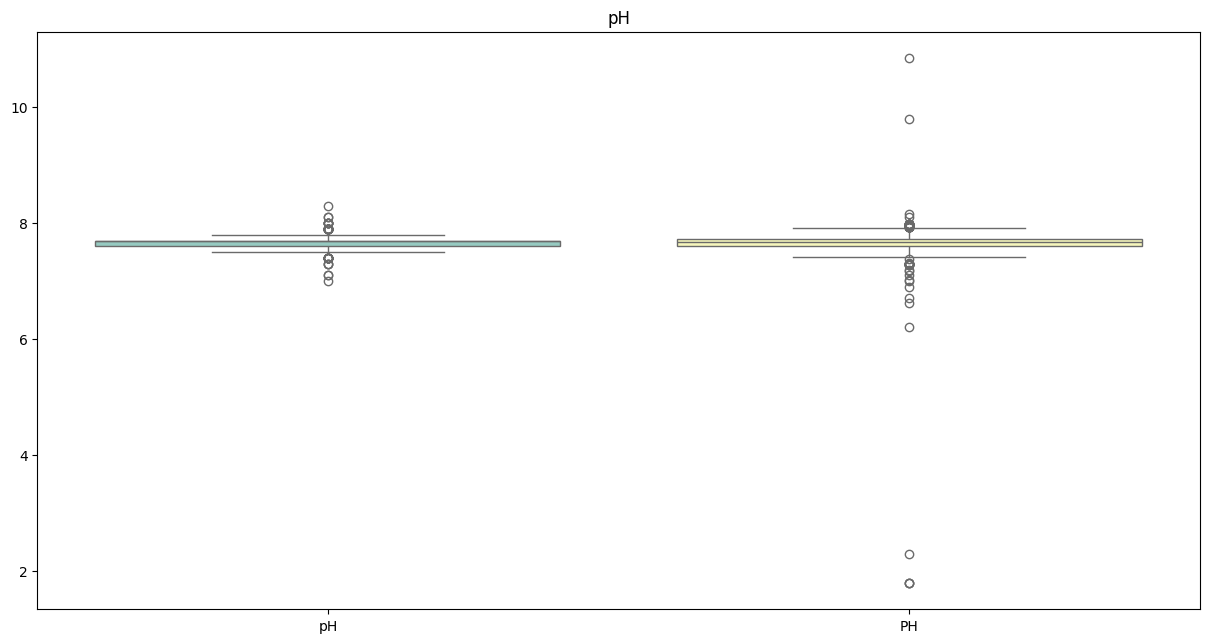

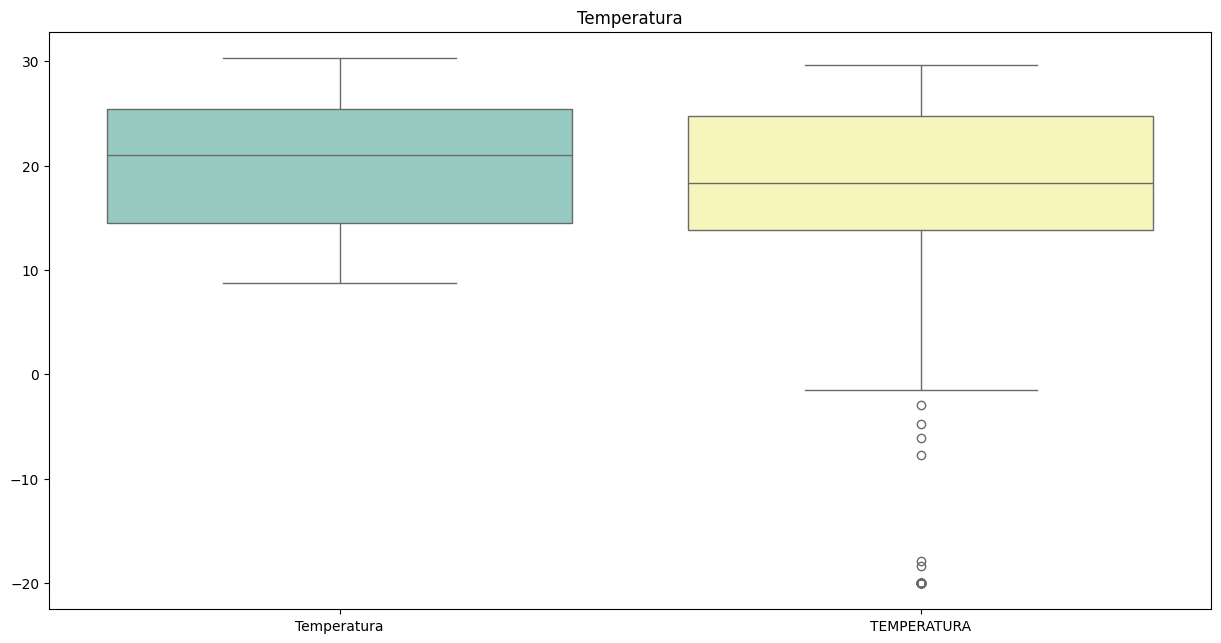

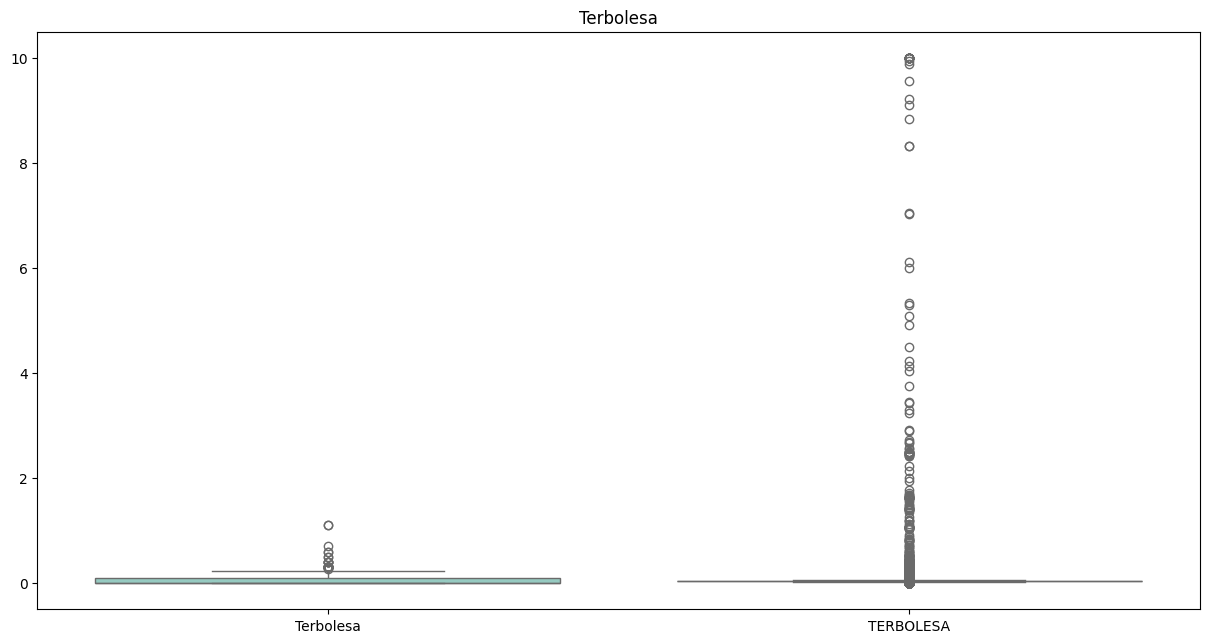

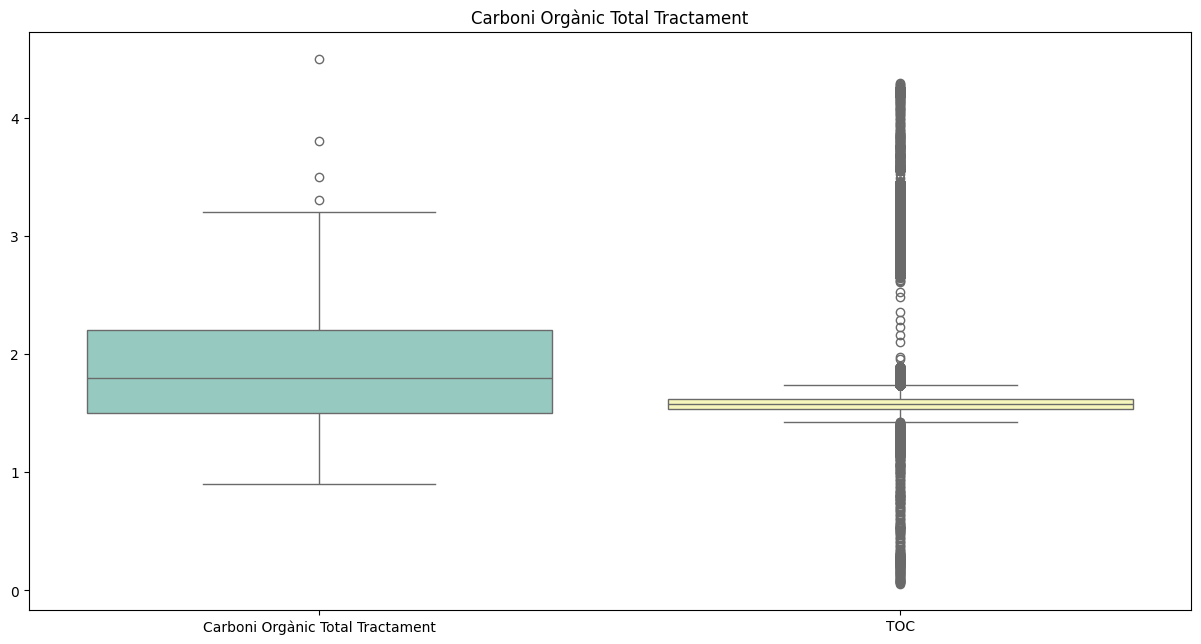

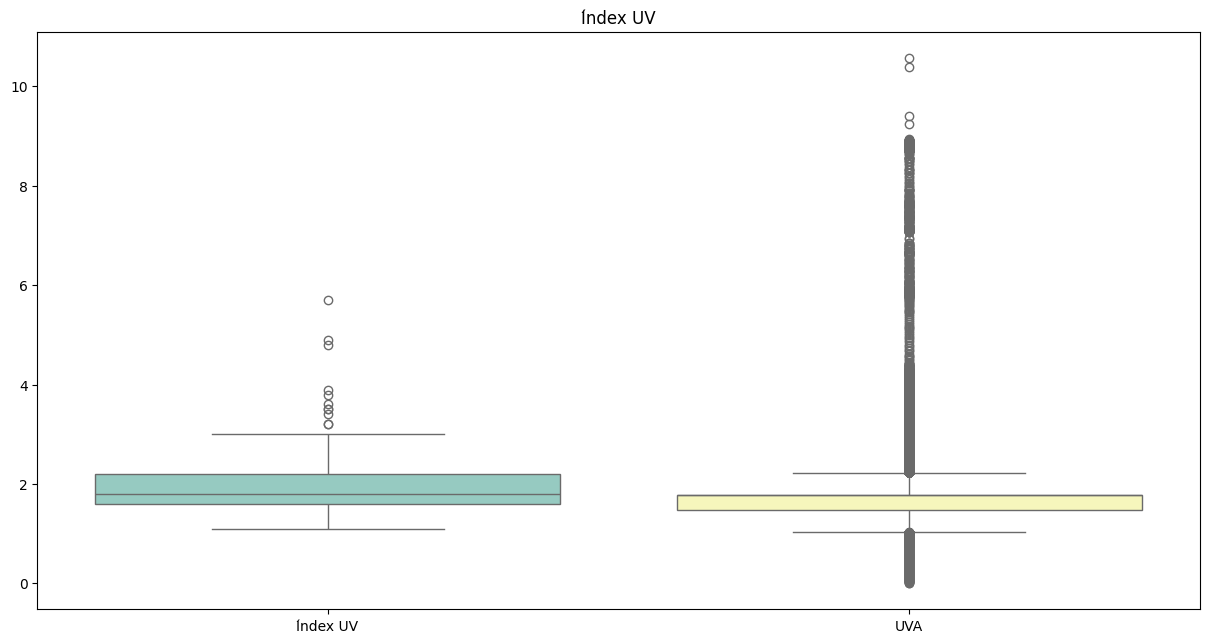

In [24]:
for lab_key, sensor_key in eb1_features_mapping.items():
    lab_key = normalize_string(lab_key)
    lab_df = eb1_features_lab_df[lab_key]
    sensor_df = eb1_sensor_df[sensor_key]

    # remove 0 values from sensor data
    sensor_df = sensor_df[sensor_df != 0]

    if not lab_df.empty and not sensor_df.empty:
        plt.figure(figsize=(15, 7.5))

        sns.boxplot(data=[lab_df, sensor_df], palette="Set3")

        plt.title(lab_key)
        plt.show()

### Time series

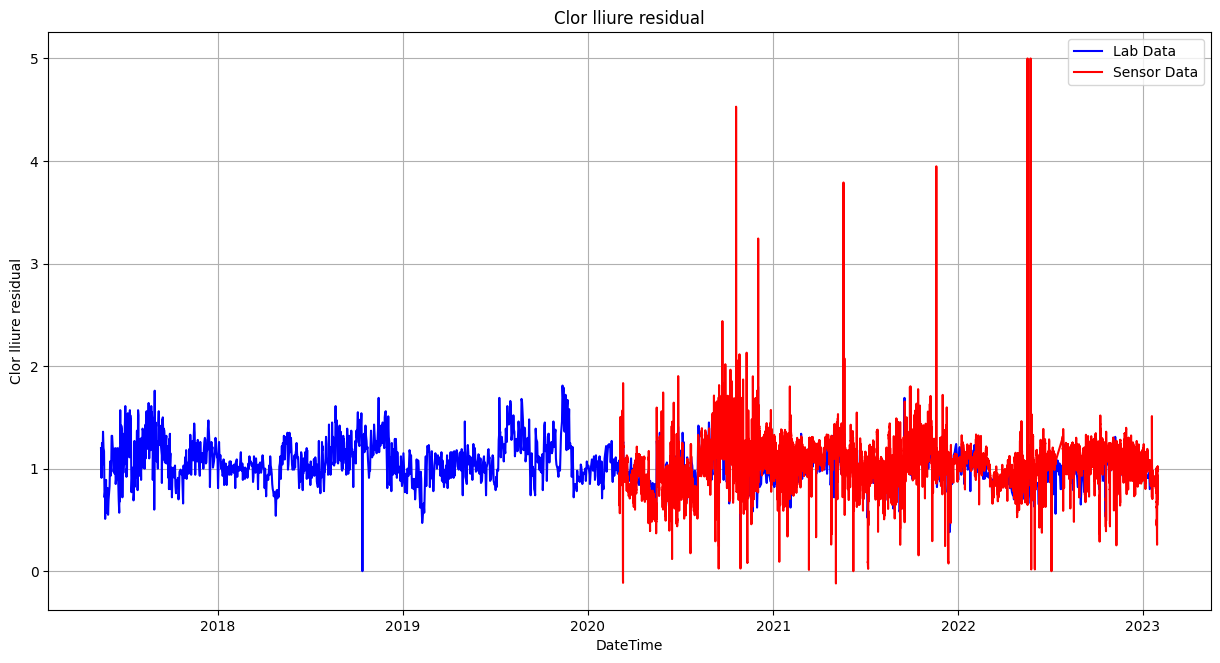

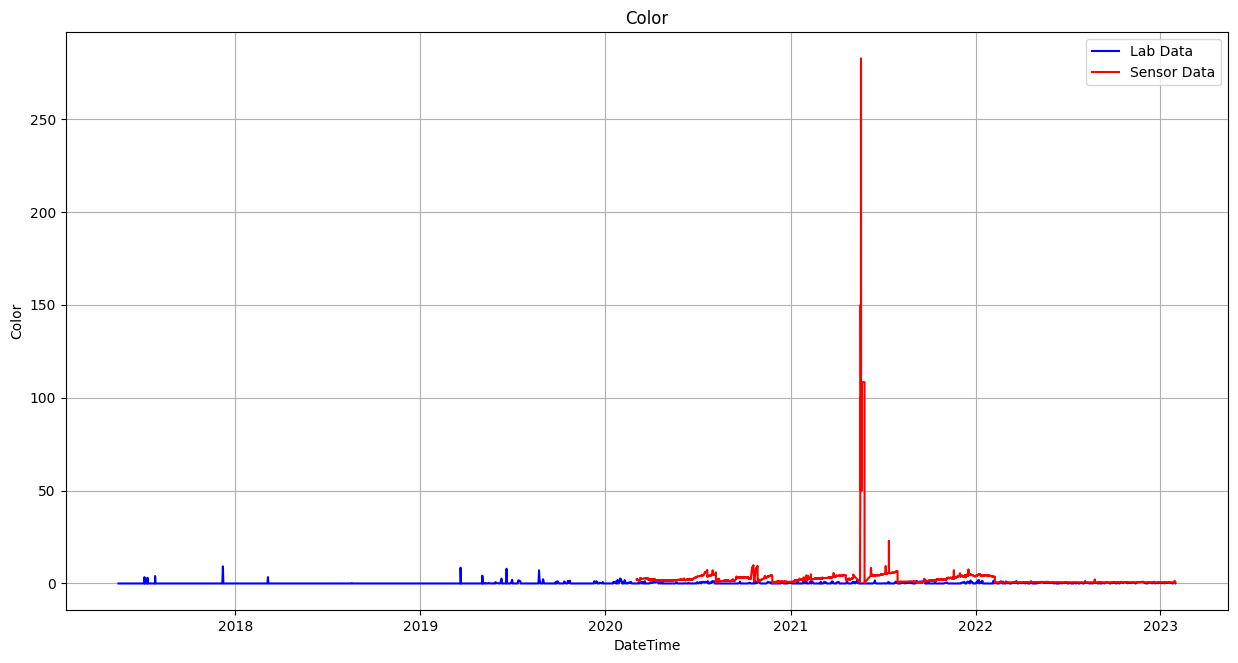

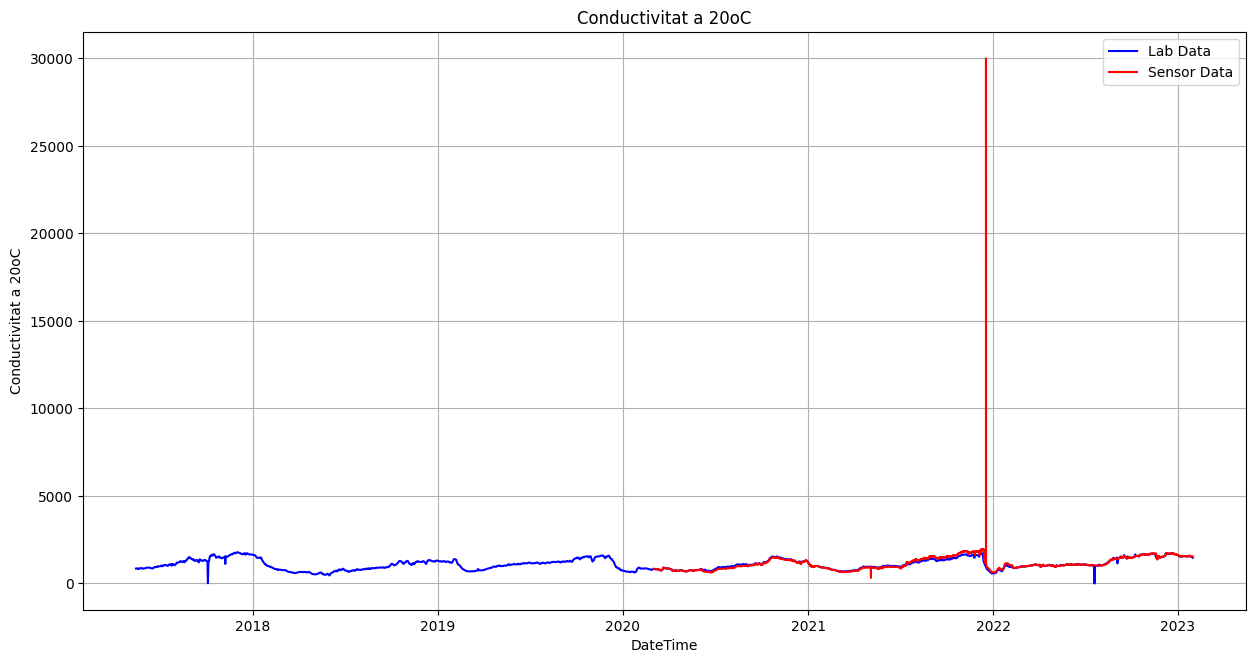

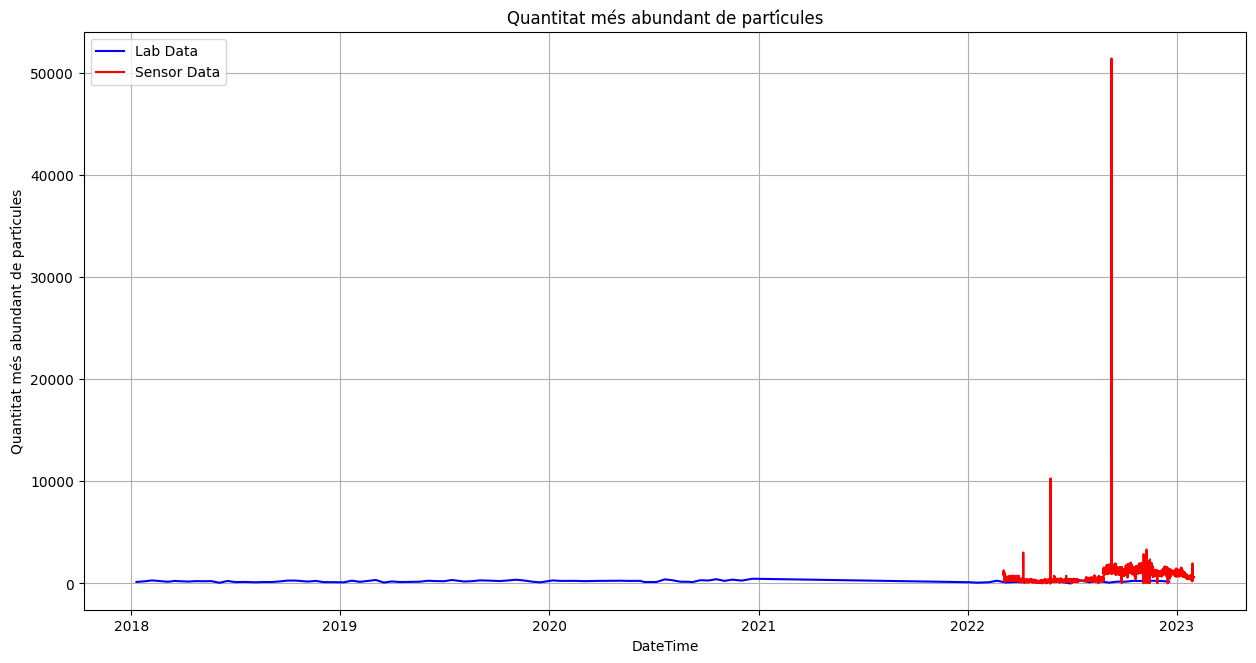

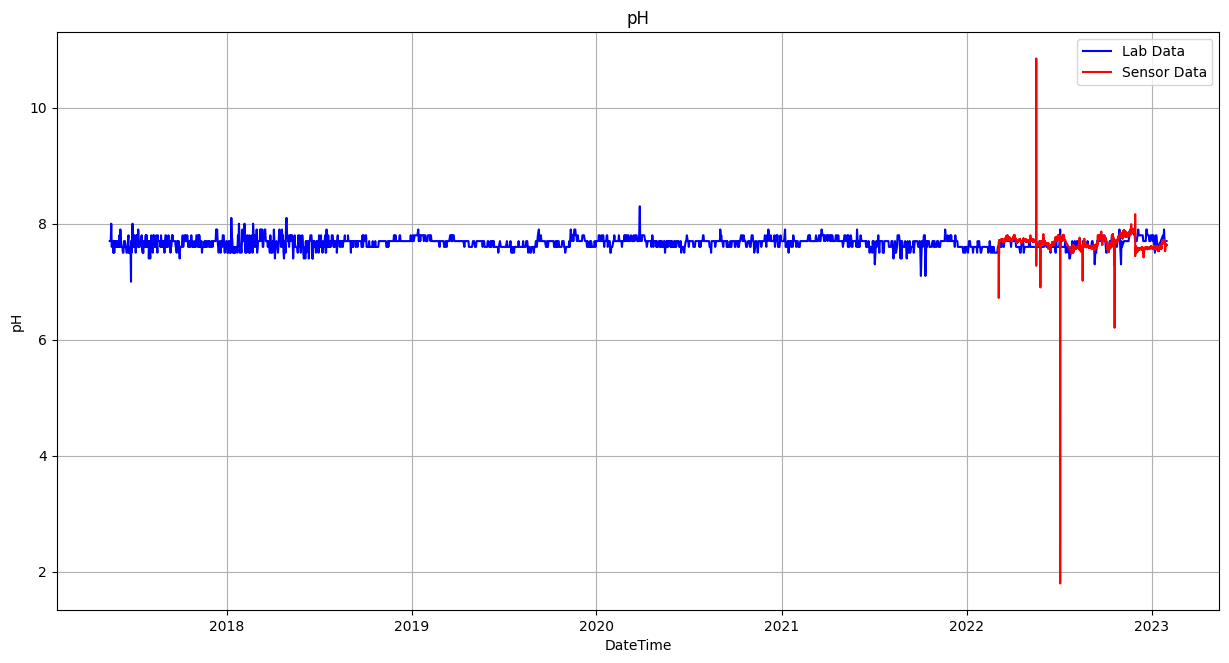

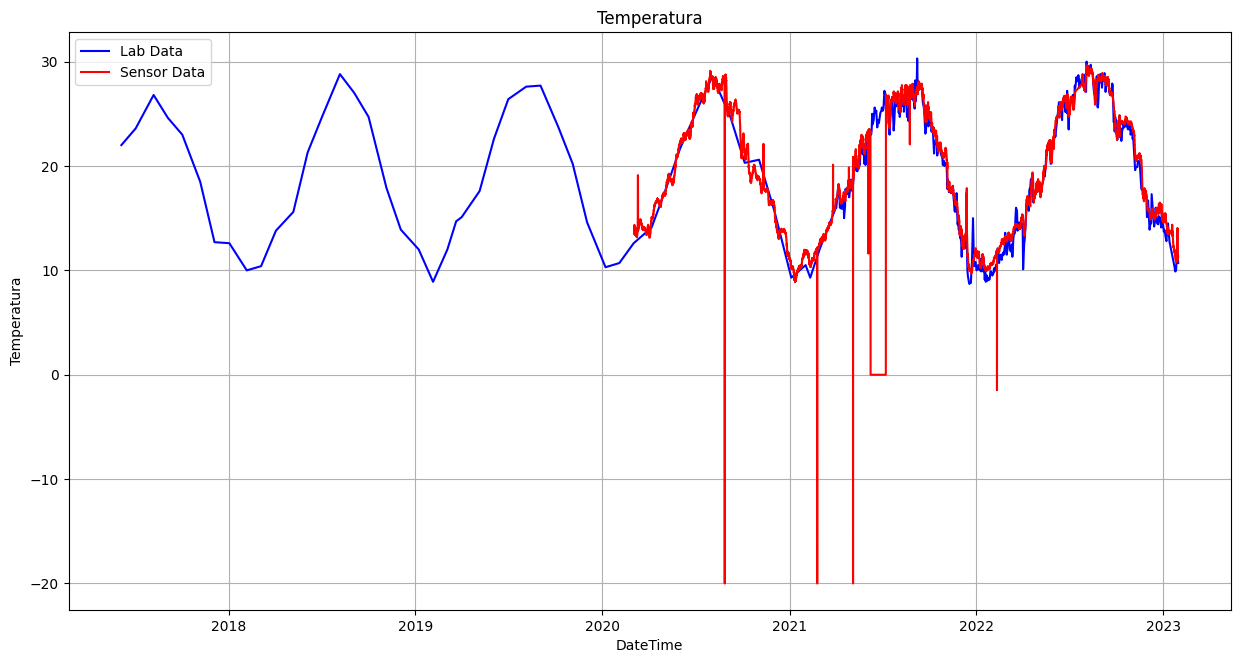

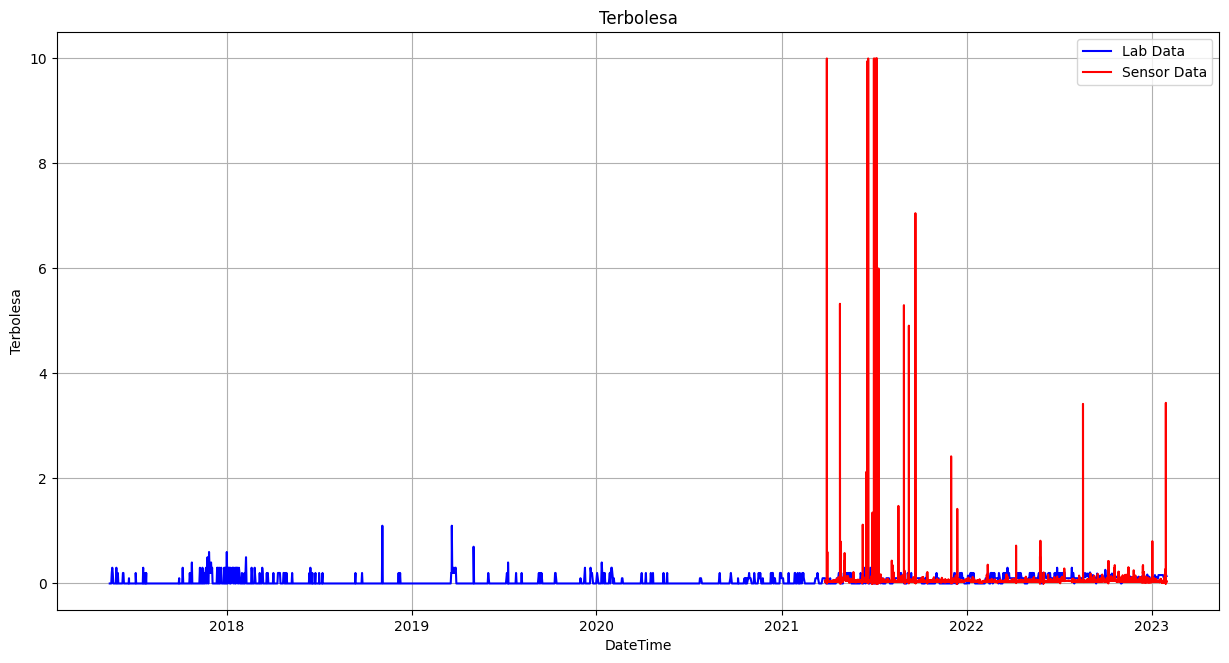

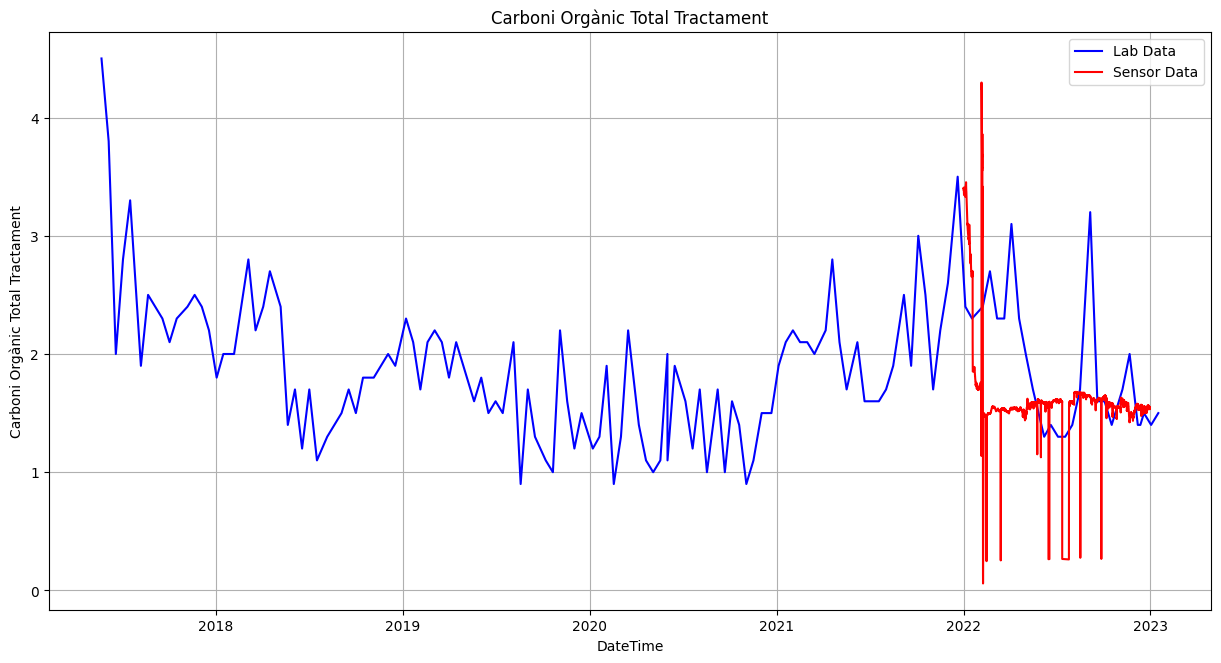

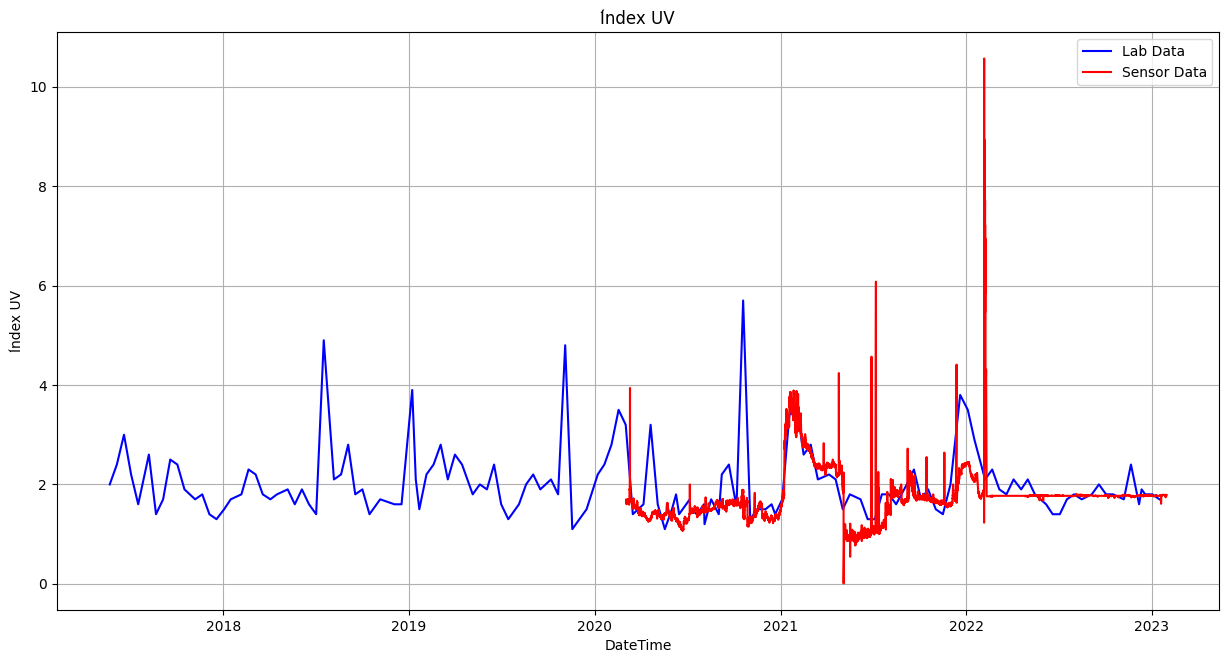

In [25]:
for lab_key, sensor_key in eb1_features_mapping.items():
    lab_key = normalize_string(lab_key)
    lab_df = eb1_features_lab_df[["DateTime", lab_key]]
    sensor_df = eb1_sensor_df[["DateTime", sensor_key]]

    # remove 0 values from sensor data
    sensor_df = sensor_df[sensor_df[sensor_key] != 0]

    if not lab_df.empty and not sensor_df.empty:
        plt.figure(figsize=(15, 7.5))

        sns.lineplot(
            x="DateTime",
            y=lab_key,
            data=lab_df,
            color="blue",
            label="Lab Data",
        )

        sns.lineplot(
            x="DateTime",
            y=sensor_key,
            data=sensor_df,
            color="red",
            label="Sensor Data",
        )

        plt.title(lab_key)
        plt.legend()
        plt.grid(True)
        plt.show()

### Retrieve Common Time Range data + Hypothesis Tests

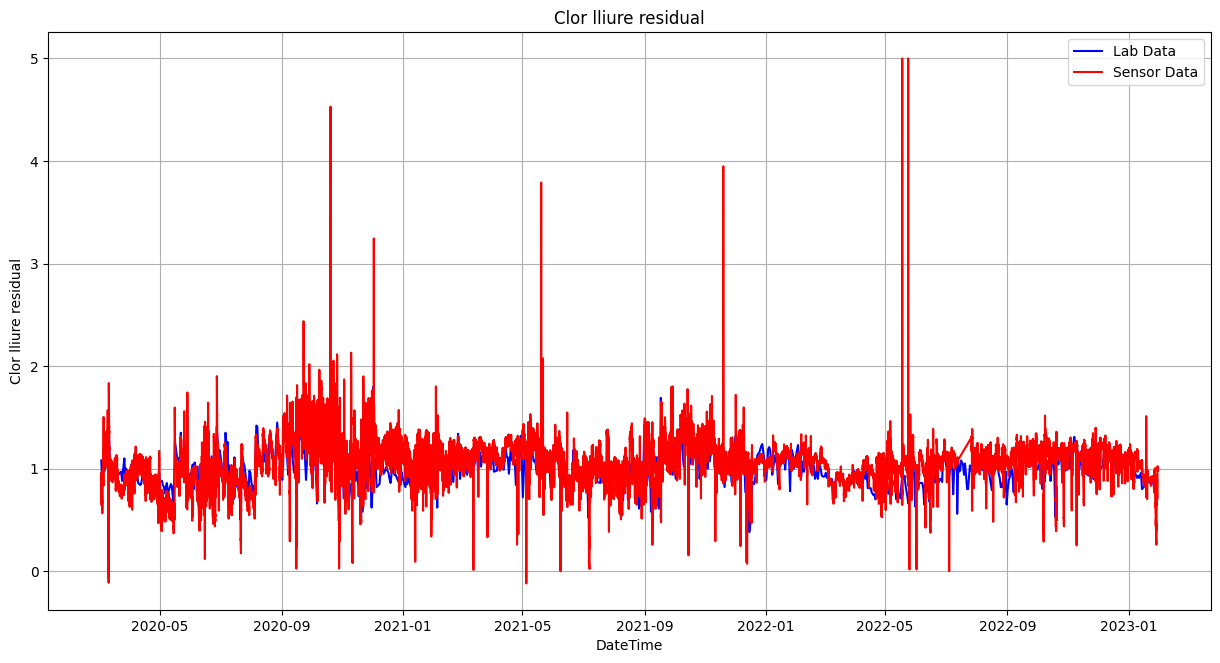

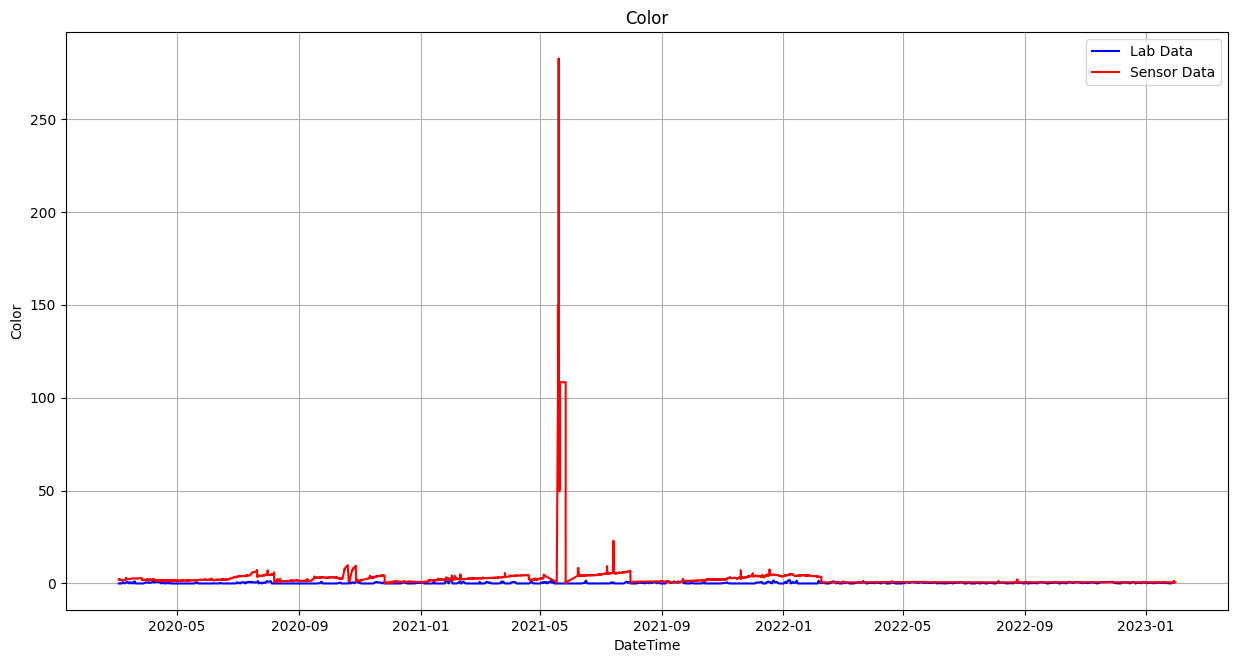

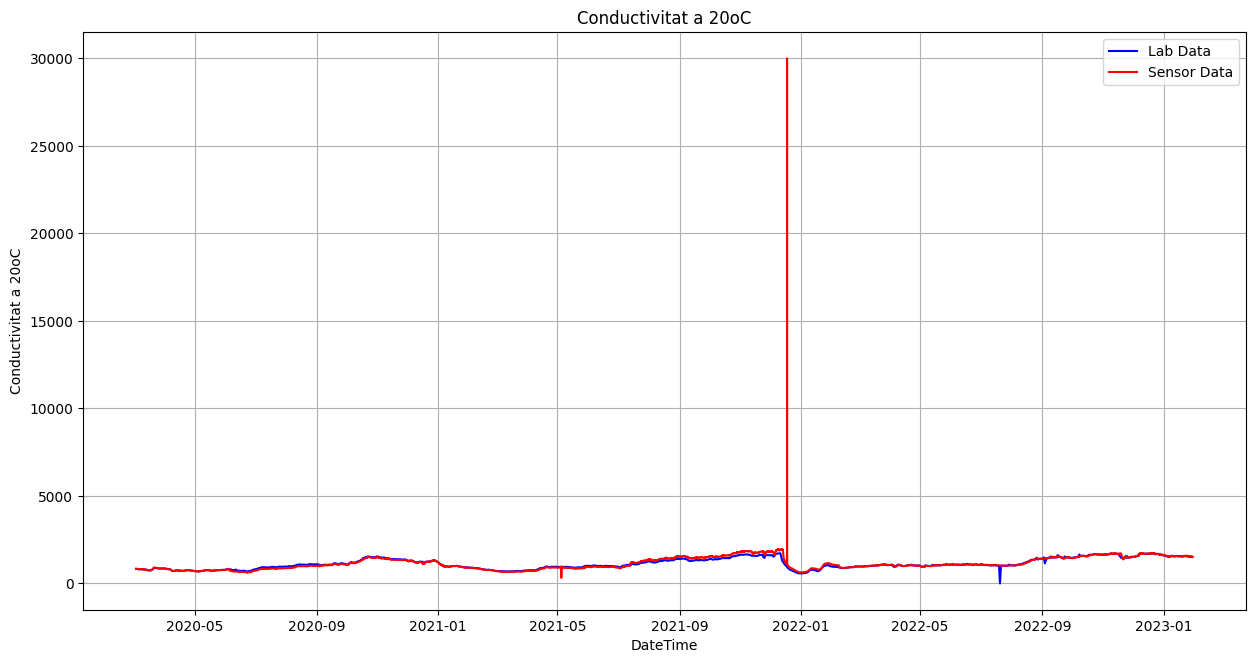

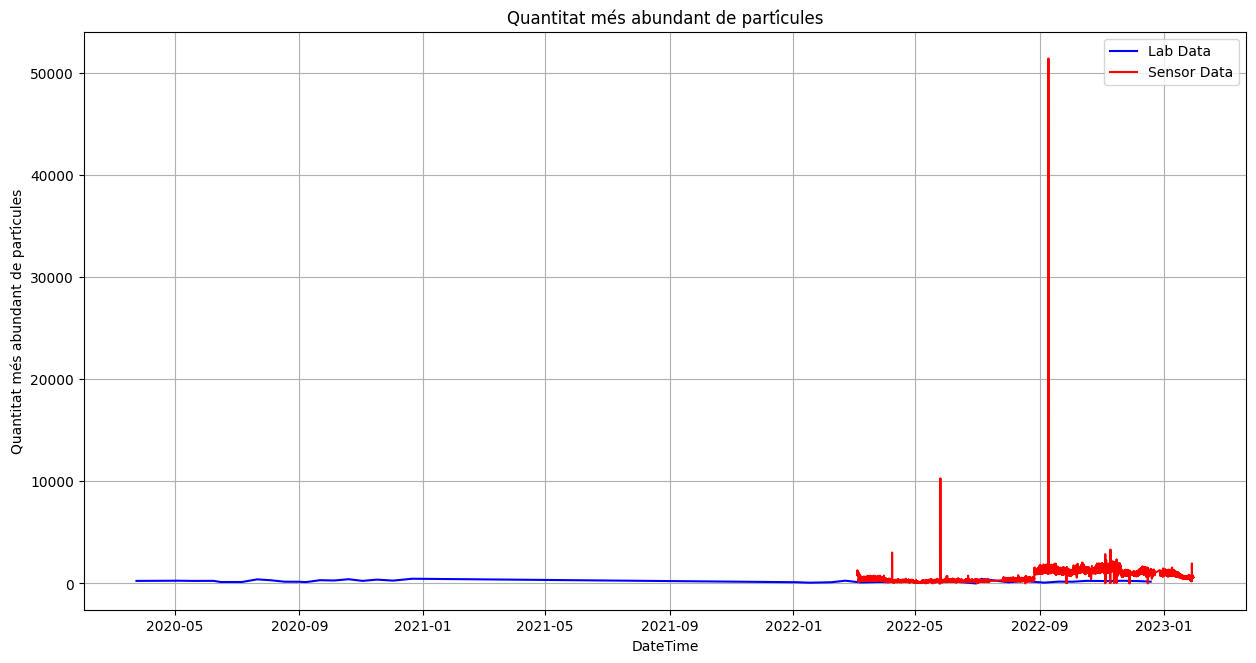

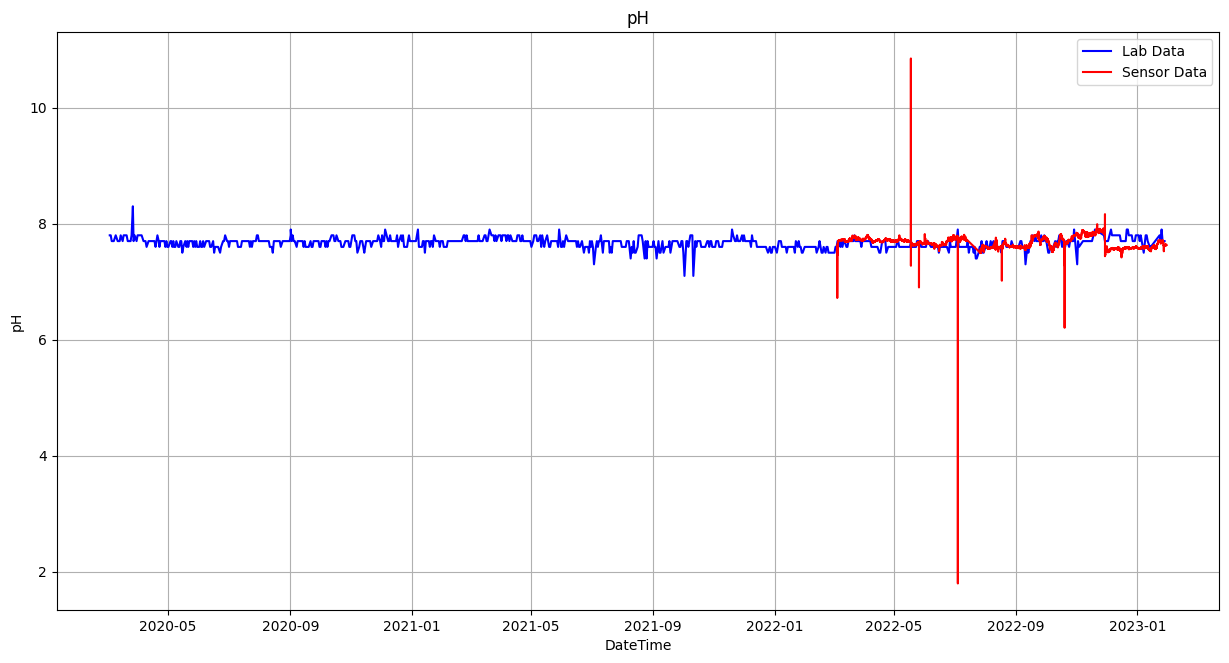

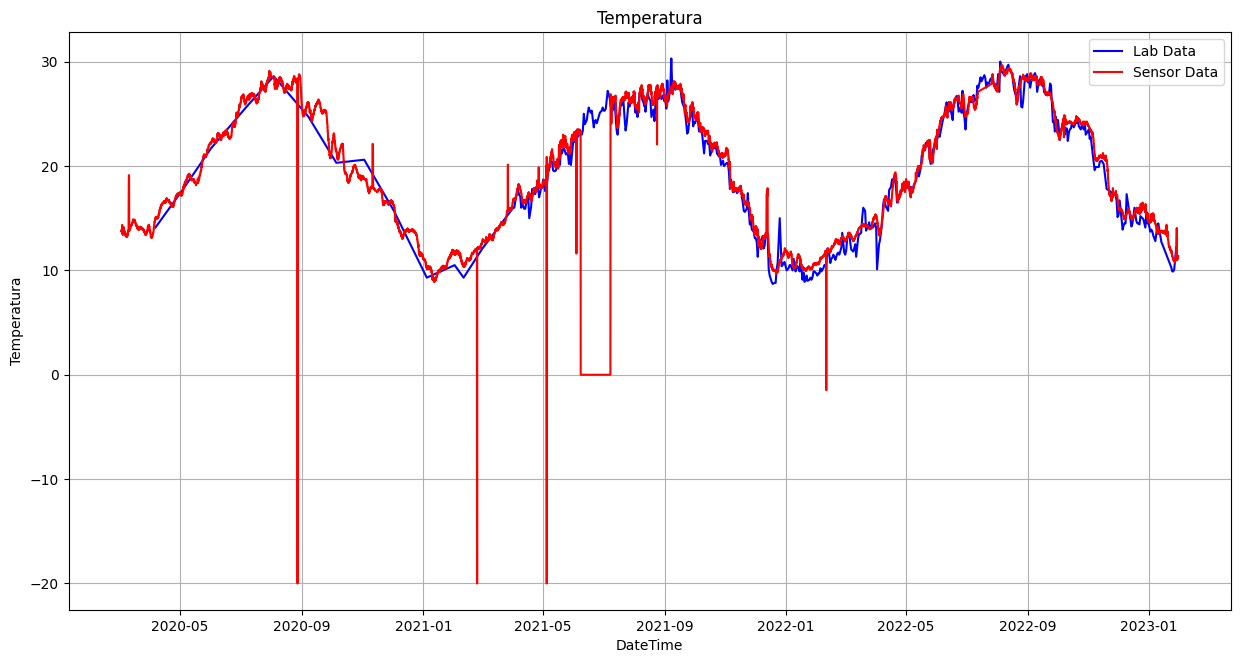

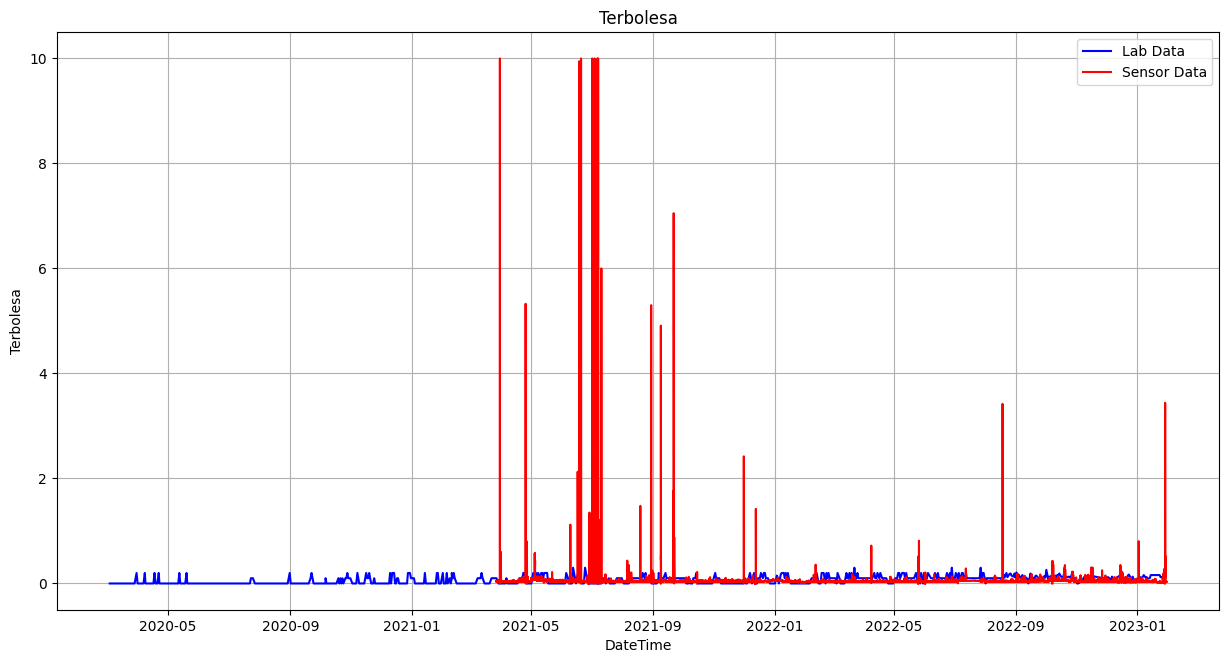

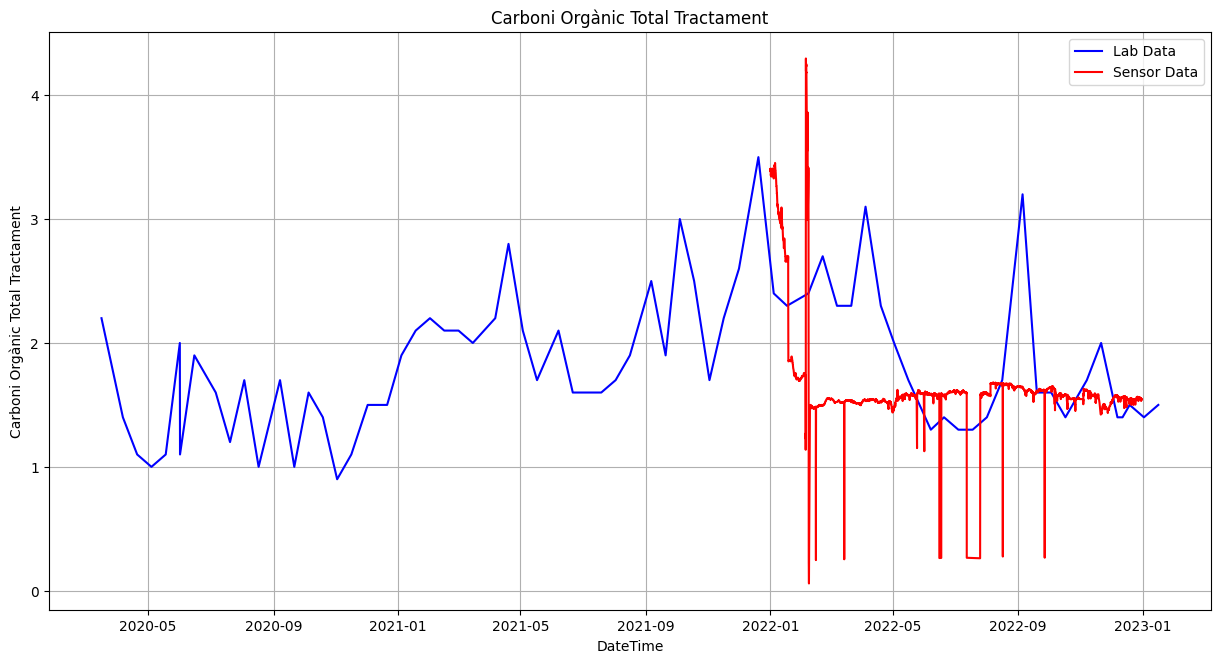

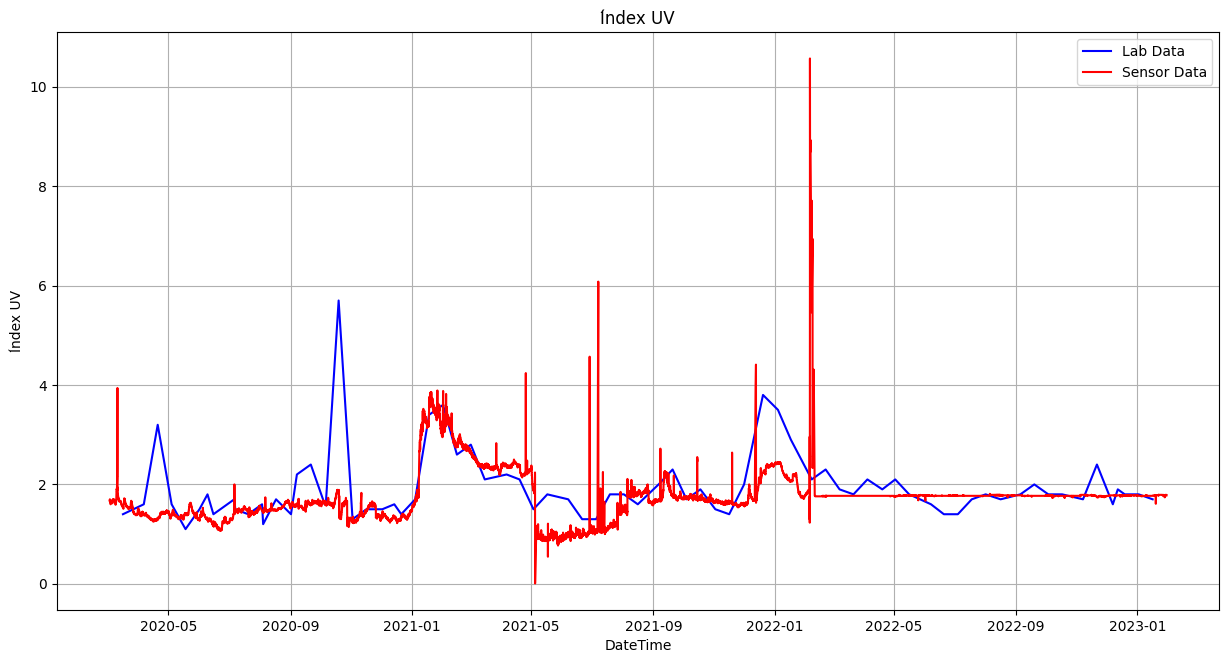

In [26]:
ks_hypothesis_tests = {}
t_hypothesis_tests = {}
u_hypothesis_tests = {}

# get common time range samples for lab and sensor data
for lab_key, sensor_key in eb1_features_mapping.items():
    lab_key = normalize_string(lab_key)
    lab_df = eb1_features_lab_df[["DateTime", lab_key]]
    sensor_df = eb1_sensor_df[["DateTime", sensor_key]]

    # remove 0 values from sensor data
    sensor_df = sensor_df[sensor_df != 0]

    if not lab_df.empty and not sensor_df.empty:
        lab_time_range_df = lab_df[
            (lab_df["DateTime"] >= sensor_df["DateTime"].min())
            & (lab_df["DateTime"] <= sensor_df["DateTime"].max())
        ]

        sensor_time_range_df = sensor_df[
            (sensor_df["DateTime"] >= lab_df["DateTime"].min())
            & (sensor_df["DateTime"] <= lab_df["DateTime"].max())
        ]

        plt.figure(figsize=(15, 7.5))

        sns.lineplot(
            x="DateTime",
            y=lab_key,
            data=lab_time_range_df,
            color="blue",
            label="Lab Data",
        )

        sns.lineplot(
            x="DateTime",
            y=sensor_key,
            data=sensor_time_range_df,
            color="red",
            label="Sensor Data",
        )

        # two sample KS test
        ks_result, ks_p_value = stats.ks_2samp(
            lab_df[lab_key], sensor_df[sensor_key]
        )
        t_result, t_p_value = stats.ttest_ind(
            lab_df[lab_key].dropna(), sensor_df[sensor_key].dropna()
        )
        u_result, u_p_value = stats.mannwhitneyu(
            lab_df[lab_key].dropna(), sensor_df[sensor_key].dropna()
        )

        ks_hypothesis_tests[lab_key] = {
            "ks_test": ks_result,
            "p_value": ks_p_value,
        }

        t_hypothesis_tests[lab_key] = {"t_test": t_result, "p_value": t_p_value}

        u_hypothesis_tests[lab_key] = {"u_test": u_result, "p_value": u_p_value}

        plt.title(lab_key)
        plt.grid(True)
        plt.legend()
        plt.show()

In [27]:
pd.DataFrame(ks_hypothesis_tests).T

ks_test  p_value
Clor lliure residual                        NaN      NaN
Color                                       NaN      NaN
Conductivitat a 20oC                        NaN      NaN
Quantitat més abundant de partícules      NaN      NaN
pH                                          NaN      NaN
Temperatura                                 NaN      NaN
Terbolesa                                   NaN      NaN
Carboni Orgànic Total Tractament           NaN      NaN
Índex UV                                   NaN      NaN

In [28]:
pd.DataFrame(t_hypothesis_tests).T

t_test        p_value
Clor lliure residual                    -4.873809   1.095768e-06
Color                                  -21.772311  6.214335e-105
Conductivitat a 20oC                    -6.921911   4.473409e-12
Quantitat més abundant de partícules  -8.472612   2.472096e-17
pH                                      -2.860457   4.232159e-03
Temperatura                              4.497263   6.888495e-06
Terbolesa                               -0.059919   9.522199e-01
Carboni Orgànic Total Tractament        6.430168   1.286007e-10
Índex UV                                5.446881   5.134078e-08

In [29]:
pd.DataFrame(u_hypothesis_tests).T

u_test        p_value
Clor lliure residual                    130155741.5   9.956439e-20
Color                                    10381052.5   0.000000e+00
Conductivitat a 20oC                    136275331.0   1.685212e-08
Quantitat més abundant de partícules     740151.0   8.320069e-28
pH                                       43138273.0   1.430649e-02
Temperatura                              47959804.5   1.662321e-04
Terbolesa                                53030511.5  2.291465e-235
Carboni Orgànic Total Tractament         4378143.5   9.201464e-08
Índex UV                                13662182.5   4.844851e-08

### Distributions Divergence

In [30]:
kl_divs = {}
js_divs = {}
tv_dists = {}
w_dists = {}

for lab_key, sensor_key in eb1_features_mapping.items():
    # Compute the probability distribution of the feature in each DataFrame
    lab_df = eb1_features_lab_df[lab_key]
    sensor_df = eb1_sensor_df[sensor_key]

    lab_pdist = np.histogram(lab_df.dropna(), bins=100, density=True)[0]
    sensor_pdist = np.histogram(sensor_df.dropna(), bins=100, density=True)[0]

    # Add a small constant to avoid division by zero
    lab_pdist = lab_pdist + np.finfo(np.float64).eps
    sensor_pdist = sensor_pdist + np.finfo(np.float64).eps

    # Compute divergence metrics
    kl_div = stats.entropy(lab_pdist, sensor_pdist)
    js_div = jensenshannon(lab_pdist, sensor_pdist)
    tv_dist = np.sum(np.abs(lab_pdist - sensor_pdist)) / 2
    w_dist = wasserstein_distance(lab_pdist, sensor_pdist)

    kl_divs[lab_key] = kl_div
    js_divs[lab_key] = js_div
    tv_dists[lab_key] = tv_dist
    w_dists[lab_key] = w_dist


kl_divs = pd.Series(kl_divs)
js_divs = pd.Series(js_divs)
tv_dists = pd.Series(tv_dists)
w_dists = pd.Series(w_dists)

In [31]:
kl_divs

Clor lliure residual                      26.473989
Color                                      1.158751
Conductivitat a 20oC                      25.805532
Quantitat més abundant de partícules    24.945769
pH                                        32.934027
Temperatura                               13.718143
Terbolesa                                  4.484466
Carboni Orgànic Total Tractament          5.249143
Índex UV                                  2.204170
dtype: float64

In [32]:
js_divs

Clor lliure residual                      0.816230
Color                                     0.345928
Conductivitat a 20oC                      0.831319
Quantitat més abundant de partícules    0.816656
pH                                        0.813222
Temperatura                               0.503759
Terbolesa                                 0.337767
Carboni Orgànic Total Tractament         0.710416
Índex UV                                 0.614637
dtype: float64

In [33]:
tv_dists

Clor lliure residual                      36.695289
Color                                      5.258271
Conductivitat a 20oC                       0.029621
Quantitat més abundant de partícules     0.107691
pH                                        41.694699
Temperatura                                1.713340
Terbolesa                                 40.607466
Carboni Orgànic Total Tractament         21.286404
Índex UV                                 12.392517
dtype: float64

In [34]:
w_dists

Clor lliure residual                      0.357176
Color                                     0.105158
Conductivitat a 20oC                      0.000527
Quantitat més abundant de partícules    0.002136
pH                                        0.677072
Temperatura                               0.026144
Terbolesa                                 0.809149
Carboni Orgànic Total Tractament         0.230660
Índex UV                                 0.136997
dtype: float64

# Lab Data Feature-Target Analysis

In [35]:
trihalometh_columns = [
    "Cloroform",
    "Bromodiclorometà",
    "Dibromoclorometà",
    "Bromoform",
]

acid_columns = [
    "àcid bromocloroacètic",
    "àcid dibromoacètic",
    "àcid dicloroacètic",
    "àcid monobromoacètic",
    "àcid monocloroacètic",
]

other_columns = [
    "Clorat",
    "Clorit",
]

trihalometh_mapping = {
    "Cloroform": "TCM",
    "Bromodiclorometà": "DCBM",
    "Dibromoclorometà": "CDBM",
    "Bromoform": "TBM",
}

## EB1 - THMs

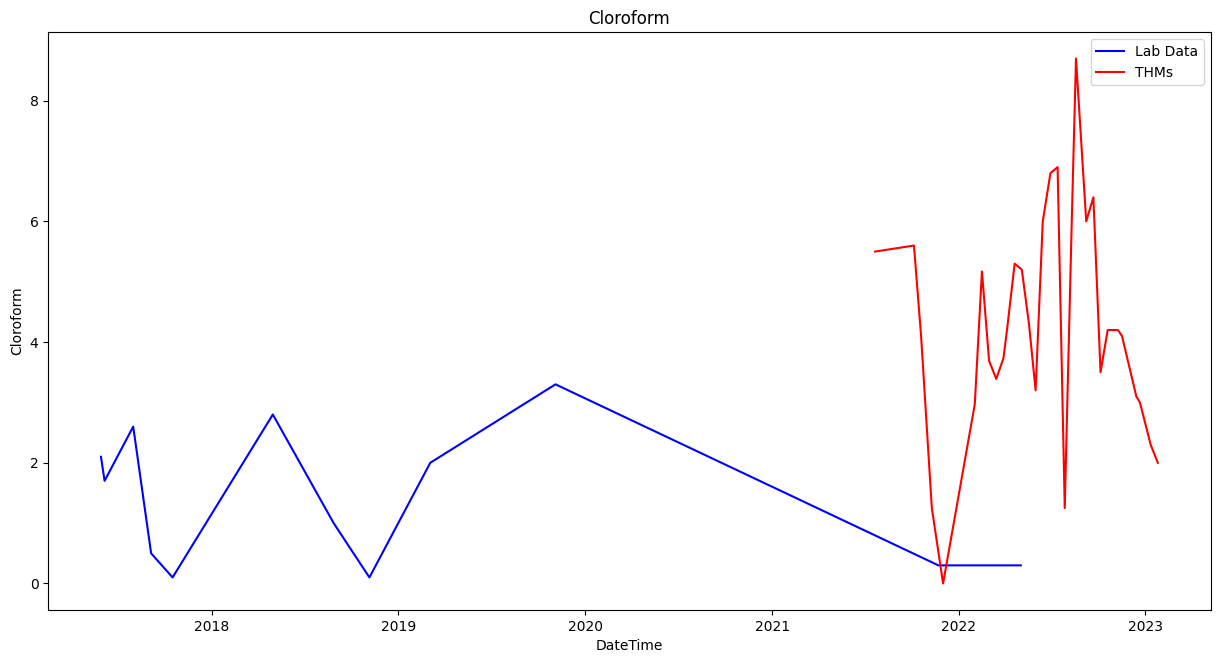

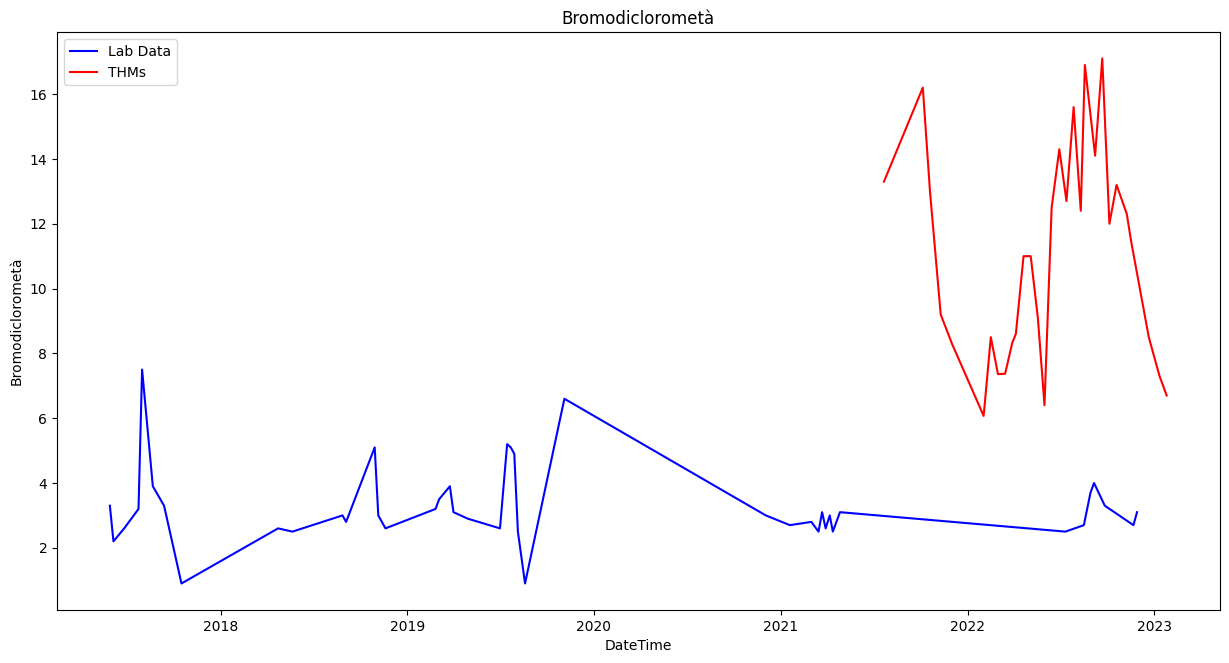

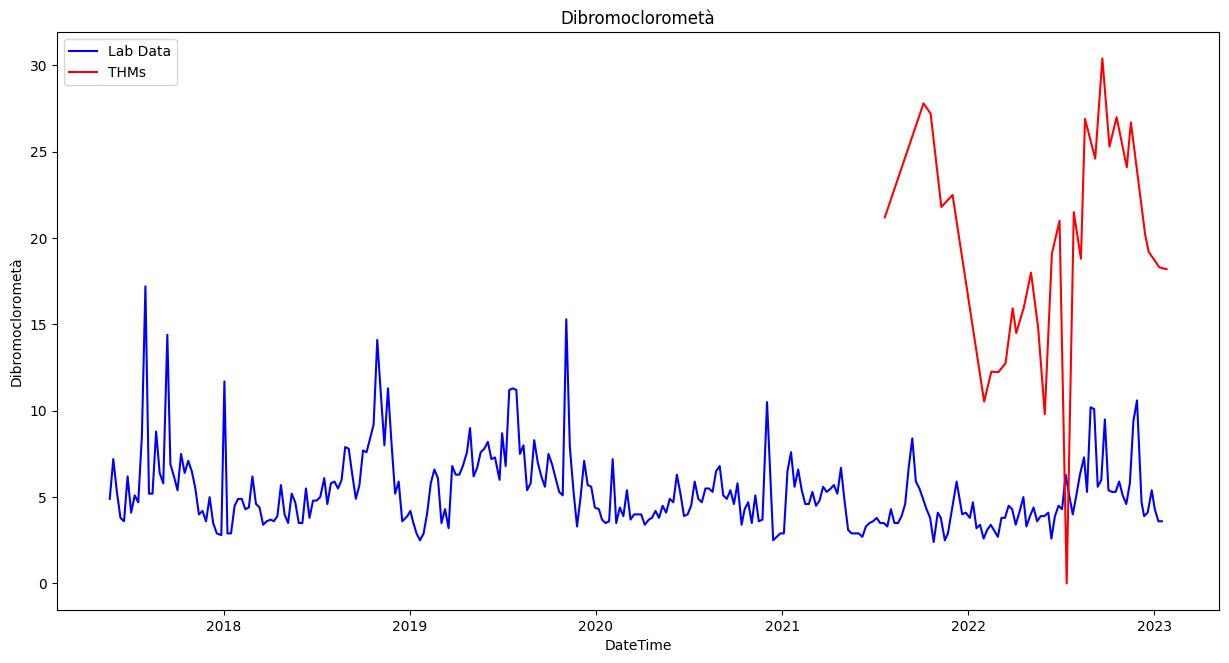

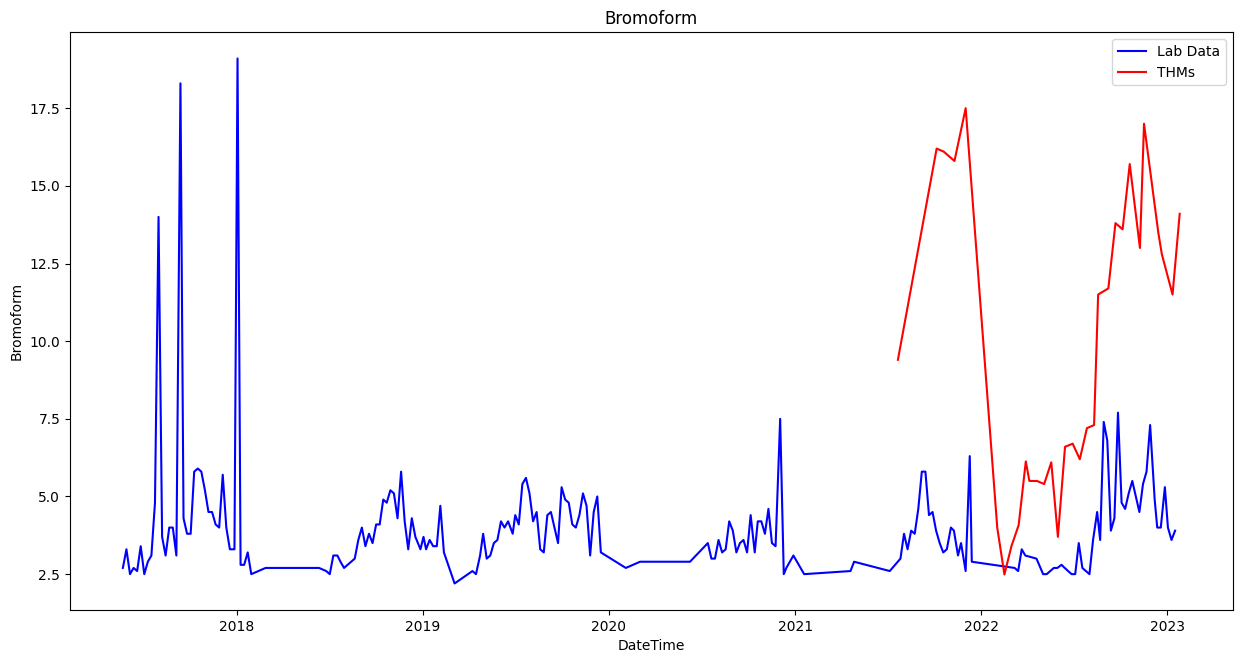

In [36]:
for eb1_key, thm_key in trihalometh_mapping.items():
    plt.figure(figsize=(15, 7.5))

    lab_df = eb1_targets_lab_df[["DateTime", eb1_key]]
    lab_df = lab_df[lab_df != 0]

    thms = thms_df[["DateTime", thm_key]]

    sns.lineplot(
        x="DateTime", y=eb1_key, data=lab_df, color="blue", label="Lab Data"
    )

    sns.lineplot(x="DateTime", y=thm_key, data=thms, color="red", label="THMs")

    plt.title(eb1_key)
    plt.show()

### Join on same day

In [37]:
eb1_targets_lab_df

DateTime  Bromodiclorometà  Bromoform  Clorat  Clorit  \
0   2017-05-15 07:40:00               0.0        0.0     NaN     NaN   
1   2017-05-22 07:15:00               0.0        2.7     0.0     0.0   
2   2017-05-29 07:00:00               3.3        3.3     NaN     NaN   
3   2017-06-05 07:30:00               2.2        2.5     NaN     0.0   
4   2017-06-12 07:40:00               0.0        2.7     NaN     NaN   
..                  ...               ...        ...     ...     ...   
298 2022-12-19 06:45:00               0.0        4.0   127.0     0.0   
299 2022-12-27 07:00:00               0.0        5.3     NaN     NaN   
300 2023-01-02 06:55:00               0.0        4.0   136.0     0.0   
301 2023-01-09 08:30:00               0.0        3.6     NaN     NaN   
302 2023-01-16 08:35:00               0.0        3.9   132.0     0.0   

     Cloroform  Dibromoclorometà  àcid bromocloroacètic  àcid dibromoacètic  \
0          0.0               0.0                    NaN                 NaN   
1          0.0               4.9                    1.3                 1.7   
2          2.1               7.2                    NaN                 NaN   
3          1.7               5.3                    1.3                 1.7   
4          0.0               3.8                    NaN                 NaN   
..         ...               ...                    ...                 ...   
298        0.0               4.1                    0.8                 2.2   
299        0.0               5.4                    NaN                 NaN   
300        0.0               4.3                    0.9                 2.3   
301        0.0               3.6                    NaN                 NaN   
302        0.0               3.6                    0.7                 2.3   

     àcid dicloroacètic  àcid monobromoacètic  àcid monocloroacètic  
0                   NaN                   NaN                   NaN  
1                   0.8                   0.0                   0.0  
2                   NaN                   NaN                   NaN  
3                   0.7                   0.0                   0.0  
4                   NaN                   NaN                   NaN  
..                  ...                   ...                   ...  
298                 0.0                   0.0                   0.0  
299                 NaN                   NaN                   NaN  
300                 0.0                   0.0                   0.0  
301                 NaN                   NaN                   NaN  
302                 0.0                   0.0                   0.0  

[303 rows x 12 columns]

In [38]:
eb1_features_lab_df

DateTime  Carboni Orgànic Total Tractament  \
0    2017-05-15 07:40:00                                NaN   
1    2017-05-16 07:45:00                                NaN   
2    2017-05-17 07:30:00                                NaN   
3    2017-05-18 07:30:00                                NaN   
4    2017-05-19 07:30:00                                NaN   
...                  ...                                ...   
2070 2023-01-24 08:25:00                                NaN   
2071 2023-01-25 08:30:00                                NaN   
2072 2023-01-26 08:30:00                                NaN   
2073 2023-01-28 08:55:00                                NaN   
2074 2023-01-30 08:25:00                                NaN   

      Clor lliure residual  Color  Conductivitat a 20oC  \
0                     1.20    0.0                 852.0   
1                     0.91    0.0                 857.0   
2                     1.25    0.0                 866.0   
3                     1.04    0.0                 863.0   
4                     1.36    0.0                 830.0   
...                    ...    ...                   ...   
2070                  0.88    0.1                1552.0   
2071                  0.87    0.0                1539.0   
2072                  0.83    0.1                1528.0   
2073                  0.84    0.5                1524.0   
2074                  0.90    0.1                1467.0   

      Quantitat més abundant de partícules  Temperatura  Terbolesa   pH  \
0                                        NaN          NaN       0.00  7.7   
1                                        NaN          NaN       0.00  7.7   
2                                        NaN          NaN       0.00  7.7   
3                                        NaN          NaN       0.00  8.0   
4                                        NaN          NaN       0.20  7.6   
...                                      ...          ...        ...  ...   
2070                                     NaN          9.9       0.12  7.7   
2071                                     NaN          9.9       0.12  7.9   
2072                                     NaN         10.1       0.13  7.7   
2073                                     NaN         12.2       0.19  7.7   
2074                                     NaN         10.7       0.14  7.7   

      Índex UV  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
...         ...  
2070        NaN  
2071        NaN  
2072        NaN  
2073        NaN  
2074        NaN  

[2075 rows x 10 columns]

In [39]:
eb1_features_lab_df["Date"] = eb1_features_lab_df["DateTime"].dt.date
eb1_targets_lab_df["Date"] = eb1_targets_lab_df["DateTime"].dt.date

eb1_lab_df = pd.merge(
    eb1_features_lab_df, eb1_targets_lab_df, on="Date", how="inner"
)

eb1_features_lab_df.drop(columns=["Date"], inplace=True)
eb1_targets_lab_df.drop(columns=["Date"], inplace=True)

In [40]:
eb1_lab_df

DateTime_x  Carboni Orgànic Total Tractament  \
0   2017-05-15 07:40:00                                NaN   
1   2017-05-22 07:15:00                                4.5   
2   2017-05-29 07:00:00                                NaN   
3   2017-06-05 07:30:00                                3.8   
4   2017-06-12 07:40:00                                NaN   
..                  ...                                ...   
433 2022-12-19 08:00:00                                NaN   
434 2022-12-27 07:00:00                                NaN   
435 2023-01-02 06:55:00                                1.4   
436 2023-01-09 08:30:00                                NaN   
437 2023-01-16 08:35:00                                1.5   

     Clor lliure residual  Color  Conductivitat a 20oC  \
0                    1.20    0.0                 852.0   
1                    0.72    0.0                 864.0   
2                    0.55    0.0                 860.0   
3                    1.32    0.0                 902.0   
4                    1.20    0.0                 894.0   
..                    ...    ...                   ...   
433                   NaN    NaN                   NaN   
434                  1.06    0.1                1655.0   
435                  1.06    0.1                1580.0   
436                  0.91    0.1                1583.0   
437                   NaN    NaN                   NaN   

     Quantitat més abundant de partícules  Temperatura  Terbolesa   pH  \
0                                       NaN          NaN       0.00  7.7   
1                                       NaN          NaN       0.00  7.5   
2                                       NaN          NaN       0.00  7.7   
3                                       NaN         22.0       0.00  7.9   
4                                       NaN          NaN       0.00  7.7   
..                                      ...          ...        ...  ...   
433                                   181.0          NaN        NaN  NaN   
434                                     NaN         14.5       0.13  7.7   
435                                     NaN         13.7       0.10  7.8   
436                                     NaN         14.3       0.11  7.8   
437                                     NaN          NaN        NaN  NaN   

     Índex UV  ... Bromoform Clorat  Clorit  Cloroform  Dibromoclorometà  \
0          NaN  ...       0.0    NaN     NaN        0.0               0.0   
1          2.0  ...       2.7    0.0     0.0        0.0               4.9   
2          NaN  ...       3.3    NaN     NaN        2.1               7.2   
3          2.4  ...       2.5    NaN     0.0        1.7               5.3   
4          NaN  ...       2.7    NaN     NaN        0.0               3.8   
..         ...  ...       ...    ...     ...        ...               ...   
433        NaN  ...       4.0  127.0     0.0        0.0               4.1   
434        NaN  ...       5.3    NaN     NaN        0.0               5.4   
435        1.8  ...       4.0  136.0     0.0        0.0               4.3   
436        NaN  ...       3.6    NaN     NaN        0.0               3.6   
437        1.7  ...       3.9  132.0     0.0        0.0               3.6   

     àcid bromocloroacètic  àcid dibromoacètic  àcid dicloroacètic  \
0                      NaN                 NaN                 NaN   
1                      1.3                 1.7                 0.8   
2                      NaN                 NaN                 NaN   
3                      1.3                 1.7                 0.7   
4                      NaN                 NaN                 NaN   
..                     ...                 ...                 ...   
433                    0.8                 2.2                 0.0   
434                    NaN                 NaN                 NaN   
435                    0.9                 2.3                 0.0   
436                    NaN       

### Join on previous day EB(t-1) -> THMs(t)

In [41]:
eb1_features_lab_df["Date"] = eb1_features_lab_df["DateTime"].dt.date
eb1_targets_lab_df["Date"] = (
    eb1_targets_lab_df["DateTime"] - pd.Timedelta(days=1)
).dt.date

eb1_lab_df = pd.merge(
    eb1_features_lab_df, eb1_targets_lab_df, on="Date", how="inner"
)

eb1_features_lab_df.drop(columns=["Date"], inplace=True)
eb1_targets_lab_df.drop(columns=["Date"], inplace=True)

In [42]:
eb1_lab_df

DateTime_x  Carboni Orgànic Total Tractament  \
0   2017-05-21 07:30:00                                NaN   
1   2017-05-28 09:00:00                                NaN   
2   2017-06-04 08:55:00                                NaN   
3   2017-06-11 08:03:00                                NaN   
4   2017-06-18 08:35:00                                NaN   
..                  ...                                ...   
101 2022-06-19 07:15:00                                NaN   
102 2022-06-26 11:05:00                                NaN   
103 2022-09-13 08:32:00                                NaN   
104 2022-12-06 11:00:00                                NaN   
105 2022-12-26 08:30:00                                NaN   

     Clor lliure residual  Color  Conductivitat a 20oC  \
0                    1.17    0.0                 856.0   
1                    0.81    0.0                 847.0   
2                    0.97    0.0                 893.0   
3                    0.95    0.0                 901.0   
4                    0.87    0.0                 879.0   
..                    ...    ...                   ...   
101                  0.87    NaN                   NaN   
102                  0.90    0.5                1098.0   
103                  1.03    0.0                1505.0   
104                  1.08    0.0                1625.0   
105                  1.01    0.4                1682.0   

     Quantitat més abundant de partícules  Temperatura  Terbolesa   pH  \
0                                       NaN          NaN       0.20  7.7   
1                                       NaN          NaN       0.30  7.6   
2                                       NaN          NaN       0.00  7.6   
3                                       NaN          NaN       0.20  7.5   
4                                       NaN          NaN       0.00  7.5   
..                                      ...          ...        ...  ...   
101                                     NaN         26.4       0.10  NaN   
102                                     NaN         25.1       0.20  7.7   
103                                     NaN         28.3       0.00  7.5   
104                                     NaN         14.3       0.13  7.8   
105                                     NaN         14.9       0.08  7.8   

     Índex UV  ... Bromoform Clorat  Clorit  Cloroform  Dibromoclorometà  \
0          NaN  ...       2.7    0.0     0.0        0.0               4.9   
1          NaN  ...       3.3    NaN     NaN        2.1               7.2   
2          NaN  ...       2.5    NaN     0.0        1.7               5.3   
3          NaN  ...       2.7    NaN     NaN        0.0               3.8   
4          NaN  ...       2.6    NaN     NaN        0.0               3.6   
..         ...  ...       ...    ...     ...        ...               ...   
101        NaN  ...       2.6  447.0     0.0        0.0               3.9   
102        NaN  ...       2.5    NaN     NaN        0.0               4.5   
103        NaN  ...       NaN  102.0     0.0        NaN               NaN   
104        NaN  ...       4.9   78.0     0.0        0.0               4.7   
105        NaN  ...       5.3    NaN     NaN        0.0               5.4   

     àcid bromocloroacètic  àcid dibromoacètic  àcid dicloroacètic  \
0                      1.3                 1.7                 0.8   
1                      NaN                 NaN                 NaN   
2                      1.3                 1.7                 0.7   
3                      NaN                 NaN                 NaN   
4                      1.5                 1.5                 1.0   
..                     ...                 ...                 ...   
101                    1.3                 2.2                 0.5   
102                    NaN                 NaN                 NaN   
103                    NaN                 NaN                 NaN   
104                    0.9       

## Correlation Matrix Heatmap

## Hypothesis Tests Correlations

## Scatter Plots

## Boxplots